In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1755717, 410)
(1755717, 3)
validation
(308504, 410)
(308504, 3)
test
(223783, 410)
(223783, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 410)]             0         


 dense (Dense)               (None, 1024)              420864    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1110275 (4.24 MB)


Trainable params: 1110275 (4.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/176 [..............................] - ETA: 3:33 - loss: 1.1284 - STD: 0.1758 - MAE: 0.4222

  6/176 [>.............................] - ETA: 2s - loss: 1.0978 - STD: 0.0919 - MAE: 0.4347  

 11/176 [>.............................] - ETA: 2s - loss: 1.0905 - STD: 0.0959 - MAE: 0.4327

 15/176 [=>............................] - ETA: 1s - loss: 1.0872 - STD: 0.0853 - MAE: 0.4338

 20/176 [==>...........................] - ETA: 1s - loss: 1.0839 - STD: 0.0863 - MAE: 0.4332

 24/176 [===>..........................] - ETA: 1s - loss: 1.0817 - STD: 0.0848 - MAE: 0.4330

 29/176 [===>..........................] - ETA: 1s - loss: 1.0796 - STD: 0.0808 - MAE: 0.4332

 34/176 [====>.........................] - ETA: 1s - loss: 1.0767 - STD: 0.0814 - MAE: 0.4325

 38/176 [=====>........................] - ETA: 1s - loss: 1.0738 - STD: 0.0804 - MAE: 0.4320

 42/176 [======>.......................] - ETA: 1s - loss: 1.0696 - STD: 0.0806 - MAE: 0.4309

 47/176 [=======>......................] - ETA: 1s - loss: 1.0609 - STD: 0.0842 - MAE: 0.4281

 52/176 [=======>......................] - ETA: 1s - loss: 1.0490 - STD: 0.0914 - MAE: 0.4234

 54/176 [========>.....................] - ETA: 2s - loss: 1.0450 - STD: 0.0953 - MAE: 0.4211

 59/176 [=========>....................] - ETA: 2s - loss: 1.0322 - STD: 0.1045 - MAE: 0.4155

 63/176 [=========>....................] - ETA: 2s - loss: 1.0224 - STD: 0.1110 - MAE: 0.4115

 68/176 [==========>...................] - ETA: 2s - loss: 1.0109 - STD: 0.1183 - MAE: 0.4068

 73/176 [===========>..................] - ETA: 2s - loss: 1.0002 - STD: 0.1255 - MAE: 0.4022

 78/176 [============>.................] - ETA: 1s - loss: 0.9900 - STD: 0.1320 - MAE: 0.3979

 83/176 [=============>................] - ETA: 1s - loss: 0.9805 - STD: 0.1378 - MAE: 0.3940

 88/176 [==============>...............] - ETA: 1s - loss: 0.9713 - STD: 0.1434 - MAE: 0.3902

 93/176 [==============>...............] - ETA: 1s - loss: 0.9632 - STD: 0.1491 - MAE: 0.3864

 98/176 [===============>..............] - ETA: 1s - loss: 0.9561 - STD: 0.1538 - MAE: 0.3833

103/176 [================>.............] - ETA: 1s - loss: 0.9491 - STD: 0.1583 - MAE: 0.3802

108/176 [=================>............] - ETA: 1s - loss: 0.9429 - STD: 0.1625 - MAE: 0.3775

113/176 [==================>...........] - ETA: 1s - loss: 0.9368 - STD: 0.1661 - MAE: 0.3749

118/176 [===================>..........] - ETA: 1s - loss: 0.9310 - STD: 0.1697 - MAE: 0.3724

123/176 [===================>..........] - ETA: 0s - loss: 0.9257 - STD: 0.1731 - MAE: 0.3701

128/176 [====================>.........] - ETA: 0s - loss: 0.9207 - STD: 0.1762 - MAE: 0.3679

133/176 [=====================>........] - ETA: 0s - loss: 0.9157 - STD: 0.1791 - MAE: 0.3658

138/176 [======================>.......] - ETA: 0s - loss: 0.9110 - STD: 0.1819 - MAE: 0.3638

143/176 [=======================>......] - ETA: 0s - loss: 0.9066 - STD: 0.1846 - MAE: 0.3618

148/176 [========================>.....] - ETA: 0s - loss: 0.9025 - STD: 0.1871 - MAE: 0.3600

153/176 [=========================>....] - ETA: 0s - loss: 0.8988 - STD: 0.1895 - MAE: 0.3584

158/176 [=========================>....] - ETA: 0s - loss: 0.8952 - STD: 0.1919 - MAE: 0.3567

163/176 [==========================>...] - ETA: 0s - loss: 0.8917 - STD: 0.1940 - MAE: 0.3551

168/176 [===========================>..] - ETA: 0s - loss: 0.8884 - STD: 0.1961 - MAE: 0.3536

173/176 [============================>.] - ETA: 0s - loss: 0.8850 - STD: 0.1980 - MAE: 0.3521

176/176 [==============================] - 5s 21ms/step - loss: 0.8830 - STD: 0.1992 - MAE: 0.3513 - val_loss: 0.7789 - val_STD: 0.2809 - val_MAE: 0.2934


Epoch 2/10000


  1/176 [..............................] - ETA: 6s - loss: 0.7653 - STD: 0.2686 - MAE: 0.2995

  5/176 [..............................] - ETA: 2s - loss: 0.7681 - STD: 0.2692 - MAE: 0.2995

 10/176 [>.............................] - ETA: 2s - loss: 0.7700 - STD: 0.2669 - MAE: 0.3011

 15/176 [=>............................] - ETA: 2s - loss: 0.7695 - STD: 0.2669 - MAE: 0.3010

 20/176 [==>...........................] - ETA: 1s - loss: 0.7680 - STD: 0.2677 - MAE: 0.3003

 25/176 [===>..........................] - ETA: 1s - loss: 0.7682 - STD: 0.2677 - MAE: 0.3003

 29/176 [===>..........................] - ETA: 1s - loss: 0.7685 - STD: 0.2674 - MAE: 0.3005

 33/176 [====>.........................] - ETA: 1s - loss: 0.7680 - STD: 0.2675 - MAE: 0.3003

 38/176 [=====>........................] - ETA: 1s - loss: 0.7677 - STD: 0.2678 - MAE: 0.3001

 43/176 [======>.......................] - ETA: 1s - loss: 0.7669 - STD: 0.2681 - MAE: 0.2998

 47/176 [=======>......................] - ETA: 1s - loss: 0.7664 - STD: 0.2682 - MAE: 0.2997

 52/176 [=======>......................] - ETA: 1s - loss: 0.7658 - STD: 0.2686 - MAE: 0.2993

 56/176 [========>.....................] - ETA: 1s - loss: 0.7651 - STD: 0.2687 - MAE: 0.2992

 60/176 [=========>....................] - ETA: 1s - loss: 0.7647 - STD: 0.2687 - MAE: 0.2991

 65/176 [==========>...................] - ETA: 1s - loss: 0.7643 - STD: 0.2690 - MAE: 0.2988

 70/176 [==========>...................] - ETA: 1s - loss: 0.7639 - STD: 0.2691 - MAE: 0.2987

 74/176 [===========>..................] - ETA: 1s - loss: 0.7634 - STD: 0.2692 - MAE: 0.2986

 79/176 [============>.................] - ETA: 1s - loss: 0.7625 - STD: 0.2694 - MAE: 0.2983

 83/176 [=============>................] - ETA: 1s - loss: 0.7622 - STD: 0.2697 - MAE: 0.2981

 87/176 [=============>................] - ETA: 1s - loss: 0.7616 - STD: 0.2697 - MAE: 0.2980

 91/176 [==============>...............] - ETA: 1s - loss: 0.7612 - STD: 0.2698 - MAE: 0.2979

 95/176 [===============>..............] - ETA: 1s - loss: 0.7611 - STD: 0.2700 - MAE: 0.2977

100/176 [================>.............] - ETA: 0s - loss: 0.7607 - STD: 0.2703 - MAE: 0.2975

104/176 [================>.............] - ETA: 0s - loss: 0.7605 - STD: 0.2703 - MAE: 0.2975

109/176 [=================>............] - ETA: 0s - loss: 0.7602 - STD: 0.2705 - MAE: 0.2973

114/176 [==================>...........] - ETA: 0s - loss: 0.7597 - STD: 0.2708 - MAE: 0.2971

119/176 [===================>..........] - ETA: 0s - loss: 0.7591 - STD: 0.2708 - MAE: 0.2970

124/176 [====================>.........] - ETA: 0s - loss: 0.7584 - STD: 0.2710 - MAE: 0.2968

129/176 [====================>.........] - ETA: 0s - loss: 0.7578 - STD: 0.2712 - MAE: 0.2965

134/176 [=====================>........] - ETA: 0s - loss: 0.7571 - STD: 0.2715 - MAE: 0.2962

139/176 [======================>.......] - ETA: 0s - loss: 0.7567 - STD: 0.2716 - MAE: 0.2961

144/176 [=======================>......] - ETA: 0s - loss: 0.7562 - STD: 0.2718 - MAE: 0.2959

148/176 [========================>.....] - ETA: 0s - loss: 0.7557 - STD: 0.2720 - MAE: 0.2957

153/176 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2721 - MAE: 0.2956

158/176 [=========================>....] - ETA: 0s - loss: 0.7547 - STD: 0.2723 - MAE: 0.2954

163/176 [==========================>...] - ETA: 0s - loss: 0.7542 - STD: 0.2725 - MAE: 0.2952

168/176 [===========================>..] - ETA: 0s - loss: 0.7536 - STD: 0.2727 - MAE: 0.2950

173/176 [============================>.] - ETA: 0s - loss: 0.7528 - STD: 0.2729 - MAE: 0.2947

176/176 [==============================] - 3s 14ms/step - loss: 0.7524 - STD: 0.2730 - MAE: 0.2946 - val_loss: 0.7388 - val_STD: 0.2922 - val_MAE: 0.2799


Epoch 3/10000


  1/176 [..............................] - ETA: 6s - loss: 0.7283 - STD: 0.2782 - MAE: 0.2868

  6/176 [>.............................] - ETA: 2s - loss: 0.7317 - STD: 0.2803 - MAE: 0.2866

 11/176 [>.............................] - ETA: 2s - loss: 0.7314 - STD: 0.2816 - MAE: 0.2859

 15/176 [=>............................] - ETA: 2s - loss: 0.7324 - STD: 0.2810 - MAE: 0.2864

 20/176 [==>...........................] - ETA: 1s - loss: 0.7314 - STD: 0.2812 - MAE: 0.2861

 24/176 [===>..........................] - ETA: 1s - loss: 0.7325 - STD: 0.2810 - MAE: 0.2865

 29/176 [===>..........................] - ETA: 1s - loss: 0.7322 - STD: 0.2809 - MAE: 0.2865

 34/176 [====>.........................] - ETA: 1s - loss: 0.7329 - STD: 0.2809 - MAE: 0.2866

 39/176 [=====>........................] - ETA: 1s - loss: 0.7324 - STD: 0.2816 - MAE: 0.2862

 44/176 [======>.......................] - ETA: 1s - loss: 0.7323 - STD: 0.2816 - MAE: 0.2861

 48/176 [=======>......................] - ETA: 1s - loss: 0.7324 - STD: 0.2816 - MAE: 0.2862

 53/176 [========>.....................] - ETA: 1s - loss: 0.7324 - STD: 0.2815 - MAE: 0.2862

 58/176 [========>.....................] - ETA: 1s - loss: 0.7318 - STD: 0.2813 - MAE: 0.2863

 63/176 [=========>....................] - ETA: 1s - loss: 0.7315 - STD: 0.2813 - MAE: 0.2862

 68/176 [==========>...................] - ETA: 1s - loss: 0.7308 - STD: 0.2814 - MAE: 0.2860

 73/176 [===========>..................] - ETA: 1s - loss: 0.7304 - STD: 0.2815 - MAE: 0.2859

 78/176 [============>.................] - ETA: 1s - loss: 0.7300 - STD: 0.2816 - MAE: 0.2858

 83/176 [=============>................] - ETA: 1s - loss: 0.7297 - STD: 0.2817 - MAE: 0.2856

 88/176 [==============>...............] - ETA: 1s - loss: 0.7291 - STD: 0.2819 - MAE: 0.2855

 93/176 [==============>...............] - ETA: 1s - loss: 0.7286 - STD: 0.2821 - MAE: 0.2852

 98/176 [===============>..............] - ETA: 0s - loss: 0.7281 - STD: 0.2821 - MAE: 0.2851

102/176 [================>.............] - ETA: 0s - loss: 0.7277 - STD: 0.2822 - MAE: 0.2850

107/176 [=================>............] - ETA: 0s - loss: 0.7276 - STD: 0.2823 - MAE: 0.2849

111/176 [=================>............] - ETA: 0s - loss: 0.7279 - STD: 0.2825 - MAE: 0.2849

116/176 [==================>...........] - ETA: 0s - loss: 0.7280 - STD: 0.2827 - MAE: 0.2848

121/176 [===================>..........] - ETA: 0s - loss: 0.7279 - STD: 0.2827 - MAE: 0.2847

126/176 [====================>.........] - ETA: 0s - loss: 0.7277 - STD: 0.2828 - MAE: 0.2847

131/176 [=====================>........] - ETA: 0s - loss: 0.7275 - STD: 0.2828 - MAE: 0.2846

135/176 [======================>.......] - ETA: 0s - loss: 0.7271 - STD: 0.2829 - MAE: 0.2845

140/176 [======================>.......] - ETA: 0s - loss: 0.7268 - STD: 0.2828 - MAE: 0.2844

145/176 [=======================>......] - ETA: 0s - loss: 0.7266 - STD: 0.2829 - MAE: 0.2844

150/176 [========================>.....] - ETA: 0s - loss: 0.7264 - STD: 0.2830 - MAE: 0.2843

155/176 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2830 - MAE: 0.2842

159/176 [==========================>...] - ETA: 0s - loss: 0.7256 - STD: 0.2831 - MAE: 0.2841

164/176 [==========================>...] - ETA: 0s - loss: 0.7252 - STD: 0.2833 - MAE: 0.2839

169/176 [===========================>..] - ETA: 0s - loss: 0.7248 - STD: 0.2834 - MAE: 0.2838

173/176 [============================>.] - ETA: 0s - loss: 0.7245 - STD: 0.2835 - MAE: 0.2836

176/176 [==============================] - 2s 14ms/step - loss: 0.7243 - STD: 0.2836 - MAE: 0.2835 - val_loss: 0.7258 - val_STD: 0.2991 - val_MAE: 0.2732


Epoch 4/10000


  1/176 [..............................] - ETA: 6s - loss: 0.7161 - STD: 0.2849 - MAE: 0.2808

  5/176 [..............................] - ETA: 2s - loss: 0.7129 - STD: 0.2870 - MAE: 0.2792

 10/176 [>.............................] - ETA: 2s - loss: 0.7101 - STD: 0.2866 - MAE: 0.2789

 15/176 [=>............................] - ETA: 1s - loss: 0.7115 - STD: 0.2869 - MAE: 0.2791

 20/176 [==>...........................] - ETA: 1s - loss: 0.7117 - STD: 0.2874 - MAE: 0.2788

 25/176 [===>..........................] - ETA: 1s - loss: 0.7127 - STD: 0.2875 - MAE: 0.2791

 30/176 [====>.........................] - ETA: 1s - loss: 0.7138 - STD: 0.2879 - MAE: 0.2790

 35/176 [====>.........................] - ETA: 1s - loss: 0.7156 - STD: 0.2880 - MAE: 0.2793

 40/176 [=====>........................] - ETA: 1s - loss: 0.7180 - STD: 0.2878 - MAE: 0.2800

 45/176 [======>.......................] - ETA: 1s - loss: 0.7184 - STD: 0.2877 - MAE: 0.2801

 49/176 [=======>......................] - ETA: 1s - loss: 0.7189 - STD: 0.2874 - MAE: 0.2804

 54/176 [========>.....................] - ETA: 1s - loss: 0.7192 - STD: 0.2869 - MAE: 0.2807

 58/176 [========>.....................] - ETA: 1s - loss: 0.7184 - STD: 0.2868 - MAE: 0.2806

 63/176 [=========>....................] - ETA: 1s - loss: 0.7175 - STD: 0.2869 - MAE: 0.2803

 68/176 [==========>...................] - ETA: 1s - loss: 0.7170 - STD: 0.2869 - MAE: 0.2803

 72/176 [===========>..................] - ETA: 1s - loss: 0.7164 - STD: 0.2868 - MAE: 0.2802

 77/176 [============>.................] - ETA: 1s - loss: 0.7158 - STD: 0.2869 - MAE: 0.2800

 81/176 [============>.................] - ETA: 1s - loss: 0.7151 - STD: 0.2870 - MAE: 0.2798

 85/176 [=============>................] - ETA: 1s - loss: 0.7151 - STD: 0.2871 - MAE: 0.2798

 90/176 [==============>...............] - ETA: 1s - loss: 0.7146 - STD: 0.2871 - MAE: 0.2797

 95/176 [===============>..............] - ETA: 0s - loss: 0.7145 - STD: 0.2873 - MAE: 0.2795

100/176 [================>.............] - ETA: 0s - loss: 0.7143 - STD: 0.2874 - MAE: 0.2794

105/176 [================>.............] - ETA: 0s - loss: 0.7141 - STD: 0.2872 - MAE: 0.2795

109/176 [=================>............] - ETA: 0s - loss: 0.7138 - STD: 0.2873 - MAE: 0.2794

114/176 [==================>...........] - ETA: 0s - loss: 0.7133 - STD: 0.2875 - MAE: 0.2792

119/176 [===================>..........] - ETA: 0s - loss: 0.7130 - STD: 0.2876 - MAE: 0.2791

124/176 [====================>.........] - ETA: 0s - loss: 0.7125 - STD: 0.2876 - MAE: 0.2790

129/176 [====================>.........] - ETA: 0s - loss: 0.7124 - STD: 0.2879 - MAE: 0.2788

133/176 [=====================>........] - ETA: 0s - loss: 0.7122 - STD: 0.2879 - MAE: 0.2788

138/176 [======================>.......] - ETA: 0s - loss: 0.7125 - STD: 0.2879 - MAE: 0.2788

143/176 [=======================>......] - ETA: 0s - loss: 0.7130 - STD: 0.2881 - MAE: 0.2788

148/176 [========================>.....] - ETA: 0s - loss: 0.7132 - STD: 0.2881 - MAE: 0.2788

153/176 [=========================>....] - ETA: 0s - loss: 0.7131 - STD: 0.2881 - MAE: 0.2788

158/176 [=========================>....] - ETA: 0s - loss: 0.7130 - STD: 0.2881 - MAE: 0.2788

162/176 [==========================>...] - ETA: 0s - loss: 0.7128 - STD: 0.2880 - MAE: 0.2788

167/176 [===========================>..] - ETA: 0s - loss: 0.7126 - STD: 0.2880 - MAE: 0.2788

172/176 [============================>.] - ETA: 0s - loss: 0.7122 - STD: 0.2880 - MAE: 0.2787

176/176 [==============================] - 2s 14ms/step - loss: 0.7120 - STD: 0.2881 - MAE: 0.2786 - val_loss: 0.7174 - val_STD: 0.3004 - val_MAE: 0.2710


Epoch 5/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6997 - STD: 0.2877 - MAE: 0.2757

  6/176 [>.............................] - ETA: 2s - loss: 0.7029 - STD: 0.2916 - MAE: 0.2745

 10/176 [>.............................] - ETA: 2s - loss: 0.7040 - STD: 0.2910 - MAE: 0.2752

 14/176 [=>............................] - ETA: 2s - loss: 0.7054 - STD: 0.2900 - MAE: 0.2761

 18/176 [==>...........................] - ETA: 2s - loss: 0.7054 - STD: 0.2899 - MAE: 0.2762

 22/176 [==>...........................] - ETA: 1s - loss: 0.7051 - STD: 0.2902 - MAE: 0.2760

 27/176 [===>..........................] - ETA: 1s - loss: 0.7041 - STD: 0.2903 - MAE: 0.2757

 31/176 [====>.........................] - ETA: 1s - loss: 0.7044 - STD: 0.2902 - MAE: 0.2758

 35/176 [====>.........................] - ETA: 1s - loss: 0.7050 - STD: 0.2903 - MAE: 0.2759

 39/176 [=====>........................] - ETA: 1s - loss: 0.7048 - STD: 0.2903 - MAE: 0.2758

 44/176 [======>.......................] - ETA: 1s - loss: 0.7048 - STD: 0.2903 - MAE: 0.2759

 49/176 [=======>......................] - ETA: 1s - loss: 0.7042 - STD: 0.2904 - MAE: 0.2757

 54/176 [========>.....................] - ETA: 1s - loss: 0.7040 - STD: 0.2907 - MAE: 0.2754

 59/176 [=========>....................] - ETA: 1s - loss: 0.7049 - STD: 0.2907 - MAE: 0.2757

 64/176 [=========>....................] - ETA: 1s - loss: 0.7046 - STD: 0.2906 - MAE: 0.2756

 69/176 [==========>...................] - ETA: 1s - loss: 0.7043 - STD: 0.2906 - MAE: 0.2756

 73/176 [===========>..................] - ETA: 1s - loss: 0.7039 - STD: 0.2905 - MAE: 0.2756

 78/176 [============>.................] - ETA: 1s - loss: 0.7038 - STD: 0.2906 - MAE: 0.2755

 83/176 [=============>................] - ETA: 1s - loss: 0.7037 - STD: 0.2907 - MAE: 0.2754

 88/176 [==============>...............] - ETA: 1s - loss: 0.7035 - STD: 0.2908 - MAE: 0.2753

 93/176 [==============>...............] - ETA: 1s - loss: 0.7037 - STD: 0.2907 - MAE: 0.2754

 98/176 [===============>..............] - ETA: 0s - loss: 0.7037 - STD: 0.2908 - MAE: 0.2753

103/176 [================>.............] - ETA: 0s - loss: 0.7036 - STD: 0.2908 - MAE: 0.2753

108/176 [=================>............] - ETA: 0s - loss: 0.7033 - STD: 0.2908 - MAE: 0.2752

113/176 [==================>...........] - ETA: 0s - loss: 0.7034 - STD: 0.2908 - MAE: 0.2753

117/176 [==================>...........] - ETA: 0s - loss: 0.7032 - STD: 0.2909 - MAE: 0.2751

122/176 [===================>..........] - ETA: 0s - loss: 0.7029 - STD: 0.2911 - MAE: 0.2750

127/176 [====================>.........] - ETA: 0s - loss: 0.7028 - STD: 0.2910 - MAE: 0.2750

131/176 [=====================>........] - ETA: 0s - loss: 0.7027 - STD: 0.2910 - MAE: 0.2750

136/176 [======================>.......] - ETA: 0s - loss: 0.7025 - STD: 0.2911 - MAE: 0.2749

141/176 [=======================>......] - ETA: 0s - loss: 0.7024 - STD: 0.2910 - MAE: 0.2749

146/176 [=======================>......] - ETA: 0s - loss: 0.7021 - STD: 0.2910 - MAE: 0.2748

151/176 [========================>.....] - ETA: 0s - loss: 0.7020 - STD: 0.2912 - MAE: 0.2748

156/176 [=========================>....] - ETA: 0s - loss: 0.7021 - STD: 0.2912 - MAE: 0.2748

160/176 [==========================>...] - ETA: 0s - loss: 0.7022 - STD: 0.2912 - MAE: 0.2748

165/176 [===========================>..] - ETA: 0s - loss: 0.7022 - STD: 0.2913 - MAE: 0.2747

170/176 [===========================>..] - ETA: 0s - loss: 0.7020 - STD: 0.2912 - MAE: 0.2747

175/176 [============================>.] - ETA: 0s - loss: 0.7018 - STD: 0.2912 - MAE: 0.2747

176/176 [==============================] - 2s 14ms/step - loss: 0.7019 - STD: 0.2912 - MAE: 0.2747 - val_loss: 0.7169 - val_STD: 0.3030 - val_MAE: 0.2692


Epoch 6/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6858 - STD: 0.2918 - MAE: 0.2709

  5/176 [..............................] - ETA: 2s - loss: 0.6954 - STD: 0.2934 - MAE: 0.2722

 10/176 [>.............................] - ETA: 2s - loss: 0.6961 - STD: 0.2918 - MAE: 0.2733

 15/176 [=>............................] - ETA: 1s - loss: 0.6961 - STD: 0.2922 - MAE: 0.2731

 20/176 [==>...........................] - ETA: 1s - loss: 0.6974 - STD: 0.2920 - MAE: 0.2734

 25/176 [===>..........................] - ETA: 1s - loss: 0.6977 - STD: 0.2924 - MAE: 0.2733

 30/176 [====>.........................] - ETA: 1s - loss: 0.6979 - STD: 0.2924 - MAE: 0.2732

 35/176 [====>.........................] - ETA: 1s - loss: 0.6976 - STD: 0.2925 - MAE: 0.2731

 40/176 [=====>........................] - ETA: 1s - loss: 0.6972 - STD: 0.2922 - MAE: 0.2732

 45/176 [======>.......................] - ETA: 1s - loss: 0.6971 - STD: 0.2925 - MAE: 0.2730

 50/176 [=======>......................] - ETA: 1s - loss: 0.6962 - STD: 0.2925 - MAE: 0.2729

 55/176 [========>.....................] - ETA: 1s - loss: 0.6961 - STD: 0.2926 - MAE: 0.2728

 60/176 [=========>....................] - ETA: 1s - loss: 0.6960 - STD: 0.2927 - MAE: 0.2727

 65/176 [==========>...................] - ETA: 1s - loss: 0.6957 - STD: 0.2929 - MAE: 0.2725

 70/176 [==========>...................] - ETA: 1s - loss: 0.6954 - STD: 0.2929 - MAE: 0.2724

 74/176 [===========>..................] - ETA: 1s - loss: 0.6956 - STD: 0.2930 - MAE: 0.2724

 78/176 [============>.................] - ETA: 1s - loss: 0.6957 - STD: 0.2930 - MAE: 0.2724

 83/176 [=============>................] - ETA: 1s - loss: 0.6959 - STD: 0.2930 - MAE: 0.2724

 87/176 [=============>................] - ETA: 1s - loss: 0.6958 - STD: 0.2932 - MAE: 0.2723

 92/176 [==============>...............] - ETA: 1s - loss: 0.6959 - STD: 0.2931 - MAE: 0.2724

 96/176 [===============>..............] - ETA: 0s - loss: 0.6960 - STD: 0.2930 - MAE: 0.2725

101/176 [================>.............] - ETA: 0s - loss: 0.6962 - STD: 0.2930 - MAE: 0.2725

106/176 [=================>............] - ETA: 0s - loss: 0.6966 - STD: 0.2930 - MAE: 0.2726

111/176 [=================>............] - ETA: 0s - loss: 0.6965 - STD: 0.2931 - MAE: 0.2726

116/176 [==================>...........] - ETA: 0s - loss: 0.6964 - STD: 0.2930 - MAE: 0.2726

120/176 [===================>..........] - ETA: 0s - loss: 0.6962 - STD: 0.2930 - MAE: 0.2725

125/176 [====================>.........] - ETA: 0s - loss: 0.6961 - STD: 0.2929 - MAE: 0.2726

130/176 [=====================>........] - ETA: 0s - loss: 0.6959 - STD: 0.2930 - MAE: 0.2725

135/176 [======================>.......] - ETA: 0s - loss: 0.6959 - STD: 0.2929 - MAE: 0.2725

140/176 [======================>.......] - ETA: 0s - loss: 0.6956 - STD: 0.2931 - MAE: 0.2724

145/176 [=======================>......] - ETA: 0s - loss: 0.6955 - STD: 0.2931 - MAE: 0.2723

150/176 [========================>.....] - ETA: 0s - loss: 0.6955 - STD: 0.2931 - MAE: 0.2723

155/176 [=========================>....] - ETA: 0s - loss: 0.6954 - STD: 0.2932 - MAE: 0.2722

159/176 [==========================>...] - ETA: 0s - loss: 0.6956 - STD: 0.2932 - MAE: 0.2723

164/176 [==========================>...] - ETA: 0s - loss: 0.6956 - STD: 0.2932 - MAE: 0.2723

168/176 [===========================>..] - ETA: 0s - loss: 0.6954 - STD: 0.2932 - MAE: 0.2722

173/176 [============================>.] - ETA: 0s - loss: 0.6953 - STD: 0.2932 - MAE: 0.2722

176/176 [==============================] - 2s 14ms/step - loss: 0.6953 - STD: 0.2932 - MAE: 0.2722 - val_loss: 0.7056 - val_STD: 0.3040 - val_MAE: 0.2671


Epoch 7/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6912 - STD: 0.2927 - MAE: 0.2718

  5/176 [..............................] - ETA: 2s - loss: 0.6860 - STD: 0.2967 - MAE: 0.2683

 10/176 [>.............................] - ETA: 2s - loss: 0.6877 - STD: 0.2955 - MAE: 0.2694

 15/176 [=>............................] - ETA: 1s - loss: 0.6905 - STD: 0.2946 - MAE: 0.2706

 19/176 [==>...........................] - ETA: 1s - loss: 0.6912 - STD: 0.2940 - MAE: 0.2710

 24/176 [===>..........................] - ETA: 1s - loss: 0.6910 - STD: 0.2943 - MAE: 0.2707

 29/176 [===>..........................] - ETA: 1s - loss: 0.6910 - STD: 0.2945 - MAE: 0.2706

 34/176 [====>.........................] - ETA: 1s - loss: 0.6903 - STD: 0.2947 - MAE: 0.2703

 39/176 [=====>........................] - ETA: 1s - loss: 0.6898 - STD: 0.2948 - MAE: 0.2702

 44/176 [======>.......................] - ETA: 1s - loss: 0.6904 - STD: 0.2948 - MAE: 0.2703

 49/176 [=======>......................] - ETA: 1s - loss: 0.6903 - STD: 0.2946 - MAE: 0.2704

 54/176 [========>.....................] - ETA: 1s - loss: 0.6908 - STD: 0.2946 - MAE: 0.2705

 59/176 [=========>....................] - ETA: 1s - loss: 0.6907 - STD: 0.2946 - MAE: 0.2705

 64/176 [=========>....................] - ETA: 1s - loss: 0.6911 - STD: 0.2945 - MAE: 0.2706

 69/176 [==========>...................] - ETA: 1s - loss: 0.6907 - STD: 0.2944 - MAE: 0.2706

 74/176 [===========>..................] - ETA: 1s - loss: 0.6903 - STD: 0.2947 - MAE: 0.2703

 79/176 [============>.................] - ETA: 1s - loss: 0.6899 - STD: 0.2946 - MAE: 0.2703

 84/176 [=============>................] - ETA: 1s - loss: 0.6899 - STD: 0.2947 - MAE: 0.2702

 89/176 [==============>...............] - ETA: 1s - loss: 0.6900 - STD: 0.2948 - MAE: 0.2702

 94/176 [===============>..............] - ETA: 0s - loss: 0.6899 - STD: 0.2948 - MAE: 0.2702

 99/176 [===============>..............] - ETA: 0s - loss: 0.6904 - STD: 0.2949 - MAE: 0.2702

104/176 [================>.............] - ETA: 0s - loss: 0.6910 - STD: 0.2949 - MAE: 0.2703

109/176 [=================>............] - ETA: 0s - loss: 0.6918 - STD: 0.2951 - MAE: 0.2704

114/176 [==================>...........] - ETA: 0s - loss: 0.6928 - STD: 0.2950 - MAE: 0.2707

119/176 [===================>..........] - ETA: 0s - loss: 0.6928 - STD: 0.2948 - MAE: 0.2708

124/176 [====================>.........] - ETA: 0s - loss: 0.6928 - STD: 0.2946 - MAE: 0.2709

129/176 [====================>.........] - ETA: 0s - loss: 0.6926 - STD: 0.2944 - MAE: 0.2710

134/176 [=====================>........] - ETA: 0s - loss: 0.6926 - STD: 0.2943 - MAE: 0.2710

138/176 [======================>.......] - ETA: 0s - loss: 0.6922 - STD: 0.2943 - MAE: 0.2709

143/176 [=======================>......] - ETA: 0s - loss: 0.6919 - STD: 0.2944 - MAE: 0.2708

148/176 [========================>.....] - ETA: 0s - loss: 0.6918 - STD: 0.2944 - MAE: 0.2708

153/176 [=========================>....] - ETA: 0s - loss: 0.6916 - STD: 0.2945 - MAE: 0.2707

158/176 [=========================>....] - ETA: 0s - loss: 0.6918 - STD: 0.2945 - MAE: 0.2707

163/176 [==========================>...] - ETA: 0s - loss: 0.6917 - STD: 0.2946 - MAE: 0.2707

168/176 [===========================>..] - ETA: 0s - loss: 0.6917 - STD: 0.2946 - MAE: 0.2707

173/176 [============================>.] - ETA: 0s - loss: 0.6916 - STD: 0.2945 - MAE: 0.2707

176/176 [==============================] - 2s 14ms/step - loss: 0.6917 - STD: 0.2946 - MAE: 0.2707 - val_loss: 0.7299 - val_STD: 0.3016 - val_MAE: 0.2719


Epoch 8/10000


  1/176 [..............................] - ETA: 6s - loss: 0.7069 - STD: 0.2930 - MAE: 0.2748

  5/176 [..............................] - ETA: 2s - loss: 0.6974 - STD: 0.2949 - MAE: 0.2718

 10/176 [>.............................] - ETA: 2s - loss: 0.6965 - STD: 0.2947 - MAE: 0.2719

 15/176 [=>............................] - ETA: 2s - loss: 0.6942 - STD: 0.2937 - MAE: 0.2720

 19/176 [==>...........................] - ETA: 1s - loss: 0.6928 - STD: 0.2939 - MAE: 0.2715

 24/176 [===>..........................] - ETA: 1s - loss: 0.6929 - STD: 0.2944 - MAE: 0.2712

 28/176 [===>..........................] - ETA: 1s - loss: 0.6927 - STD: 0.2942 - MAE: 0.2713

 33/176 [====>.........................] - ETA: 1s - loss: 0.6919 - STD: 0.2942 - MAE: 0.2711

 38/176 [=====>........................] - ETA: 1s - loss: 0.6907 - STD: 0.2943 - MAE: 0.2708

 43/176 [======>.......................] - ETA: 1s - loss: 0.6892 - STD: 0.2946 - MAE: 0.2702

 47/176 [=======>......................] - ETA: 1s - loss: 0.6882 - STD: 0.2950 - MAE: 0.2698

 52/176 [=======>......................] - ETA: 1s - loss: 0.6874 - STD: 0.2953 - MAE: 0.2694

 57/176 [========>.....................] - ETA: 1s - loss: 0.6873 - STD: 0.2955 - MAE: 0.2693

 61/176 [=========>....................] - ETA: 1s - loss: 0.6872 - STD: 0.2955 - MAE: 0.2692

 66/176 [==========>...................] - ETA: 1s - loss: 0.6870 - STD: 0.2957 - MAE: 0.2691

 71/176 [===========>..................] - ETA: 1s - loss: 0.6864 - STD: 0.2959 - MAE: 0.2688

 76/176 [===========>..................] - ETA: 1s - loss: 0.6862 - STD: 0.2959 - MAE: 0.2687

 81/176 [============>.................] - ETA: 1s - loss: 0.6864 - STD: 0.2960 - MAE: 0.2688

 85/176 [=============>................] - ETA: 1s - loss: 0.6864 - STD: 0.2961 - MAE: 0.2687

 90/176 [==============>...............] - ETA: 1s - loss: 0.6866 - STD: 0.2962 - MAE: 0.2687

 94/176 [===============>..............] - ETA: 1s - loss: 0.6869 - STD: 0.2961 - MAE: 0.2688

 99/176 [===============>..............] - ETA: 0s - loss: 0.6867 - STD: 0.2961 - MAE: 0.2688

104/176 [================>.............] - ETA: 0s - loss: 0.6866 - STD: 0.2960 - MAE: 0.2688

109/176 [=================>............] - ETA: 0s - loss: 0.6864 - STD: 0.2960 - MAE: 0.2687

114/176 [==================>...........] - ETA: 0s - loss: 0.6864 - STD: 0.2960 - MAE: 0.2687

119/176 [===================>..........] - ETA: 0s - loss: 0.6862 - STD: 0.2959 - MAE: 0.2688

123/176 [===================>..........] - ETA: 0s - loss: 0.6862 - STD: 0.2960 - MAE: 0.2687

128/176 [====================>.........] - ETA: 0s - loss: 0.6860 - STD: 0.2960 - MAE: 0.2687

133/176 [=====================>........] - ETA: 0s - loss: 0.6857 - STD: 0.2961 - MAE: 0.2685

137/176 [======================>.......] - ETA: 0s - loss: 0.6854 - STD: 0.2962 - MAE: 0.2684

142/176 [=======================>......] - ETA: 0s - loss: 0.6855 - STD: 0.2962 - MAE: 0.2684

147/176 [========================>.....] - ETA: 0s - loss: 0.6857 - STD: 0.2963 - MAE: 0.2684

152/176 [========================>.....] - ETA: 0s - loss: 0.6858 - STD: 0.2963 - MAE: 0.2684

157/176 [=========================>....] - ETA: 0s - loss: 0.6858 - STD: 0.2962 - MAE: 0.2685

162/176 [==========================>...] - ETA: 0s - loss: 0.6857 - STD: 0.2963 - MAE: 0.2684

166/176 [===========================>..] - ETA: 0s - loss: 0.6856 - STD: 0.2963 - MAE: 0.2683

171/176 [============================>.] - ETA: 0s - loss: 0.6854 - STD: 0.2963 - MAE: 0.2683

176/176 [==============================] - ETA: 0s - loss: 0.6853 - STD: 0.2964 - MAE: 0.2683

176/176 [==============================] - 3s 14ms/step - loss: 0.6853 - STD: 0.2964 - MAE: 0.2683 - val_loss: 0.7037 - val_STD: 0.3038 - val_MAE: 0.2667


Epoch 9/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6847 - STD: 0.2927 - MAE: 0.2699

  5/176 [..............................] - ETA: 2s - loss: 0.6868 - STD: 0.2967 - MAE: 0.2685

 10/176 [>.............................] - ETA: 2s - loss: 0.6837 - STD: 0.2962 - MAE: 0.2680

 14/176 [=>............................] - ETA: 2s - loss: 0.6833 - STD: 0.2972 - MAE: 0.2674

 19/176 [==>...........................] - ETA: 1s - loss: 0.6817 - STD: 0.2968 - MAE: 0.2674

 24/176 [===>..........................] - ETA: 1s - loss: 0.6820 - STD: 0.2970 - MAE: 0.2672

 29/176 [===>..........................] - ETA: 1s - loss: 0.6813 - STD: 0.2971 - MAE: 0.2670

 33/176 [====>.........................] - ETA: 1s - loss: 0.6815 - STD: 0.2971 - MAE: 0.2671

 38/176 [=====>........................] - ETA: 1s - loss: 0.6815 - STD: 0.2972 - MAE: 0.2670

 43/176 [======>.......................] - ETA: 1s - loss: 0.6808 - STD: 0.2974 - MAE: 0.2667

 48/176 [=======>......................] - ETA: 1s - loss: 0.6803 - STD: 0.2974 - MAE: 0.2666

 52/176 [=======>......................] - ETA: 1s - loss: 0.6805 - STD: 0.2975 - MAE: 0.2666

 57/176 [========>.....................] - ETA: 1s - loss: 0.6804 - STD: 0.2976 - MAE: 0.2665

 62/176 [=========>....................] - ETA: 1s - loss: 0.6805 - STD: 0.2976 - MAE: 0.2666

 67/176 [==========>...................] - ETA: 1s - loss: 0.6807 - STD: 0.2977 - MAE: 0.2666

 72/176 [===========>..................] - ETA: 1s - loss: 0.6811 - STD: 0.2977 - MAE: 0.2666

 77/176 [============>.................] - ETA: 1s - loss: 0.6819 - STD: 0.2977 - MAE: 0.2668

 81/176 [============>.................] - ETA: 1s - loss: 0.6825 - STD: 0.2977 - MAE: 0.2669

 85/176 [=============>................] - ETA: 1s - loss: 0.6827 - STD: 0.2979 - MAE: 0.2669

 89/176 [==============>...............] - ETA: 1s - loss: 0.6832 - STD: 0.2976 - MAE: 0.2672

 93/176 [==============>...............] - ETA: 1s - loss: 0.6834 - STD: 0.2974 - MAE: 0.2673

 98/176 [===============>..............] - ETA: 0s - loss: 0.6833 - STD: 0.2974 - MAE: 0.2673

103/176 [================>.............] - ETA: 0s - loss: 0.6835 - STD: 0.2973 - MAE: 0.2674

107/176 [=================>............] - ETA: 0s - loss: 0.6839 - STD: 0.2972 - MAE: 0.2675

112/176 [==================>...........] - ETA: 0s - loss: 0.6838 - STD: 0.2972 - MAE: 0.2675

116/176 [==================>...........] - ETA: 0s - loss: 0.6836 - STD: 0.2972 - MAE: 0.2674

121/176 [===================>..........] - ETA: 0s - loss: 0.6834 - STD: 0.2972 - MAE: 0.2674

125/176 [====================>.........] - ETA: 0s - loss: 0.6830 - STD: 0.2973 - MAE: 0.2673

130/176 [=====================>........] - ETA: 0s - loss: 0.6833 - STD: 0.2973 - MAE: 0.2673

135/176 [======================>.......] - ETA: 0s - loss: 0.6836 - STD: 0.2974 - MAE: 0.2673

140/176 [======================>.......] - ETA: 0s - loss: 0.6837 - STD: 0.2974 - MAE: 0.2673

144/176 [=======================>......] - ETA: 0s - loss: 0.6841 - STD: 0.2973 - MAE: 0.2675

149/176 [========================>.....] - ETA: 0s - loss: 0.6841 - STD: 0.2973 - MAE: 0.2675

154/176 [=========================>....] - ETA: 0s - loss: 0.6842 - STD: 0.2972 - MAE: 0.2676

158/176 [=========================>....] - ETA: 0s - loss: 0.6842 - STD: 0.2972 - MAE: 0.2676

163/176 [==========================>...] - ETA: 0s - loss: 0.6840 - STD: 0.2972 - MAE: 0.2676

167/176 [===========================>..] - ETA: 0s - loss: 0.6838 - STD: 0.2971 - MAE: 0.2676

171/176 [============================>.] - ETA: 0s - loss: 0.6837 - STD: 0.2972 - MAE: 0.2674

176/176 [==============================] - ETA: 0s - loss: 0.6835 - STD: 0.2972 - MAE: 0.2674

176/176 [==============================] - 3s 14ms/step - loss: 0.6835 - STD: 0.2972 - MAE: 0.2674 - val_loss: 0.6982 - val_STD: 0.3072 - val_MAE: 0.2637


Epoch 10/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6813 - STD: 0.2986 - MAE: 0.2666

  5/176 [..............................] - ETA: 2s - loss: 0.6847 - STD: 0.2995 - MAE: 0.2664

 10/176 [>.............................] - ETA: 2s - loss: 0.6796 - STD: 0.2995 - MAE: 0.2653

 15/176 [=>............................] - ETA: 2s - loss: 0.6789 - STD: 0.2993 - MAE: 0.2653

 20/176 [==>...........................] - ETA: 1s - loss: 0.6764 - STD: 0.2991 - MAE: 0.2648

 25/176 [===>..........................] - ETA: 1s - loss: 0.6768 - STD: 0.2995 - MAE: 0.2646

 30/176 [====>.........................] - ETA: 1s - loss: 0.6775 - STD: 0.2995 - MAE: 0.2647

 35/176 [====>.........................] - ETA: 1s - loss: 0.6779 - STD: 0.2993 - MAE: 0.2649

 40/176 [=====>........................] - ETA: 1s - loss: 0.6774 - STD: 0.2993 - MAE: 0.2649

 45/176 [======>.......................] - ETA: 1s - loss: 0.6773 - STD: 0.2993 - MAE: 0.2649

 49/176 [=======>......................] - ETA: 1s - loss: 0.6770 - STD: 0.2992 - MAE: 0.2648

 53/176 [========>.....................] - ETA: 1s - loss: 0.6772 - STD: 0.2993 - MAE: 0.2648

 58/176 [========>.....................] - ETA: 1s - loss: 0.6774 - STD: 0.2991 - MAE: 0.2649

 63/176 [=========>....................] - ETA: 1s - loss: 0.6773 - STD: 0.2990 - MAE: 0.2650

 67/176 [==========>...................] - ETA: 1s - loss: 0.6771 - STD: 0.2991 - MAE: 0.2649

 71/176 [===========>..................] - ETA: 1s - loss: 0.6771 - STD: 0.2990 - MAE: 0.2650

 75/176 [===========>..................] - ETA: 1s - loss: 0.6766 - STD: 0.2989 - MAE: 0.2649

 80/176 [============>.................] - ETA: 1s - loss: 0.6763 - STD: 0.2992 - MAE: 0.2647

 85/176 [=============>................] - ETA: 1s - loss: 0.6763 - STD: 0.2990 - MAE: 0.2648

 90/176 [==============>...............] - ETA: 1s - loss: 0.6762 - STD: 0.2991 - MAE: 0.2647

 94/176 [===============>..............] - ETA: 1s - loss: 0.6761 - STD: 0.2991 - MAE: 0.2647

 99/176 [===============>..............] - ETA: 0s - loss: 0.6760 - STD: 0.2991 - MAE: 0.2647

103/176 [================>.............] - ETA: 0s - loss: 0.6758 - STD: 0.2991 - MAE: 0.2646

108/176 [=================>............] - ETA: 0s - loss: 0.6757 - STD: 0.2992 - MAE: 0.2646

112/176 [==================>...........] - ETA: 0s - loss: 0.6755 - STD: 0.2993 - MAE: 0.2645

116/176 [==================>...........] - ETA: 0s - loss: 0.6753 - STD: 0.2993 - MAE: 0.2644

120/176 [===================>..........] - ETA: 0s - loss: 0.6751 - STD: 0.2995 - MAE: 0.2643

125/176 [====================>.........] - ETA: 0s - loss: 0.6751 - STD: 0.2995 - MAE: 0.2643

130/176 [=====================>........] - ETA: 0s - loss: 0.6755 - STD: 0.2995 - MAE: 0.2643

135/176 [======================>.......] - ETA: 0s - loss: 0.6758 - STD: 0.2996 - MAE: 0.2643

139/176 [======================>.......] - ETA: 0s - loss: 0.6759 - STD: 0.2995 - MAE: 0.2644

144/176 [=======================>......] - ETA: 0s - loss: 0.6759 - STD: 0.2994 - MAE: 0.2645

149/176 [========================>.....] - ETA: 0s - loss: 0.6758 - STD: 0.2993 - MAE: 0.2645

153/176 [=========================>....] - ETA: 0s - loss: 0.6757 - STD: 0.2994 - MAE: 0.2645

158/176 [=========================>....] - ETA: 0s - loss: 0.6755 - STD: 0.2994 - MAE: 0.2644

163/176 [==========================>...] - ETA: 0s - loss: 0.6754 - STD: 0.2994 - MAE: 0.2644

168/176 [===========================>..] - ETA: 0s - loss: 0.6754 - STD: 0.2994 - MAE: 0.2644

172/176 [============================>.] - ETA: 0s - loss: 0.6755 - STD: 0.2994 - MAE: 0.2644

176/176 [==============================] - 2s 14ms/step - loss: 0.6753 - STD: 0.2994 - MAE: 0.2644 - val_loss: 0.7066 - val_STD: 0.3054 - val_MAE: 0.2655


Epoch 11/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6671 - STD: 0.2962 - MAE: 0.2639

  5/176 [..............................] - ETA: 2s - loss: 0.6698 - STD: 0.3003 - MAE: 0.2626

 10/176 [>.............................] - ETA: 2s - loss: 0.6701 - STD: 0.2997 - MAE: 0.2632

 15/176 [=>............................] - ETA: 1s - loss: 0.6703 - STD: 0.3004 - MAE: 0.2628

 20/176 [==>...........................] - ETA: 1s - loss: 0.6696 - STD: 0.3008 - MAE: 0.2624

 25/176 [===>..........................] - ETA: 1s - loss: 0.6703 - STD: 0.3005 - MAE: 0.2628

 30/176 [====>.........................] - ETA: 1s - loss: 0.6708 - STD: 0.3009 - MAE: 0.2626

 35/176 [====>.........................] - ETA: 1s - loss: 0.6708 - STD: 0.3008 - MAE: 0.2627

 40/176 [=====>........................] - ETA: 1s - loss: 0.6709 - STD: 0.3004 - MAE: 0.2629

 45/176 [======>.......................] - ETA: 1s - loss: 0.6709 - STD: 0.3008 - MAE: 0.2627

 50/176 [=======>......................] - ETA: 1s - loss: 0.6706 - STD: 0.3005 - MAE: 0.2627

 55/176 [========>.....................] - ETA: 1s - loss: 0.6704 - STD: 0.3006 - MAE: 0.2626

 60/176 [=========>....................] - ETA: 1s - loss: 0.6702 - STD: 0.3009 - MAE: 0.2624

 65/176 [==========>...................] - ETA: 1s - loss: 0.6699 - STD: 0.3009 - MAE: 0.2624

 70/176 [==========>...................] - ETA: 1s - loss: 0.6694 - STD: 0.3009 - MAE: 0.2623

 75/176 [===========>..................] - ETA: 1s - loss: 0.6691 - STD: 0.3011 - MAE: 0.2621

 80/176 [============>.................] - ETA: 1s - loss: 0.6694 - STD: 0.3012 - MAE: 0.2620

 85/176 [=============>................] - ETA: 1s - loss: 0.6694 - STD: 0.3010 - MAE: 0.2622

 90/176 [==============>...............] - ETA: 1s - loss: 0.6696 - STD: 0.3011 - MAE: 0.2621

 95/176 [===============>..............] - ETA: 0s - loss: 0.6700 - STD: 0.3012 - MAE: 0.2621

100/176 [================>.............] - ETA: 0s - loss: 0.6701 - STD: 0.3010 - MAE: 0.2623

105/176 [================>.............] - ETA: 0s - loss: 0.6701 - STD: 0.3010 - MAE: 0.2623

110/176 [=================>............] - ETA: 0s - loss: 0.6704 - STD: 0.3010 - MAE: 0.2624

115/176 [==================>...........] - ETA: 0s - loss: 0.6703 - STD: 0.3009 - MAE: 0.2624

120/176 [===================>..........] - ETA: 0s - loss: 0.6703 - STD: 0.3010 - MAE: 0.2623

125/176 [====================>.........] - ETA: 0s - loss: 0.6703 - STD: 0.3009 - MAE: 0.2624

129/176 [====================>.........] - ETA: 0s - loss: 0.6709 - STD: 0.3010 - MAE: 0.2625

134/176 [=====================>........] - ETA: 0s - loss: 0.6715 - STD: 0.3010 - MAE: 0.2626

139/176 [======================>.......] - ETA: 0s - loss: 0.6718 - STD: 0.3010 - MAE: 0.2627

144/176 [=======================>......] - ETA: 0s - loss: 0.6719 - STD: 0.3009 - MAE: 0.2628

149/176 [========================>.....] - ETA: 0s - loss: 0.6717 - STD: 0.3009 - MAE: 0.2628

154/176 [=========================>....] - ETA: 0s - loss: 0.6718 - STD: 0.3008 - MAE: 0.2628

159/176 [==========================>...] - ETA: 0s - loss: 0.6716 - STD: 0.3008 - MAE: 0.2628

164/176 [==========================>...] - ETA: 0s - loss: 0.6713 - STD: 0.3007 - MAE: 0.2628

169/176 [===========================>..] - ETA: 0s - loss: 0.6714 - STD: 0.3007 - MAE: 0.2628

173/176 [============================>.] - ETA: 0s - loss: 0.6713 - STD: 0.3007 - MAE: 0.2628

176/176 [==============================] - 2s 14ms/step - loss: 0.6711 - STD: 0.3007 - MAE: 0.2628 - val_loss: 0.6867 - val_STD: 0.3033 - val_MAE: 0.2640


Epoch 12/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6615 - STD: 0.2982 - MAE: 0.2627

  6/176 [>.............................] - ETA: 2s - loss: 0.6663 - STD: 0.3018 - MAE: 0.2611

 11/176 [>.............................] - ETA: 2s - loss: 0.6675 - STD: 0.3019 - MAE: 0.2612

 16/176 [=>............................] - ETA: 1s - loss: 0.6682 - STD: 0.3011 - MAE: 0.2619

 20/176 [==>...........................] - ETA: 1s - loss: 0.6671 - STD: 0.3012 - MAE: 0.2616

 25/176 [===>..........................] - ETA: 1s - loss: 0.6662 - STD: 0.3009 - MAE: 0.2616

 29/176 [===>..........................] - ETA: 1s - loss: 0.6649 - STD: 0.3013 - MAE: 0.2611

 34/176 [====>.........................] - ETA: 1s - loss: 0.6640 - STD: 0.3017 - MAE: 0.2607

 38/176 [=====>........................] - ETA: 1s - loss: 0.6637 - STD: 0.3016 - MAE: 0.2607

 43/176 [======>.......................] - ETA: 1s - loss: 0.6635 - STD: 0.3019 - MAE: 0.2605

 48/176 [=======>......................] - ETA: 1s - loss: 0.6630 - STD: 0.3021 - MAE: 0.2603

 53/176 [========>.....................] - ETA: 1s - loss: 0.6636 - STD: 0.3023 - MAE: 0.2602

 58/176 [========>.....................] - ETA: 1s - loss: 0.6638 - STD: 0.3022 - MAE: 0.2604

 63/176 [=========>....................] - ETA: 1s - loss: 0.6636 - STD: 0.3022 - MAE: 0.2603

 68/176 [==========>...................] - ETA: 1s - loss: 0.6633 - STD: 0.3023 - MAE: 0.2602

 72/176 [===========>..................] - ETA: 1s - loss: 0.6629 - STD: 0.3025 - MAE: 0.2601

 77/176 [============>.................] - ETA: 1s - loss: 0.6627 - STD: 0.3025 - MAE: 0.2600

 82/176 [============>.................] - ETA: 1s - loss: 0.6625 - STD: 0.3025 - MAE: 0.2599

 87/176 [=============>................] - ETA: 1s - loss: 0.6622 - STD: 0.3026 - MAE: 0.2598

 92/176 [==============>...............] - ETA: 1s - loss: 0.6625 - STD: 0.3026 - MAE: 0.2599

 97/176 [===============>..............] - ETA: 0s - loss: 0.6626 - STD: 0.3027 - MAE: 0.2598

102/176 [================>.............] - ETA: 0s - loss: 0.6627 - STD: 0.3027 - MAE: 0.2598

107/176 [=================>............] - ETA: 0s - loss: 0.6628 - STD: 0.3026 - MAE: 0.2599

112/176 [==================>...........] - ETA: 0s - loss: 0.6623 - STD: 0.3027 - MAE: 0.2598

117/176 [==================>...........] - ETA: 0s - loss: 0.6618 - STD: 0.3028 - MAE: 0.2597

122/176 [===================>..........] - ETA: 0s - loss: 0.6617 - STD: 0.3028 - MAE: 0.2596

127/176 [====================>.........] - ETA: 0s - loss: 0.6617 - STD: 0.3028 - MAE: 0.2596

132/176 [=====================>........] - ETA: 0s - loss: 0.6613 - STD: 0.3029 - MAE: 0.2595

137/176 [======================>.......] - ETA: 0s - loss: 0.6611 - STD: 0.3030 - MAE: 0.2594

142/176 [=======================>......] - ETA: 0s - loss: 0.6615 - STD: 0.3030 - MAE: 0.2594

147/176 [========================>.....] - ETA: 0s - loss: 0.6618 - STD: 0.3032 - MAE: 0.2594

152/176 [========================>.....] - ETA: 0s - loss: 0.6624 - STD: 0.3032 - MAE: 0.2595

156/176 [=========================>....] - ETA: 0s - loss: 0.6628 - STD: 0.3032 - MAE: 0.2596

161/176 [==========================>...] - ETA: 0s - loss: 0.6632 - STD: 0.3031 - MAE: 0.2597

166/176 [===========================>..] - ETA: 0s - loss: 0.6633 - STD: 0.3029 - MAE: 0.2599

171/176 [============================>.] - ETA: 0s - loss: 0.6633 - STD: 0.3029 - MAE: 0.2599

176/176 [==============================] - ETA: 0s - loss: 0.6633 - STD: 0.3028 - MAE: 0.2599

176/176 [==============================] - 2s 14ms/step - loss: 0.6633 - STD: 0.3028 - MAE: 0.2599 - val_loss: 0.6952 - val_STD: 0.3137 - val_MAE: 0.2593


Epoch 13/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6550 - STD: 0.3066 - MAE: 0.2564

  5/176 [..............................] - ETA: 2s - loss: 0.6571 - STD: 0.3033 - MAE: 0.2585

 10/176 [>.............................] - ETA: 2s - loss: 0.6581 - STD: 0.3031 - MAE: 0.2589

 15/176 [=>............................] - ETA: 1s - loss: 0.6585 - STD: 0.3023 - MAE: 0.2593

 19/176 [==>...........................] - ETA: 1s - loss: 0.6590 - STD: 0.3021 - MAE: 0.2596

 24/176 [===>..........................] - ETA: 1s - loss: 0.6604 - STD: 0.3025 - MAE: 0.2597

 29/176 [===>..........................] - ETA: 1s - loss: 0.6612 - STD: 0.3026 - MAE: 0.2599

 33/176 [====>.........................] - ETA: 1s - loss: 0.6598 - STD: 0.3026 - MAE: 0.2596

 37/176 [=====>........................] - ETA: 1s - loss: 0.6596 - STD: 0.3027 - MAE: 0.2595

 42/176 [======>.......................] - ETA: 1s - loss: 0.6591 - STD: 0.3029 - MAE: 0.2593

 46/176 [======>.......................] - ETA: 1s - loss: 0.6586 - STD: 0.3033 - MAE: 0.2589

 50/176 [=======>......................] - ETA: 1s - loss: 0.6586 - STD: 0.3034 - MAE: 0.2589

 55/176 [========>.....................] - ETA: 1s - loss: 0.6582 - STD: 0.3036 - MAE: 0.2587

 59/176 [=========>....................] - ETA: 1s - loss: 0.6578 - STD: 0.3038 - MAE: 0.2585

 64/176 [=========>....................] - ETA: 1s - loss: 0.6570 - STD: 0.3039 - MAE: 0.2582

 69/176 [==========>...................] - ETA: 1s - loss: 0.6565 - STD: 0.3040 - MAE: 0.2581

 74/176 [===========>..................] - ETA: 1s - loss: 0.6560 - STD: 0.3041 - MAE: 0.2579

 78/176 [============>.................] - ETA: 1s - loss: 0.6557 - STD: 0.3043 - MAE: 0.2577

 83/176 [=============>................] - ETA: 1s - loss: 0.6555 - STD: 0.3045 - MAE: 0.2576

 87/176 [=============>................] - ETA: 1s - loss: 0.6556 - STD: 0.3046 - MAE: 0.2575

 91/176 [==============>...............] - ETA: 1s - loss: 0.6555 - STD: 0.3047 - MAE: 0.2575

 95/176 [===============>..............] - ETA: 1s - loss: 0.6555 - STD: 0.3046 - MAE: 0.2575

 99/176 [===============>..............] - ETA: 0s - loss: 0.6556 - STD: 0.3047 - MAE: 0.2575

104/176 [================>.............] - ETA: 0s - loss: 0.6553 - STD: 0.3048 - MAE: 0.2574

108/176 [=================>............] - ETA: 0s - loss: 0.6548 - STD: 0.3049 - MAE: 0.2572

113/176 [==================>...........] - ETA: 0s - loss: 0.6548 - STD: 0.3049 - MAE: 0.2572

118/176 [===================>..........] - ETA: 0s - loss: 0.6546 - STD: 0.3049 - MAE: 0.2572

123/176 [===================>..........] - ETA: 0s - loss: 0.6542 - STD: 0.3050 - MAE: 0.2570

128/176 [====================>.........] - ETA: 0s - loss: 0.6540 - STD: 0.3050 - MAE: 0.2570

133/176 [=====================>........] - ETA: 0s - loss: 0.6538 - STD: 0.3050 - MAE: 0.2569

138/176 [======================>.......] - ETA: 0s - loss: 0.6534 - STD: 0.3051 - MAE: 0.2568

142/176 [=======================>......] - ETA: 0s - loss: 0.6532 - STD: 0.3051 - MAE: 0.2567

147/176 [========================>.....] - ETA: 0s - loss: 0.6531 - STD: 0.3052 - MAE: 0.2567

152/176 [========================>.....] - ETA: 0s - loss: 0.6530 - STD: 0.3053 - MAE: 0.2566

157/176 [=========================>....] - ETA: 0s - loss: 0.6528 - STD: 0.3054 - MAE: 0.2565

162/176 [==========================>...] - ETA: 0s - loss: 0.6529 - STD: 0.3054 - MAE: 0.2565

167/176 [===========================>..] - ETA: 0s - loss: 0.6529 - STD: 0.3054 - MAE: 0.2565

172/176 [============================>.] - ETA: 0s - loss: 0.6527 - STD: 0.3054 - MAE: 0.2564

176/176 [==============================] - 2s 14ms/step - loss: 0.6527 - STD: 0.3055 - MAE: 0.2564 - val_loss: 0.6815 - val_STD: 0.3044 - val_MAE: 0.2623


Epoch 14/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6471 - STD: 0.2979 - MAE: 0.2598

  5/176 [..............................] - ETA: 2s - loss: 0.6469 - STD: 0.3068 - MAE: 0.2544

  9/176 [>.............................] - ETA: 2s - loss: 0.6467 - STD: 0.3070 - MAE: 0.2543

 14/176 [=>............................] - ETA: 2s - loss: 0.6478 - STD: 0.3074 - MAE: 0.2543

 18/176 [==>...........................] - ETA: 2s - loss: 0.6490 - STD: 0.3072 - MAE: 0.2547

 22/176 [==>...........................] - ETA: 1s - loss: 0.6497 - STD: 0.3068 - MAE: 0.2550

 26/176 [===>..........................] - ETA: 1s - loss: 0.6482 - STD: 0.3072 - MAE: 0.2545

 30/176 [====>.........................] - ETA: 1s - loss: 0.6479 - STD: 0.3073 - MAE: 0.2544

 34/176 [====>.........................] - ETA: 1s - loss: 0.6469 - STD: 0.3072 - MAE: 0.2542

 39/176 [=====>........................] - ETA: 1s - loss: 0.6464 - STD: 0.3073 - MAE: 0.2541

 44/176 [======>.......................] - ETA: 1s - loss: 0.6465 - STD: 0.3074 - MAE: 0.2540

 48/176 [=======>......................] - ETA: 1s - loss: 0.6466 - STD: 0.3075 - MAE: 0.2540

 52/176 [=======>......................] - ETA: 1s - loss: 0.6462 - STD: 0.3075 - MAE: 0.2539

 56/176 [========>.....................] - ETA: 1s - loss: 0.6461 - STD: 0.3077 - MAE: 0.2537

 60/176 [=========>....................] - ETA: 1s - loss: 0.6459 - STD: 0.3078 - MAE: 0.2536

 64/176 [=========>....................] - ETA: 1s - loss: 0.6457 - STD: 0.3077 - MAE: 0.2537

 69/176 [==========>...................] - ETA: 1s - loss: 0.6462 - STD: 0.3078 - MAE: 0.2537

 73/176 [===========>..................] - ETA: 1s - loss: 0.6465 - STD: 0.3076 - MAE: 0.2539

 77/176 [============>.................] - ETA: 1s - loss: 0.6468 - STD: 0.3078 - MAE: 0.2538

 82/176 [============>.................] - ETA: 1s - loss: 0.6467 - STD: 0.3077 - MAE: 0.2539

 86/176 [=============>................] - ETA: 1s - loss: 0.6464 - STD: 0.3076 - MAE: 0.2539

 91/176 [==============>...............] - ETA: 1s - loss: 0.6468 - STD: 0.3076 - MAE: 0.2540

 95/176 [===============>..............] - ETA: 1s - loss: 0.6471 - STD: 0.3074 - MAE: 0.2542

100/176 [================>.............] - ETA: 0s - loss: 0.6467 - STD: 0.3075 - MAE: 0.2541

105/176 [================>.............] - ETA: 0s - loss: 0.6465 - STD: 0.3075 - MAE: 0.2541

109/176 [=================>............] - ETA: 0s - loss: 0.6462 - STD: 0.3075 - MAE: 0.2540

113/176 [==================>...........] - ETA: 0s - loss: 0.6461 - STD: 0.3077 - MAE: 0.2538

118/176 [===================>..........] - ETA: 0s - loss: 0.6455 - STD: 0.3078 - MAE: 0.2537

122/176 [===================>..........] - ETA: 0s - loss: 0.6453 - STD: 0.3078 - MAE: 0.2536

127/176 [====================>.........] - ETA: 0s - loss: 0.6450 - STD: 0.3079 - MAE: 0.2535

132/176 [=====================>........] - ETA: 0s - loss: 0.6449 - STD: 0.3079 - MAE: 0.2535

137/176 [======================>.......] - ETA: 0s - loss: 0.6447 - STD: 0.3080 - MAE: 0.2534

142/176 [=======================>......] - ETA: 0s - loss: 0.6445 - STD: 0.3080 - MAE: 0.2534

147/176 [========================>.....] - ETA: 0s - loss: 0.6442 - STD: 0.3081 - MAE: 0.2532

152/176 [========================>.....] - ETA: 0s - loss: 0.6439 - STD: 0.3081 - MAE: 0.2532

157/176 [=========================>....] - ETA: 0s - loss: 0.6436 - STD: 0.3082 - MAE: 0.2531

162/176 [==========================>...] - ETA: 0s - loss: 0.6432 - STD: 0.3084 - MAE: 0.2529

166/176 [===========================>..] - ETA: 0s - loss: 0.6429 - STD: 0.3084 - MAE: 0.2528

170/176 [===========================>..] - ETA: 0s - loss: 0.6426 - STD: 0.3084 - MAE: 0.2527

175/176 [============================>.] - ETA: 0s - loss: 0.6423 - STD: 0.3085 - MAE: 0.2526

176/176 [==============================] - 2s 14ms/step - loss: 0.6423 - STD: 0.3085 - MAE: 0.2526 - val_loss: 0.6900 - val_STD: 0.3141 - val_MAE: 0.2576


Epoch 15/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6314 - STD: 0.3053 - MAE: 0.2527

  5/176 [..............................] - ETA: 2s - loss: 0.6249 - STD: 0.3107 - MAE: 0.2478

  9/176 [>.............................] - ETA: 2s - loss: 0.6274 - STD: 0.3116 - MAE: 0.2479

 14/176 [=>............................] - ETA: 2s - loss: 0.6296 - STD: 0.3109 - MAE: 0.2488

 18/176 [==>...........................] - ETA: 1s - loss: 0.6309 - STD: 0.3105 - MAE: 0.2493

 22/176 [==>...........................] - ETA: 1s - loss: 0.6315 - STD: 0.3108 - MAE: 0.2492

 27/176 [===>..........................] - ETA: 1s - loss: 0.6320 - STD: 0.3109 - MAE: 0.2493

 31/176 [====>.........................] - ETA: 1s - loss: 0.6322 - STD: 0.3111 - MAE: 0.2492

 35/176 [====>.........................] - ETA: 1s - loss: 0.6327 - STD: 0.3111 - MAE: 0.2493

 39/176 [=====>........................] - ETA: 1s - loss: 0.6324 - STD: 0.3112 - MAE: 0.2492

 43/176 [======>.......................] - ETA: 1s - loss: 0.6325 - STD: 0.3111 - MAE: 0.2493

 47/176 [=======>......................] - ETA: 1s - loss: 0.6320 - STD: 0.3113 - MAE: 0.2490

 51/176 [=======>......................] - ETA: 1s - loss: 0.6316 - STD: 0.3113 - MAE: 0.2489

 56/176 [========>.....................] - ETA: 1s - loss: 0.6317 - STD: 0.3114 - MAE: 0.2489

 60/176 [=========>....................] - ETA: 1s - loss: 0.6323 - STD: 0.3112 - MAE: 0.2491

 65/176 [==========>...................] - ETA: 1s - loss: 0.6322 - STD: 0.3112 - MAE: 0.2491

 70/176 [==========>...................] - ETA: 1s - loss: 0.6324 - STD: 0.3113 - MAE: 0.2491

 74/176 [===========>..................] - ETA: 1s - loss: 0.6328 - STD: 0.3113 - MAE: 0.2492

 78/176 [============>.................] - ETA: 1s - loss: 0.6333 - STD: 0.3112 - MAE: 0.2493

 82/176 [============>.................] - ETA: 1s - loss: 0.6335 - STD: 0.3112 - MAE: 0.2494

 86/176 [=============>................] - ETA: 1s - loss: 0.6333 - STD: 0.3111 - MAE: 0.2494

 90/176 [==============>...............] - ETA: 1s - loss: 0.6329 - STD: 0.3113 - MAE: 0.2492

 94/176 [===============>..............] - ETA: 1s - loss: 0.6327 - STD: 0.3112 - MAE: 0.2492

 99/176 [===============>..............] - ETA: 0s - loss: 0.6323 - STD: 0.3112 - MAE: 0.2491

103/176 [================>.............] - ETA: 0s - loss: 0.6318 - STD: 0.3113 - MAE: 0.2490

107/176 [=================>............] - ETA: 0s - loss: 0.6316 - STD: 0.3113 - MAE: 0.2490

111/176 [=================>............] - ETA: 0s - loss: 0.6312 - STD: 0.3113 - MAE: 0.2489

116/176 [==================>...........] - ETA: 0s - loss: 0.6312 - STD: 0.3115 - MAE: 0.2488

121/176 [===================>..........] - ETA: 0s - loss: 0.6309 - STD: 0.3115 - MAE: 0.2487

125/176 [====================>.........] - ETA: 0s - loss: 0.6308 - STD: 0.3115 - MAE: 0.2486

129/176 [====================>.........] - ETA: 0s - loss: 0.6306 - STD: 0.3116 - MAE: 0.2486

133/176 [=====================>........] - ETA: 0s - loss: 0.6309 - STD: 0.3116 - MAE: 0.2486

137/176 [======================>.......] - ETA: 0s - loss: 0.6312 - STD: 0.3117 - MAE: 0.2487

141/176 [=======================>......] - ETA: 0s - loss: 0.6311 - STD: 0.3116 - MAE: 0.2487

145/176 [=======================>......] - ETA: 0s - loss: 0.6309 - STD: 0.3116 - MAE: 0.2487

150/176 [========================>.....] - ETA: 0s - loss: 0.6307 - STD: 0.3116 - MAE: 0.2486

155/176 [=========================>....] - ETA: 0s - loss: 0.6310 - STD: 0.3118 - MAE: 0.2486

159/176 [==========================>...] - ETA: 0s - loss: 0.6310 - STD: 0.3118 - MAE: 0.2486

164/176 [==========================>...] - ETA: 0s - loss: 0.6311 - STD: 0.3118 - MAE: 0.2486

169/176 [===========================>..] - ETA: 0s - loss: 0.6311 - STD: 0.3118 - MAE: 0.2486

174/176 [============================>.] - ETA: 0s - loss: 0.6311 - STD: 0.3117 - MAE: 0.2486

176/176 [==============================] - 3s 14ms/step - loss: 0.6310 - STD: 0.3118 - MAE: 0.2485 - val_loss: 0.6834 - val_STD: 0.3189 - val_MAE: 0.2533


Epoch 16/10000


  1/176 [..............................] - ETA: 8s - loss: 0.6195 - STD: 0.3109 - MAE: 0.2469

  6/176 [>.............................] - ETA: 2s - loss: 0.6246 - STD: 0.3125 - MAE: 0.2469

 11/176 [>.............................] - ETA: 2s - loss: 0.6239 - STD: 0.3137 - MAE: 0.2459

 16/176 [=>............................] - ETA: 1s - loss: 0.6229 - STD: 0.3136 - MAE: 0.2457

 21/176 [==>...........................] - ETA: 1s - loss: 0.6219 - STD: 0.3136 - MAE: 0.2455

 26/176 [===>..........................] - ETA: 1s - loss: 0.6219 - STD: 0.3136 - MAE: 0.2456

 31/176 [====>.........................] - ETA: 1s - loss: 0.6225 - STD: 0.3139 - MAE: 0.2456

 36/176 [=====>........................] - ETA: 1s - loss: 0.6228 - STD: 0.3140 - MAE: 0.2456

 41/176 [=====>........................] - ETA: 1s - loss: 0.6224 - STD: 0.3143 - MAE: 0.2453

 46/176 [======>.......................] - ETA: 1s - loss: 0.6227 - STD: 0.3143 - MAE: 0.2454

 51/176 [=======>......................] - ETA: 1s - loss: 0.6222 - STD: 0.3143 - MAE: 0.2453

 55/176 [========>.....................] - ETA: 1s - loss: 0.6220 - STD: 0.3143 - MAE: 0.2453

 59/176 [=========>....................] - ETA: 1s - loss: 0.6213 - STD: 0.3143 - MAE: 0.2451

 63/176 [=========>....................] - ETA: 1s - loss: 0.6211 - STD: 0.3144 - MAE: 0.2450

 68/176 [==========>...................] - ETA: 1s - loss: 0.6212 - STD: 0.3145 - MAE: 0.2450

 73/176 [===========>..................] - ETA: 1s - loss: 0.6205 - STD: 0.3146 - MAE: 0.2447

 78/176 [============>.................] - ETA: 1s - loss: 0.6205 - STD: 0.3147 - MAE: 0.2447

 83/176 [=============>................] - ETA: 1s - loss: 0.6207 - STD: 0.3148 - MAE: 0.2446

 88/176 [==============>...............] - ETA: 1s - loss: 0.6212 - STD: 0.3149 - MAE: 0.2447

 93/176 [==============>...............] - ETA: 1s - loss: 0.6215 - STD: 0.3149 - MAE: 0.2447

 97/176 [===============>..............] - ETA: 0s - loss: 0.6214 - STD: 0.3148 - MAE: 0.2447

101/176 [================>.............] - ETA: 0s - loss: 0.6213 - STD: 0.3147 - MAE: 0.2448

105/176 [================>.............] - ETA: 0s - loss: 0.6212 - STD: 0.3148 - MAE: 0.2447

109/176 [=================>............] - ETA: 0s - loss: 0.6212 - STD: 0.3149 - MAE: 0.2447

113/176 [==================>...........] - ETA: 0s - loss: 0.6211 - STD: 0.3149 - MAE: 0.2447

118/176 [===================>..........] - ETA: 0s - loss: 0.6207 - STD: 0.3149 - MAE: 0.2446

123/176 [===================>..........] - ETA: 0s - loss: 0.6209 - STD: 0.3149 - MAE: 0.2446

128/176 [====================>.........] - ETA: 0s - loss: 0.6208 - STD: 0.3150 - MAE: 0.2446

133/176 [=====================>........] - ETA: 0s - loss: 0.6208 - STD: 0.3151 - MAE: 0.2445

138/176 [======================>.......] - ETA: 0s - loss: 0.6215 - STD: 0.3152 - MAE: 0.2446

143/176 [=======================>......] - ETA: 0s - loss: 0.6215 - STD: 0.3150 - MAE: 0.2447

148/176 [========================>.....] - ETA: 0s - loss: 0.6214 - STD: 0.3150 - MAE: 0.2447

152/176 [========================>.....] - ETA: 0s - loss: 0.6213 - STD: 0.3149 - MAE: 0.2447

156/176 [=========================>....] - ETA: 0s - loss: 0.6211 - STD: 0.3148 - MAE: 0.2448

161/176 [==========================>...] - ETA: 0s - loss: 0.6209 - STD: 0.3149 - MAE: 0.2447

166/176 [===========================>..] - ETA: 0s - loss: 0.6206 - STD: 0.3149 - MAE: 0.2446

170/176 [===========================>..] - ETA: 0s - loss: 0.6205 - STD: 0.3149 - MAE: 0.2446

175/176 [============================>.] - ETA: 0s - loss: 0.6204 - STD: 0.3149 - MAE: 0.2446

176/176 [==============================] - 2s 14ms/step - loss: 0.6204 - STD: 0.3149 - MAE: 0.2446 - val_loss: 0.7036 - val_STD: 0.3307 - val_MAE: 0.2500


Epoch 17/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6157 - STD: 0.3185 - MAE: 0.2422

  5/176 [..............................] - ETA: 2s - loss: 0.6098 - STD: 0.3176 - MAE: 0.2409

  9/176 [>.............................] - ETA: 2s - loss: 0.6116 - STD: 0.3172 - MAE: 0.2415

 13/176 [=>............................] - ETA: 2s - loss: 0.6126 - STD: 0.3175 - MAE: 0.2415

 18/176 [==>...........................] - ETA: 1s - loss: 0.6128 - STD: 0.3177 - MAE: 0.2415

 22/176 [==>...........................] - ETA: 1s - loss: 0.6122 - STD: 0.3178 - MAE: 0.2413

 26/176 [===>..........................] - ETA: 1s - loss: 0.6121 - STD: 0.3174 - MAE: 0.2415

 30/176 [====>.........................] - ETA: 1s - loss: 0.6122 - STD: 0.3171 - MAE: 0.2417

 34/176 [====>.........................] - ETA: 1s - loss: 0.6119 - STD: 0.3173 - MAE: 0.2416

 39/176 [=====>........................] - ETA: 1s - loss: 0.6119 - STD: 0.3172 - MAE: 0.2416

 44/176 [======>.......................] - ETA: 1s - loss: 0.6125 - STD: 0.3171 - MAE: 0.2418

 49/176 [=======>......................] - ETA: 1s - loss: 0.6124 - STD: 0.3170 - MAE: 0.2418

 54/176 [========>.....................] - ETA: 1s - loss: 0.6125 - STD: 0.3172 - MAE: 0.2417

 59/176 [=========>....................] - ETA: 1s - loss: 0.6131 - STD: 0.3172 - MAE: 0.2418

 64/176 [=========>....................] - ETA: 1s - loss: 0.6135 - STD: 0.3172 - MAE: 0.2419

 69/176 [==========>...................] - ETA: 1s - loss: 0.6135 - STD: 0.3172 - MAE: 0.2420

 74/176 [===========>..................] - ETA: 1s - loss: 0.6134 - STD: 0.3170 - MAE: 0.2420

 79/176 [============>.................] - ETA: 1s - loss: 0.6134 - STD: 0.3170 - MAE: 0.2420

 84/176 [=============>................] - ETA: 1s - loss: 0.6132 - STD: 0.3172 - MAE: 0.2418

 89/176 [==============>...............] - ETA: 1s - loss: 0.6132 - STD: 0.3171 - MAE: 0.2419

 94/176 [===============>..............] - ETA: 1s - loss: 0.6135 - STD: 0.3172 - MAE: 0.2419

 98/176 [===============>..............] - ETA: 0s - loss: 0.6136 - STD: 0.3173 - MAE: 0.2419

103/176 [================>.............] - ETA: 0s - loss: 0.6139 - STD: 0.3172 - MAE: 0.2420

108/176 [=================>............] - ETA: 0s - loss: 0.6139 - STD: 0.3172 - MAE: 0.2420

113/176 [==================>...........] - ETA: 0s - loss: 0.6137 - STD: 0.3172 - MAE: 0.2420

117/176 [==================>...........] - ETA: 0s - loss: 0.6136 - STD: 0.3171 - MAE: 0.2420

122/176 [===================>..........] - ETA: 0s - loss: 0.6135 - STD: 0.3171 - MAE: 0.2420

126/176 [====================>.........] - ETA: 0s - loss: 0.6134 - STD: 0.3171 - MAE: 0.2419

130/176 [=====================>........] - ETA: 0s - loss: 0.6132 - STD: 0.3172 - MAE: 0.2418

135/176 [======================>.......] - ETA: 0s - loss: 0.6131 - STD: 0.3173 - MAE: 0.2418

140/176 [======================>.......] - ETA: 0s - loss: 0.6128 - STD: 0.3174 - MAE: 0.2417

144/176 [=======================>......] - ETA: 0s - loss: 0.6124 - STD: 0.3174 - MAE: 0.2415

149/176 [========================>.....] - ETA: 0s - loss: 0.6121 - STD: 0.3176 - MAE: 0.2414

153/176 [=========================>....] - ETA: 0s - loss: 0.6117 - STD: 0.3176 - MAE: 0.2413

158/176 [=========================>....] - ETA: 0s - loss: 0.6115 - STD: 0.3177 - MAE: 0.2412

163/176 [==========================>...] - ETA: 0s - loss: 0.6112 - STD: 0.3177 - MAE: 0.2411

168/176 [===========================>..] - ETA: 0s - loss: 0.6114 - STD: 0.3178 - MAE: 0.2411

172/176 [============================>.] - ETA: 0s - loss: 0.6115 - STD: 0.3178 - MAE: 0.2411

176/176 [==============================] - 2s 14ms/step - loss: 0.6114 - STD: 0.3178 - MAE: 0.2411 - val_loss: 0.7028 - val_STD: 0.3309 - val_MAE: 0.2505


Epoch 18/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6255 - STD: 0.3198 - MAE: 0.2429

  5/176 [..............................] - ETA: 2s - loss: 0.6087 - STD: 0.3196 - MAE: 0.2393

 10/176 [>.............................] - ETA: 2s - loss: 0.6080 - STD: 0.3188 - MAE: 0.2398

 14/176 [=>............................] - ETA: 2s - loss: 0.6047 - STD: 0.3188 - MAE: 0.2392

 18/176 [==>...........................] - ETA: 2s - loss: 0.6027 - STD: 0.3191 - MAE: 0.2386

 22/176 [==>...........................] - ETA: 1s - loss: 0.6021 - STD: 0.3194 - MAE: 0.2383

 27/176 [===>..........................] - ETA: 1s - loss: 0.6028 - STD: 0.3198 - MAE: 0.2382

 32/176 [====>.........................] - ETA: 1s - loss: 0.6034 - STD: 0.3197 - MAE: 0.2384

 36/176 [=====>........................] - ETA: 1s - loss: 0.6034 - STD: 0.3197 - MAE: 0.2383

 40/176 [=====>........................] - ETA: 1s - loss: 0.6039 - STD: 0.3197 - MAE: 0.2384

 45/176 [======>.......................] - ETA: 1s - loss: 0.6042 - STD: 0.3196 - MAE: 0.2385

 50/176 [=======>......................] - ETA: 1s - loss: 0.6047 - STD: 0.3195 - MAE: 0.2387

 55/176 [========>.....................] - ETA: 1s - loss: 0.6041 - STD: 0.3196 - MAE: 0.2386

 60/176 [=========>....................] - ETA: 1s - loss: 0.6043 - STD: 0.3196 - MAE: 0.2385

 64/176 [=========>....................] - ETA: 1s - loss: 0.6043 - STD: 0.3195 - MAE: 0.2387

 69/176 [==========>...................] - ETA: 1s - loss: 0.6051 - STD: 0.3196 - MAE: 0.2387

 74/176 [===========>..................] - ETA: 1s - loss: 0.6055 - STD: 0.3196 - MAE: 0.2388

 78/176 [============>.................] - ETA: 1s - loss: 0.6056 - STD: 0.3195 - MAE: 0.2389

 82/176 [============>.................] - ETA: 1s - loss: 0.6055 - STD: 0.3194 - MAE: 0.2389

 86/176 [=============>................] - ETA: 1s - loss: 0.6052 - STD: 0.3194 - MAE: 0.2389

 90/176 [==============>...............] - ETA: 1s - loss: 0.6050 - STD: 0.3195 - MAE: 0.2388

 94/176 [===============>..............] - ETA: 1s - loss: 0.6049 - STD: 0.3196 - MAE: 0.2387

 99/176 [===============>..............] - ETA: 0s - loss: 0.6053 - STD: 0.3196 - MAE: 0.2387

104/176 [================>.............] - ETA: 0s - loss: 0.6056 - STD: 0.3197 - MAE: 0.2388

109/176 [=================>............] - ETA: 0s - loss: 0.6054 - STD: 0.3197 - MAE: 0.2387

114/176 [==================>...........] - ETA: 0s - loss: 0.6049 - STD: 0.3197 - MAE: 0.2386

118/176 [===================>..........] - ETA: 0s - loss: 0.6045 - STD: 0.3198 - MAE: 0.2385

123/176 [===================>..........] - ETA: 0s - loss: 0.6042 - STD: 0.3198 - MAE: 0.2384

128/176 [====================>.........] - ETA: 0s - loss: 0.6041 - STD: 0.3198 - MAE: 0.2384

132/176 [=====================>........] - ETA: 0s - loss: 0.6040 - STD: 0.3198 - MAE: 0.2384

136/176 [======================>.......] - ETA: 0s - loss: 0.6039 - STD: 0.3199 - MAE: 0.2383

141/176 [=======================>......] - ETA: 0s - loss: 0.6038 - STD: 0.3199 - MAE: 0.2383

146/176 [=======================>......] - ETA: 0s - loss: 0.6036 - STD: 0.3199 - MAE: 0.2382

150/176 [========================>.....] - ETA: 0s - loss: 0.6037 - STD: 0.3200 - MAE: 0.2382

155/176 [=========================>....] - ETA: 0s - loss: 0.6039 - STD: 0.3201 - MAE: 0.2382

160/176 [==========================>...] - ETA: 0s - loss: 0.6042 - STD: 0.3200 - MAE: 0.2383

165/176 [===========================>..] - ETA: 0s - loss: 0.6045 - STD: 0.3201 - MAE: 0.2383

170/176 [===========================>..] - ETA: 0s - loss: 0.6048 - STD: 0.3201 - MAE: 0.2384

175/176 [============================>.] - ETA: 0s - loss: 0.6050 - STD: 0.3200 - MAE: 0.2385

176/176 [==============================] - 3s 14ms/step - loss: 0.6049 - STD: 0.3200 - MAE: 0.2385 - val_loss: 0.6896 - val_STD: 0.3259 - val_MAE: 0.2491


Epoch 19/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5955 - STD: 0.3192 - MAE: 0.2371

  5/176 [..............................] - ETA: 2s - loss: 0.5999 - STD: 0.3215 - MAE: 0.2367

 10/176 [>.............................] - ETA: 2s - loss: 0.6018 - STD: 0.3213 - MAE: 0.2371

 15/176 [=>............................] - ETA: 2s - loss: 0.6031 - STD: 0.3205 - MAE: 0.2378

 20/176 [==>...........................] - ETA: 1s - loss: 0.6028 - STD: 0.3200 - MAE: 0.2381

 24/176 [===>..........................] - ETA: 1s - loss: 0.6023 - STD: 0.3201 - MAE: 0.2379

 29/176 [===>..........................] - ETA: 1s - loss: 0.6008 - STD: 0.3199 - MAE: 0.2378

 34/176 [====>.........................] - ETA: 1s - loss: 0.6009 - STD: 0.3202 - MAE: 0.2376

 39/176 [=====>........................] - ETA: 1s - loss: 0.6004 - STD: 0.3204 - MAE: 0.2373

 44/176 [======>.......................] - ETA: 1s - loss: 0.5997 - STD: 0.3207 - MAE: 0.2370

 49/176 [=======>......................] - ETA: 1s - loss: 0.5994 - STD: 0.3208 - MAE: 0.2369

 54/176 [========>.....................] - ETA: 1s - loss: 0.5992 - STD: 0.3209 - MAE: 0.2368

 58/176 [========>.....................] - ETA: 1s - loss: 0.5988 - STD: 0.3211 - MAE: 0.2366

 62/176 [=========>....................] - ETA: 1s - loss: 0.5987 - STD: 0.3211 - MAE: 0.2366

 66/176 [==========>...................] - ETA: 1s - loss: 0.5984 - STD: 0.3212 - MAE: 0.2365

 71/176 [===========>..................] - ETA: 1s - loss: 0.5980 - STD: 0.3212 - MAE: 0.2364

 76/176 [===========>..................] - ETA: 1s - loss: 0.5979 - STD: 0.3213 - MAE: 0.2363

 81/176 [============>.................] - ETA: 1s - loss: 0.5981 - STD: 0.3214 - MAE: 0.2363

 86/176 [=============>................] - ETA: 1s - loss: 0.5985 - STD: 0.3214 - MAE: 0.2364

 90/176 [==============>...............] - ETA: 1s - loss: 0.5985 - STD: 0.3213 - MAE: 0.2364

 95/176 [===============>..............] - ETA: 0s - loss: 0.5982 - STD: 0.3213 - MAE: 0.2364

100/176 [================>.............] - ETA: 0s - loss: 0.5981 - STD: 0.3213 - MAE: 0.2363

105/176 [================>.............] - ETA: 0s - loss: 0.5986 - STD: 0.3215 - MAE: 0.2363

109/176 [=================>............] - ETA: 0s - loss: 0.5989 - STD: 0.3217 - MAE: 0.2363

114/176 [==================>...........] - ETA: 0s - loss: 0.5989 - STD: 0.3216 - MAE: 0.2363

119/176 [===================>..........] - ETA: 0s - loss: 0.5989 - STD: 0.3217 - MAE: 0.2363

123/176 [===================>..........] - ETA: 0s - loss: 0.5989 - STD: 0.3216 - MAE: 0.2363

127/176 [====================>.........] - ETA: 0s - loss: 0.5987 - STD: 0.3216 - MAE: 0.2363

131/176 [=====================>........] - ETA: 0s - loss: 0.5984 - STD: 0.3216 - MAE: 0.2362

136/176 [======================>.......] - ETA: 0s - loss: 0.5980 - STD: 0.3216 - MAE: 0.2361

140/176 [======================>.......] - ETA: 0s - loss: 0.5979 - STD: 0.3216 - MAE: 0.2361

144/176 [=======================>......] - ETA: 0s - loss: 0.5978 - STD: 0.3218 - MAE: 0.2360

149/176 [========================>.....] - ETA: 0s - loss: 0.5980 - STD: 0.3219 - MAE: 0.2359

154/176 [=========================>....] - ETA: 0s - loss: 0.5981 - STD: 0.3220 - MAE: 0.2359

159/176 [==========================>...] - ETA: 0s - loss: 0.5984 - STD: 0.3219 - MAE: 0.2360

163/176 [==========================>...] - ETA: 0s - loss: 0.5985 - STD: 0.3219 - MAE: 0.2360

167/176 [===========================>..] - ETA: 0s - loss: 0.5985 - STD: 0.3218 - MAE: 0.2361

172/176 [============================>.] - ETA: 0s - loss: 0.5984 - STD: 0.3218 - MAE: 0.2361

176/176 [==============================] - 2s 14ms/step - loss: 0.5982 - STD: 0.3218 - MAE: 0.2360 - val_loss: 0.6771 - val_STD: 0.3252 - val_MAE: 0.2480


Epoch 20/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6018 - STD: 0.3136 - MAE: 0.2420

  5/176 [..............................] - ETA: 2s - loss: 0.5921 - STD: 0.3216 - MAE: 0.2350

  9/176 [>.............................] - ETA: 2s - loss: 0.5890 - STD: 0.3226 - MAE: 0.2337

 14/176 [=>............................] - ETA: 2s - loss: 0.5881 - STD: 0.3233 - MAE: 0.2330

 19/176 [==>...........................] - ETA: 1s - loss: 0.5891 - STD: 0.3235 - MAE: 0.2331

 24/176 [===>..........................] - ETA: 1s - loss: 0.5905 - STD: 0.3241 - MAE: 0.2331

 29/176 [===>..........................] - ETA: 1s - loss: 0.5907 - STD: 0.3242 - MAE: 0.2331

 34/176 [====>.........................] - ETA: 1s - loss: 0.5906 - STD: 0.3241 - MAE: 0.2331

 39/176 [=====>........................] - ETA: 1s - loss: 0.5897 - STD: 0.3241 - MAE: 0.2329

 44/176 [======>.......................] - ETA: 1s - loss: 0.5894 - STD: 0.3241 - MAE: 0.2328

 49/176 [=======>......................] - ETA: 1s - loss: 0.5888 - STD: 0.3242 - MAE: 0.2327

 54/176 [========>.....................] - ETA: 1s - loss: 0.5888 - STD: 0.3242 - MAE: 0.2326

 59/176 [=========>....................] - ETA: 1s - loss: 0.5899 - STD: 0.3244 - MAE: 0.2327

 63/176 [=========>....................] - ETA: 1s - loss: 0.5900 - STD: 0.3243 - MAE: 0.2327

 68/176 [==========>...................] - ETA: 1s - loss: 0.5907 - STD: 0.3243 - MAE: 0.2329

 73/176 [===========>..................] - ETA: 1s - loss: 0.5912 - STD: 0.3241 - MAE: 0.2332

 78/176 [============>.................] - ETA: 1s - loss: 0.5915 - STD: 0.3239 - MAE: 0.2333

 83/176 [=============>................] - ETA: 1s - loss: 0.5914 - STD: 0.3240 - MAE: 0.2333

 87/176 [=============>................] - ETA: 1s - loss: 0.5920 - STD: 0.3240 - MAE: 0.2334

 92/176 [==============>...............] - ETA: 1s - loss: 0.5925 - STD: 0.3240 - MAE: 0.2335

 96/176 [===============>..............] - ETA: 0s - loss: 0.5923 - STD: 0.3239 - MAE: 0.2336

101/176 [================>.............] - ETA: 0s - loss: 0.5925 - STD: 0.3237 - MAE: 0.2337

106/176 [=================>............] - ETA: 0s - loss: 0.5920 - STD: 0.3236 - MAE: 0.2337

111/176 [=================>............] - ETA: 0s - loss: 0.5920 - STD: 0.3237 - MAE: 0.2337

116/176 [==================>...........] - ETA: 0s - loss: 0.5919 - STD: 0.3236 - MAE: 0.2337

121/176 [===================>..........] - ETA: 0s - loss: 0.5922 - STD: 0.3237 - MAE: 0.2336

126/176 [====================>.........] - ETA: 0s - loss: 0.5929 - STD: 0.3238 - MAE: 0.2337

131/176 [=====================>........] - ETA: 0s - loss: 0.5933 - STD: 0.3239 - MAE: 0.2338

136/176 [======================>.......] - ETA: 0s - loss: 0.5934 - STD: 0.3238 - MAE: 0.2338

141/176 [=======================>......] - ETA: 0s - loss: 0.5935 - STD: 0.3238 - MAE: 0.2339

146/176 [=======================>......] - ETA: 0s - loss: 0.5933 - STD: 0.3237 - MAE: 0.2339

151/176 [========================>.....] - ETA: 0s - loss: 0.5933 - STD: 0.3237 - MAE: 0.2339

156/176 [=========================>....] - ETA: 0s - loss: 0.5930 - STD: 0.3237 - MAE: 0.2338

161/176 [==========================>...] - ETA: 0s - loss: 0.5930 - STD: 0.3237 - MAE: 0.2338

166/176 [===========================>..] - ETA: 0s - loss: 0.5929 - STD: 0.3237 - MAE: 0.2338

171/176 [============================>.] - ETA: 0s - loss: 0.5927 - STD: 0.3237 - MAE: 0.2337

176/176 [==============================] - ETA: 0s - loss: 0.5925 - STD: 0.3238 - MAE: 0.2337

176/176 [==============================] - 2s 14ms/step - loss: 0.5925 - STD: 0.3238 - MAE: 0.2337 - val_loss: 0.6756 - val_STD: 0.3318 - val_MAE: 0.2424


Epoch 21/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5785 - STD: 0.3242 - MAE: 0.2308

  5/176 [..............................] - ETA: 2s - loss: 0.5851 - STD: 0.3271 - MAE: 0.2300

 10/176 [>.............................] - ETA: 2s - loss: 0.5849 - STD: 0.3256 - MAE: 0.2310

 14/176 [=>............................] - ETA: 2s - loss: 0.5868 - STD: 0.3249 - MAE: 0.2319

 19/176 [==>...........................] - ETA: 1s - loss: 0.5846 - STD: 0.3252 - MAE: 0.2313

 24/176 [===>..........................] - ETA: 1s - loss: 0.5842 - STD: 0.3257 - MAE: 0.2308

 29/176 [===>..........................] - ETA: 1s - loss: 0.5834 - STD: 0.3257 - MAE: 0.2306

 34/176 [====>.........................] - ETA: 1s - loss: 0.5830 - STD: 0.3259 - MAE: 0.2304

 39/176 [=====>........................] - ETA: 1s - loss: 0.5829 - STD: 0.3260 - MAE: 0.2303

 43/176 [======>.......................] - ETA: 1s - loss: 0.5834 - STD: 0.3260 - MAE: 0.2304

 48/176 [=======>......................] - ETA: 1s - loss: 0.5837 - STD: 0.3259 - MAE: 0.2305

 53/176 [========>.....................] - ETA: 1s - loss: 0.5834 - STD: 0.3260 - MAE: 0.2304

 57/176 [========>.....................] - ETA: 1s - loss: 0.5830 - STD: 0.3261 - MAE: 0.2302

 62/176 [=========>....................] - ETA: 1s - loss: 0.5829 - STD: 0.3260 - MAE: 0.2303

 67/176 [==========>...................] - ETA: 1s - loss: 0.5831 - STD: 0.3261 - MAE: 0.2303

 72/176 [===========>..................] - ETA: 1s - loss: 0.5831 - STD: 0.3261 - MAE: 0.2303

 77/176 [============>.................] - ETA: 1s - loss: 0.5834 - STD: 0.3260 - MAE: 0.2304

 81/176 [============>.................] - ETA: 1s - loss: 0.5837 - STD: 0.3261 - MAE: 0.2304

 86/176 [=============>................] - ETA: 1s - loss: 0.5836 - STD: 0.3262 - MAE: 0.2303

 91/176 [==============>...............] - ETA: 1s - loss: 0.5843 - STD: 0.3261 - MAE: 0.2305

 96/176 [===============>..............] - ETA: 0s - loss: 0.5848 - STD: 0.3261 - MAE: 0.2306

101/176 [================>.............] - ETA: 0s - loss: 0.5854 - STD: 0.3260 - MAE: 0.2308

106/176 [=================>............] - ETA: 0s - loss: 0.5859 - STD: 0.3259 - MAE: 0.2309

111/176 [=================>............] - ETA: 0s - loss: 0.5863 - STD: 0.3258 - MAE: 0.2311

116/176 [==================>...........] - ETA: 0s - loss: 0.5862 - STD: 0.3257 - MAE: 0.2312

121/176 [===================>..........] - ETA: 0s - loss: 0.5864 - STD: 0.3257 - MAE: 0.2312

126/176 [====================>.........] - ETA: 0s - loss: 0.5871 - STD: 0.3257 - MAE: 0.2313

131/176 [=====================>........] - ETA: 0s - loss: 0.5872 - STD: 0.3256 - MAE: 0.2314

136/176 [======================>.......] - ETA: 0s - loss: 0.5872 - STD: 0.3255 - MAE: 0.2314

141/176 [=======================>......] - ETA: 0s - loss: 0.5869 - STD: 0.3255 - MAE: 0.2314

146/176 [=======================>......] - ETA: 0s - loss: 0.5867 - STD: 0.3255 - MAE: 0.2314

150/176 [========================>.....] - ETA: 0s - loss: 0.5865 - STD: 0.3256 - MAE: 0.2313

154/176 [=========================>....] - ETA: 0s - loss: 0.5863 - STD: 0.3256 - MAE: 0.2312

159/176 [==========================>...] - ETA: 0s - loss: 0.5866 - STD: 0.3256 - MAE: 0.2313

163/176 [==========================>...] - ETA: 0s - loss: 0.5865 - STD: 0.3256 - MAE: 0.2313

167/176 [===========================>..] - ETA: 0s - loss: 0.5863 - STD: 0.3256 - MAE: 0.2312

172/176 [============================>.] - ETA: 0s - loss: 0.5862 - STD: 0.3257 - MAE: 0.2312

176/176 [==============================] - 2s 14ms/step - loss: 0.5860 - STD: 0.3257 - MAE: 0.2311 - val_loss: 0.6775 - val_STD: 0.3359 - val_MAE: 0.2399


Epoch 22/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5786 - STD: 0.3276 - MAE: 0.2287

  5/176 [..............................] - ETA: 2s - loss: 0.5797 - STD: 0.3267 - MAE: 0.2292

 10/176 [>.............................] - ETA: 2s - loss: 0.5781 - STD: 0.3272 - MAE: 0.2286

 14/176 [=>............................] - ETA: 2s - loss: 0.5819 - STD: 0.3271 - MAE: 0.2294

 18/176 [==>...........................] - ETA: 1s - loss: 0.5838 - STD: 0.3274 - MAE: 0.2295

 23/176 [==>...........................] - ETA: 1s - loss: 0.5855 - STD: 0.3277 - MAE: 0.2297

 28/176 [===>..........................] - ETA: 1s - loss: 0.5852 - STD: 0.3274 - MAE: 0.2299

 33/176 [====>.........................] - ETA: 1s - loss: 0.5842 - STD: 0.3271 - MAE: 0.2299

 38/176 [=====>........................] - ETA: 1s - loss: 0.5837 - STD: 0.3269 - MAE: 0.2299

 43/176 [======>.......................] - ETA: 1s - loss: 0.5841 - STD: 0.3269 - MAE: 0.2299

 48/176 [=======>......................] - ETA: 1s - loss: 0.5836 - STD: 0.3270 - MAE: 0.2298

 53/176 [========>.....................] - ETA: 1s - loss: 0.5830 - STD: 0.3269 - MAE: 0.2298

 57/176 [========>.....................] - ETA: 1s - loss: 0.5828 - STD: 0.3269 - MAE: 0.2297

 62/176 [=========>....................] - ETA: 1s - loss: 0.5832 - STD: 0.3269 - MAE: 0.2298

 67/176 [==========>...................] - ETA: 1s - loss: 0.5831 - STD: 0.3270 - MAE: 0.2297

 72/176 [===========>..................] - ETA: 1s - loss: 0.5830 - STD: 0.3270 - MAE: 0.2297

 77/176 [============>.................] - ETA: 1s - loss: 0.5836 - STD: 0.3270 - MAE: 0.2298

 82/176 [============>.................] - ETA: 1s - loss: 0.5838 - STD: 0.3270 - MAE: 0.2299

 87/176 [=============>................] - ETA: 1s - loss: 0.5841 - STD: 0.3270 - MAE: 0.2300

 92/176 [==============>...............] - ETA: 1s - loss: 0.5845 - STD: 0.3268 - MAE: 0.2301

 96/176 [===============>..............] - ETA: 0s - loss: 0.5847 - STD: 0.3268 - MAE: 0.2302

100/176 [================>.............] - ETA: 0s - loss: 0.5851 - STD: 0.3267 - MAE: 0.2303

104/176 [================>.............] - ETA: 0s - loss: 0.5853 - STD: 0.3267 - MAE: 0.2304

108/176 [=================>............] - ETA: 0s - loss: 0.5854 - STD: 0.3266 - MAE: 0.2305

113/176 [==================>...........] - ETA: 0s - loss: 0.5858 - STD: 0.3265 - MAE: 0.2306

117/176 [==================>...........] - ETA: 0s - loss: 0.5858 - STD: 0.3265 - MAE: 0.2306

121/176 [===================>..........] - ETA: 0s - loss: 0.5857 - STD: 0.3264 - MAE: 0.2306

125/176 [====================>.........] - ETA: 0s - loss: 0.5861 - STD: 0.3264 - MAE: 0.2307

130/176 [=====================>........] - ETA: 0s - loss: 0.5861 - STD: 0.3264 - MAE: 0.2307

135/176 [======================>.......] - ETA: 0s - loss: 0.5865 - STD: 0.3264 - MAE: 0.2308

139/176 [======================>.......] - ETA: 0s - loss: 0.5863 - STD: 0.3264 - MAE: 0.2308

144/176 [=======================>......] - ETA: 0s - loss: 0.5863 - STD: 0.3263 - MAE: 0.2308

148/176 [========================>.....] - ETA: 0s - loss: 0.5865 - STD: 0.3263 - MAE: 0.2309

152/176 [========================>.....] - ETA: 0s - loss: 0.5862 - STD: 0.3263 - MAE: 0.2308

157/176 [=========================>....] - ETA: 0s - loss: 0.5861 - STD: 0.3263 - MAE: 0.2308

161/176 [==========================>...] - ETA: 0s - loss: 0.5858 - STD: 0.3263 - MAE: 0.2308

166/176 [===========================>..] - ETA: 0s - loss: 0.5856 - STD: 0.3263 - MAE: 0.2307

170/176 [===========================>..] - ETA: 0s - loss: 0.5853 - STD: 0.3264 - MAE: 0.2306

174/176 [============================>.] - ETA: 0s - loss: 0.5853 - STD: 0.3264 - MAE: 0.2306

176/176 [==============================] - 3s 14ms/step - loss: 0.5853 - STD: 0.3264 - MAE: 0.2306 - val_loss: 0.6919 - val_STD: 0.3372 - val_MAE: 0.2418


Epoch 23/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5919 - STD: 0.3290 - MAE: 0.2303

  6/176 [>.............................] - ETA: 2s - loss: 0.5806 - STD: 0.3281 - MAE: 0.2285

 11/176 [>.............................] - ETA: 2s - loss: 0.5786 - STD: 0.3283 - MAE: 0.2279

 16/176 [=>............................] - ETA: 1s - loss: 0.5794 - STD: 0.3280 - MAE: 0.2284

 21/176 [==>...........................] - ETA: 1s - loss: 0.5785 - STD: 0.3278 - MAE: 0.2283

 25/176 [===>..........................] - ETA: 1s - loss: 0.5800 - STD: 0.3278 - MAE: 0.2286

 30/176 [====>.........................] - ETA: 1s - loss: 0.5808 - STD: 0.3276 - MAE: 0.2289

 34/176 [====>.........................] - ETA: 1s - loss: 0.5800 - STD: 0.3278 - MAE: 0.2286

 38/176 [=====>........................] - ETA: 1s - loss: 0.5801 - STD: 0.3276 - MAE: 0.2287

 43/176 [======>.......................] - ETA: 1s - loss: 0.5800 - STD: 0.3276 - MAE: 0.2287

 48/176 [=======>......................] - ETA: 1s - loss: 0.5802 - STD: 0.3276 - MAE: 0.2288

 53/176 [========>.....................] - ETA: 1s - loss: 0.5803 - STD: 0.3276 - MAE: 0.2288

 58/176 [========>.....................] - ETA: 1s - loss: 0.5799 - STD: 0.3274 - MAE: 0.2288

 63/176 [=========>....................] - ETA: 1s - loss: 0.5798 - STD: 0.3274 - MAE: 0.2288

 68/176 [==========>...................] - ETA: 1s - loss: 0.5795 - STD: 0.3274 - MAE: 0.2288

 73/176 [===========>..................] - ETA: 1s - loss: 0.5791 - STD: 0.3275 - MAE: 0.2286

 78/176 [============>.................] - ETA: 1s - loss: 0.5786 - STD: 0.3277 - MAE: 0.2284

 83/176 [=============>................] - ETA: 1s - loss: 0.5782 - STD: 0.3278 - MAE: 0.2282

 88/176 [==============>...............] - ETA: 1s - loss: 0.5780 - STD: 0.3279 - MAE: 0.2281

 93/176 [==============>...............] - ETA: 1s - loss: 0.5785 - STD: 0.3280 - MAE: 0.2282

 98/176 [===============>..............] - ETA: 0s - loss: 0.5791 - STD: 0.3280 - MAE: 0.2283

102/176 [================>.............] - ETA: 0s - loss: 0.5793 - STD: 0.3281 - MAE: 0.2283

107/176 [=================>............] - ETA: 0s - loss: 0.5792 - STD: 0.3279 - MAE: 0.2283

112/176 [==================>...........] - ETA: 0s - loss: 0.5787 - STD: 0.3279 - MAE: 0.2282

117/176 [==================>...........] - ETA: 0s - loss: 0.5783 - STD: 0.3280 - MAE: 0.2281

122/176 [===================>..........] - ETA: 0s - loss: 0.5785 - STD: 0.3280 - MAE: 0.2281

127/176 [====================>.........] - ETA: 0s - loss: 0.5787 - STD: 0.3281 - MAE: 0.2281

132/176 [=====================>........] - ETA: 0s - loss: 0.5789 - STD: 0.3281 - MAE: 0.2282

136/176 [======================>.......] - ETA: 0s - loss: 0.5790 - STD: 0.3280 - MAE: 0.2282

141/176 [=======================>......] - ETA: 0s - loss: 0.5789 - STD: 0.3281 - MAE: 0.2282

146/176 [=======================>......] - ETA: 0s - loss: 0.5790 - STD: 0.3280 - MAE: 0.2282

151/176 [========================>.....] - ETA: 0s - loss: 0.5789 - STD: 0.3281 - MAE: 0.2282

156/176 [=========================>....] - ETA: 0s - loss: 0.5794 - STD: 0.3281 - MAE: 0.2283

161/176 [==========================>...] - ETA: 0s - loss: 0.5802 - STD: 0.3281 - MAE: 0.2284

165/176 [===========================>..] - ETA: 0s - loss: 0.5806 - STD: 0.3281 - MAE: 0.2285

170/176 [===========================>..] - ETA: 0s - loss: 0.5811 - STD: 0.3280 - MAE: 0.2287

175/176 [============================>.] - ETA: 0s - loss: 0.5812 - STD: 0.3278 - MAE: 0.2288

176/176 [==============================] - 2s 14ms/step - loss: 0.5812 - STD: 0.3278 - MAE: 0.2288 - val_loss: 0.6982 - val_STD: 0.3386 - val_MAE: 0.2413


Epoch 24/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5742 - STD: 0.3329 - MAE: 0.2235

  5/176 [..............................] - ETA: 2s - loss: 0.5750 - STD: 0.3257 - MAE: 0.2287

  9/176 [>.............................] - ETA: 2s - loss: 0.5768 - STD: 0.3257 - MAE: 0.2291

 13/176 [=>............................] - ETA: 2s - loss: 0.5757 - STD: 0.3255 - MAE: 0.2291

 17/176 [=>............................] - ETA: 2s - loss: 0.5766 - STD: 0.3266 - MAE: 0.2285

 21/176 [==>...........................] - ETA: 1s - loss: 0.5768 - STD: 0.3270 - MAE: 0.2283

 25/176 [===>..........................] - ETA: 1s - loss: 0.5780 - STD: 0.3276 - MAE: 0.2283

 30/176 [====>.........................] - ETA: 1s - loss: 0.5793 - STD: 0.3276 - MAE: 0.2285

 34/176 [====>.........................] - ETA: 1s - loss: 0.5789 - STD: 0.3279 - MAE: 0.2283

 39/176 [=====>........................] - ETA: 1s - loss: 0.5787 - STD: 0.3275 - MAE: 0.2285

 44/176 [======>.......................] - ETA: 1s - loss: 0.5780 - STD: 0.3277 - MAE: 0.2282

 49/176 [=======>......................] - ETA: 1s - loss: 0.5781 - STD: 0.3281 - MAE: 0.2280

 54/176 [========>.....................] - ETA: 1s - loss: 0.5792 - STD: 0.3282 - MAE: 0.2282

 59/176 [=========>....................] - ETA: 1s - loss: 0.5808 - STD: 0.3279 - MAE: 0.2287

 63/176 [=========>....................] - ETA: 1s - loss: 0.5813 - STD: 0.3277 - MAE: 0.2289

 68/176 [==========>...................] - ETA: 1s - loss: 0.5811 - STD: 0.3275 - MAE: 0.2290

 73/176 [===========>..................] - ETA: 1s - loss: 0.5810 - STD: 0.3275 - MAE: 0.2290

 77/176 [============>.................] - ETA: 1s - loss: 0.5805 - STD: 0.3275 - MAE: 0.2289

 81/176 [============>.................] - ETA: 1s - loss: 0.5808 - STD: 0.3278 - MAE: 0.2288

 86/176 [=============>................] - ETA: 1s - loss: 0.5809 - STD: 0.3277 - MAE: 0.2289

 90/176 [==============>...............] - ETA: 1s - loss: 0.5807 - STD: 0.3278 - MAE: 0.2288

 94/176 [===============>..............] - ETA: 1s - loss: 0.5805 - STD: 0.3278 - MAE: 0.2287

 99/176 [===============>..............] - ETA: 0s - loss: 0.5805 - STD: 0.3278 - MAE: 0.2287

104/176 [================>.............] - ETA: 0s - loss: 0.5806 - STD: 0.3280 - MAE: 0.2287

109/176 [=================>............] - ETA: 0s - loss: 0.5806 - STD: 0.3280 - MAE: 0.2286

114/176 [==================>...........] - ETA: 0s - loss: 0.5804 - STD: 0.3279 - MAE: 0.2286

118/176 [===================>..........] - ETA: 0s - loss: 0.5802 - STD: 0.3279 - MAE: 0.2286

123/176 [===================>..........] - ETA: 0s - loss: 0.5799 - STD: 0.3278 - MAE: 0.2286

128/176 [====================>.........] - ETA: 0s - loss: 0.5800 - STD: 0.3278 - MAE: 0.2286

133/176 [=====================>........] - ETA: 0s - loss: 0.5798 - STD: 0.3278 - MAE: 0.2286

138/176 [======================>.......] - ETA: 0s - loss: 0.5793 - STD: 0.3279 - MAE: 0.2284

143/176 [=======================>......] - ETA: 0s - loss: 0.5791 - STD: 0.3280 - MAE: 0.2283

148/176 [========================>.....] - ETA: 0s - loss: 0.5787 - STD: 0.3280 - MAE: 0.2282

152/176 [========================>.....] - ETA: 0s - loss: 0.5786 - STD: 0.3280 - MAE: 0.2282

157/176 [=========================>....] - ETA: 0s - loss: 0.5783 - STD: 0.3281 - MAE: 0.2281

162/176 [==========================>...] - ETA: 0s - loss: 0.5781 - STD: 0.3282 - MAE: 0.2280

167/176 [===========================>..] - ETA: 0s - loss: 0.5780 - STD: 0.3283 - MAE: 0.2279

171/176 [============================>.] - ETA: 0s - loss: 0.5778 - STD: 0.3283 - MAE: 0.2279

176/176 [==============================] - ETA: 0s - loss: 0.5774 - STD: 0.3284 - MAE: 0.2277

176/176 [==============================] - 3s 14ms/step - loss: 0.5774 - STD: 0.3284 - MAE: 0.2277 - val_loss: 0.6740 - val_STD: 0.3349 - val_MAE: 0.2404


Epoch 25/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5553 - STD: 0.3296 - MAE: 0.2222

  5/176 [..............................] - ETA: 2s - loss: 0.5637 - STD: 0.3311 - MAE: 0.2231

 10/176 [>.............................] - ETA: 2s - loss: 0.5648 - STD: 0.3309 - MAE: 0.2234

 15/176 [=>............................] - ETA: 1s - loss: 0.5644 - STD: 0.3309 - MAE: 0.2233

 20/176 [==>...........................] - ETA: 1s - loss: 0.5656 - STD: 0.3305 - MAE: 0.2239

 25/176 [===>..........................] - ETA: 1s - loss: 0.5660 - STD: 0.3306 - MAE: 0.2239

 30/176 [====>.........................] - ETA: 1s - loss: 0.5679 - STD: 0.3309 - MAE: 0.2241

 34/176 [====>.........................] - ETA: 1s - loss: 0.5704 - STD: 0.3308 - MAE: 0.2247

 39/176 [=====>........................] - ETA: 1s - loss: 0.5705 - STD: 0.3307 - MAE: 0.2248

 44/176 [======>.......................] - ETA: 1s - loss: 0.5704 - STD: 0.3304 - MAE: 0.2250

 49/176 [=======>......................] - ETA: 1s - loss: 0.5707 - STD: 0.3303 - MAE: 0.2251

 54/176 [========>.....................] - ETA: 1s - loss: 0.5700 - STD: 0.3303 - MAE: 0.2249

 58/176 [========>.....................] - ETA: 1s - loss: 0.5698 - STD: 0.3304 - MAE: 0.2249

 62/176 [=========>....................] - ETA: 1s - loss: 0.5697 - STD: 0.3305 - MAE: 0.2248

 66/176 [==========>...................] - ETA: 1s - loss: 0.5703 - STD: 0.3305 - MAE: 0.2249

 71/176 [===========>..................] - ETA: 1s - loss: 0.5721 - STD: 0.3305 - MAE: 0.2253

 75/176 [===========>..................] - ETA: 1s - loss: 0.5723 - STD: 0.3302 - MAE: 0.2255

 79/176 [============>.................] - ETA: 1s - loss: 0.5718 - STD: 0.3302 - MAE: 0.2254

 84/176 [=============>................] - ETA: 1s - loss: 0.5714 - STD: 0.3301 - MAE: 0.2253

 89/176 [==============>...............] - ETA: 1s - loss: 0.5717 - STD: 0.3302 - MAE: 0.2253

 93/176 [==============>...............] - ETA: 1s - loss: 0.5720 - STD: 0.3302 - MAE: 0.2254

 98/176 [===============>..............] - ETA: 0s - loss: 0.5716 - STD: 0.3302 - MAE: 0.2253

103/176 [================>.............] - ETA: 0s - loss: 0.5715 - STD: 0.3302 - MAE: 0.2253

107/176 [=================>............] - ETA: 0s - loss: 0.5713 - STD: 0.3302 - MAE: 0.2252

112/176 [==================>...........] - ETA: 0s - loss: 0.5715 - STD: 0.3303 - MAE: 0.2252

116/176 [==================>...........] - ETA: 0s - loss: 0.5715 - STD: 0.3303 - MAE: 0.2252

120/176 [===================>..........] - ETA: 0s - loss: 0.5715 - STD: 0.3304 - MAE: 0.2252

125/176 [====================>.........] - ETA: 0s - loss: 0.5720 - STD: 0.3303 - MAE: 0.2254

130/176 [=====================>........] - ETA: 0s - loss: 0.5719 - STD: 0.3303 - MAE: 0.2254

134/176 [=====================>........] - ETA: 0s - loss: 0.5719 - STD: 0.3302 - MAE: 0.2254

138/176 [======================>.......] - ETA: 0s - loss: 0.5718 - STD: 0.3303 - MAE: 0.2253

143/176 [=======================>......] - ETA: 0s - loss: 0.5717 - STD: 0.3302 - MAE: 0.2254

148/176 [========================>.....] - ETA: 0s - loss: 0.5715 - STD: 0.3302 - MAE: 0.2253

153/176 [=========================>....] - ETA: 0s - loss: 0.5713 - STD: 0.3302 - MAE: 0.2253

158/176 [=========================>....] - ETA: 0s - loss: 0.5713 - STD: 0.3303 - MAE: 0.2253

163/176 [==========================>...] - ETA: 0s - loss: 0.5711 - STD: 0.3303 - MAE: 0.2252

168/176 [===========================>..] - ETA: 0s - loss: 0.5712 - STD: 0.3303 - MAE: 0.2252

173/176 [============================>.] - ETA: 0s - loss: 0.5718 - STD: 0.3304 - MAE: 0.2253

176/176 [==============================] - 2s 14ms/step - loss: 0.5719 - STD: 0.3303 - MAE: 0.2253 - val_loss: 0.6874 - val_STD: 0.3428 - val_MAE: 0.2381


Epoch 26/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5839 - STD: 0.3362 - MAE: 0.2243

  6/176 [>.............................] - ETA: 2s - loss: 0.5737 - STD: 0.3299 - MAE: 0.2263

 11/176 [>.............................] - ETA: 2s - loss: 0.5727 - STD: 0.3287 - MAE: 0.2267

 16/176 [=>............................] - ETA: 1s - loss: 0.5707 - STD: 0.3293 - MAE: 0.2259

 21/176 [==>...........................] - ETA: 1s - loss: 0.5696 - STD: 0.3299 - MAE: 0.2252

 26/176 [===>..........................] - ETA: 1s - loss: 0.5711 - STD: 0.3300 - MAE: 0.2255

 31/176 [====>.........................] - ETA: 1s - loss: 0.5699 - STD: 0.3302 - MAE: 0.2251

 36/176 [=====>........................] - ETA: 1s - loss: 0.5715 - STD: 0.3304 - MAE: 0.2253

 41/176 [=====>........................] - ETA: 1s - loss: 0.5722 - STD: 0.3304 - MAE: 0.2255

 46/176 [======>.......................] - ETA: 1s - loss: 0.5727 - STD: 0.3303 - MAE: 0.2255

 51/176 [=======>......................] - ETA: 1s - loss: 0.5720 - STD: 0.3303 - MAE: 0.2255

 56/176 [========>.....................] - ETA: 1s - loss: 0.5715 - STD: 0.3301 - MAE: 0.2255

 61/176 [=========>....................] - ETA: 1s - loss: 0.5712 - STD: 0.3302 - MAE: 0.2253

 66/176 [==========>...................] - ETA: 1s - loss: 0.5708 - STD: 0.3301 - MAE: 0.2253

 71/176 [===========>..................] - ETA: 1s - loss: 0.5704 - STD: 0.3302 - MAE: 0.2252

 76/176 [===========>..................] - ETA: 1s - loss: 0.5704 - STD: 0.3303 - MAE: 0.2251

 81/176 [============>.................] - ETA: 1s - loss: 0.5703 - STD: 0.3303 - MAE: 0.2250

 86/176 [=============>................] - ETA: 1s - loss: 0.5703 - STD: 0.3304 - MAE: 0.2250

 90/176 [==============>...............] - ETA: 1s - loss: 0.5699 - STD: 0.3305 - MAE: 0.2248

 94/176 [===============>..............] - ETA: 0s - loss: 0.5701 - STD: 0.3305 - MAE: 0.2249

 99/176 [===============>..............] - ETA: 0s - loss: 0.5701 - STD: 0.3307 - MAE: 0.2248

104/176 [================>.............] - ETA: 0s - loss: 0.5702 - STD: 0.3307 - MAE: 0.2248

109/176 [=================>............] - ETA: 0s - loss: 0.5702 - STD: 0.3307 - MAE: 0.2248

113/176 [==================>...........] - ETA: 0s - loss: 0.5704 - STD: 0.3307 - MAE: 0.2248

118/176 [===================>..........] - ETA: 0s - loss: 0.5701 - STD: 0.3306 - MAE: 0.2248

122/176 [===================>..........] - ETA: 0s - loss: 0.5700 - STD: 0.3306 - MAE: 0.2248

127/176 [====================>.........] - ETA: 0s - loss: 0.5699 - STD: 0.3307 - MAE: 0.2247

131/176 [=====================>........] - ETA: 0s - loss: 0.5699 - STD: 0.3307 - MAE: 0.2247

136/176 [======================>.......] - ETA: 0s - loss: 0.5697 - STD: 0.3308 - MAE: 0.2246

141/176 [=======================>......] - ETA: 0s - loss: 0.5697 - STD: 0.3308 - MAE: 0.2246

146/176 [=======================>......] - ETA: 0s - loss: 0.5695 - STD: 0.3307 - MAE: 0.2246

150/176 [========================>.....] - ETA: 0s - loss: 0.5693 - STD: 0.3308 - MAE: 0.2245

155/176 [=========================>....] - ETA: 0s - loss: 0.5694 - STD: 0.3309 - MAE: 0.2245

160/176 [==========================>...] - ETA: 0s - loss: 0.5698 - STD: 0.3309 - MAE: 0.2245

165/176 [===========================>..] - ETA: 0s - loss: 0.5699 - STD: 0.3309 - MAE: 0.2246

170/176 [===========================>..] - ETA: 0s - loss: 0.5701 - STD: 0.3308 - MAE: 0.2247

175/176 [============================>.] - ETA: 0s - loss: 0.5701 - STD: 0.3309 - MAE: 0.2246

176/176 [==============================] - 2s 14ms/step - loss: 0.5700 - STD: 0.3309 - MAE: 0.2247 - val_loss: 0.6826 - val_STD: 0.3406 - val_MAE: 0.2377


Epoch 27/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5674 - STD: 0.3354 - MAE: 0.2212

  6/176 [>.............................] - ETA: 2s - loss: 0.5733 - STD: 0.3327 - MAE: 0.2241

 11/176 [>.............................] - ETA: 2s - loss: 0.5728 - STD: 0.3308 - MAE: 0.2253

 16/176 [=>............................] - ETA: 1s - loss: 0.5708 - STD: 0.3300 - MAE: 0.2254

 21/176 [==>...........................] - ETA: 1s - loss: 0.5698 - STD: 0.3299 - MAE: 0.2252

 25/176 [===>..........................] - ETA: 1s - loss: 0.5693 - STD: 0.3300 - MAE: 0.2250

 30/176 [====>.........................] - ETA: 1s - loss: 0.5672 - STD: 0.3306 - MAE: 0.2242

 34/176 [====>.........................] - ETA: 1s - loss: 0.5666 - STD: 0.3307 - MAE: 0.2240

 39/176 [=====>........................] - ETA: 1s - loss: 0.5672 - STD: 0.3308 - MAE: 0.2241

 44/176 [======>.......................] - ETA: 1s - loss: 0.5680 - STD: 0.3312 - MAE: 0.2240

 48/176 [=======>......................] - ETA: 1s - loss: 0.5682 - STD: 0.3314 - MAE: 0.2239

 52/176 [=======>......................] - ETA: 1s - loss: 0.5683 - STD: 0.3313 - MAE: 0.2240

 57/176 [========>.....................] - ETA: 1s - loss: 0.5682 - STD: 0.3312 - MAE: 0.2241

 61/176 [=========>....................] - ETA: 1s - loss: 0.5678 - STD: 0.3312 - MAE: 0.2239

 66/176 [==========>...................] - ETA: 1s - loss: 0.5674 - STD: 0.3313 - MAE: 0.2238

 71/176 [===========>..................] - ETA: 1s - loss: 0.5671 - STD: 0.3312 - MAE: 0.2238

 76/176 [===========>..................] - ETA: 1s - loss: 0.5666 - STD: 0.3313 - MAE: 0.2236

 80/176 [============>.................] - ETA: 1s - loss: 0.5665 - STD: 0.3313 - MAE: 0.2237

 85/176 [=============>................] - ETA: 1s - loss: 0.5671 - STD: 0.3315 - MAE: 0.2236

 90/176 [==============>...............] - ETA: 1s - loss: 0.5673 - STD: 0.3317 - MAE: 0.2235

 95/176 [===============>..............] - ETA: 1s - loss: 0.5678 - STD: 0.3317 - MAE: 0.2236

 99/176 [===============>..............] - ETA: 0s - loss: 0.5685 - STD: 0.3318 - MAE: 0.2237

103/176 [================>.............] - ETA: 0s - loss: 0.5682 - STD: 0.3317 - MAE: 0.2237

107/176 [=================>............] - ETA: 0s - loss: 0.5683 - STD: 0.3317 - MAE: 0.2237

112/176 [==================>...........] - ETA: 0s - loss: 0.5681 - STD: 0.3317 - MAE: 0.2237

117/176 [==================>...........] - ETA: 0s - loss: 0.5681 - STD: 0.3316 - MAE: 0.2237

121/176 [===================>..........] - ETA: 0s - loss: 0.5680 - STD: 0.3316 - MAE: 0.2238

126/176 [====================>.........] - ETA: 0s - loss: 0.5682 - STD: 0.3316 - MAE: 0.2238

130/176 [=====================>........] - ETA: 0s - loss: 0.5680 - STD: 0.3315 - MAE: 0.2238

134/176 [=====================>........] - ETA: 0s - loss: 0.5678 - STD: 0.3316 - MAE: 0.2237

138/176 [======================>.......] - ETA: 0s - loss: 0.5676 - STD: 0.3316 - MAE: 0.2237

143/176 [=======================>......] - ETA: 0s - loss: 0.5675 - STD: 0.3317 - MAE: 0.2236

147/176 [========================>.....] - ETA: 0s - loss: 0.5673 - STD: 0.3316 - MAE: 0.2236

151/176 [========================>.....] - ETA: 0s - loss: 0.5672 - STD: 0.3316 - MAE: 0.2236

155/176 [=========================>....] - ETA: 0s - loss: 0.5672 - STD: 0.3317 - MAE: 0.2235

160/176 [==========================>...] - ETA: 0s - loss: 0.5674 - STD: 0.3317 - MAE: 0.2235

165/176 [===========================>..] - ETA: 0s - loss: 0.5675 - STD: 0.3317 - MAE: 0.2235

170/176 [===========================>..] - ETA: 0s - loss: 0.5675 - STD: 0.3317 - MAE: 0.2235

174/176 [============================>.] - ETA: 0s - loss: 0.5675 - STD: 0.3317 - MAE: 0.2236

176/176 [==============================] - 2s 14ms/step - loss: 0.5674 - STD: 0.3317 - MAE: 0.2235 - val_loss: 0.6709 - val_STD: 0.3392 - val_MAE: 0.2367


Epoch 28/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5660 - STD: 0.3353 - MAE: 0.2213

  5/176 [..............................] - ETA: 2s - loss: 0.5686 - STD: 0.3334 - MAE: 0.2228

 10/176 [>.............................] - ETA: 2s - loss: 0.5725 - STD: 0.3334 - MAE: 0.2235

 14/176 [=>............................] - ETA: 2s - loss: 0.5733 - STD: 0.3327 - MAE: 0.2241

 18/176 [==>...........................] - ETA: 1s - loss: 0.5726 - STD: 0.3322 - MAE: 0.2244

 23/176 [==>...........................] - ETA: 1s - loss: 0.5703 - STD: 0.3323 - MAE: 0.2238

 28/176 [===>..........................] - ETA: 1s - loss: 0.5685 - STD: 0.3318 - MAE: 0.2237

 32/176 [====>.........................] - ETA: 1s - loss: 0.5674 - STD: 0.3320 - MAE: 0.2234

 37/176 [=====>........................] - ETA: 1s - loss: 0.5672 - STD: 0.3322 - MAE: 0.2232

 42/176 [======>.......................] - ETA: 1s - loss: 0.5665 - STD: 0.3321 - MAE: 0.2232

 46/176 [======>.......................] - ETA: 1s - loss: 0.5659 - STD: 0.3321 - MAE: 0.2231

 51/176 [=======>......................] - ETA: 1s - loss: 0.5660 - STD: 0.3323 - MAE: 0.2230

 56/176 [========>.....................] - ETA: 1s - loss: 0.5663 - STD: 0.3324 - MAE: 0.2229

 61/176 [=========>....................] - ETA: 1s - loss: 0.5662 - STD: 0.3323 - MAE: 0.2230

 65/176 [==========>...................] - ETA: 1s - loss: 0.5656 - STD: 0.3323 - MAE: 0.2229

 70/176 [==========>...................] - ETA: 1s - loss: 0.5654 - STD: 0.3323 - MAE: 0.2229

 75/176 [===========>..................] - ETA: 1s - loss: 0.5649 - STD: 0.3323 - MAE: 0.2227

 80/176 [============>.................] - ETA: 1s - loss: 0.5647 - STD: 0.3323 - MAE: 0.2227

 84/176 [=============>................] - ETA: 1s - loss: 0.5649 - STD: 0.3325 - MAE: 0.2226

 89/176 [==============>...............] - ETA: 1s - loss: 0.5657 - STD: 0.3325 - MAE: 0.2228

 94/176 [===============>..............] - ETA: 1s - loss: 0.5661 - STD: 0.3324 - MAE: 0.2229

 99/176 [===============>..............] - ETA: 0s - loss: 0.5666 - STD: 0.3324 - MAE: 0.2230

104/176 [================>.............] - ETA: 0s - loss: 0.5667 - STD: 0.3323 - MAE: 0.2231

109/176 [=================>............] - ETA: 0s - loss: 0.5669 - STD: 0.3323 - MAE: 0.2232

114/176 [==================>...........] - ETA: 0s - loss: 0.5673 - STD: 0.3323 - MAE: 0.2232

119/176 [===================>..........] - ETA: 0s - loss: 0.5675 - STD: 0.3322 - MAE: 0.2233

123/176 [===================>..........] - ETA: 0s - loss: 0.5676 - STD: 0.3321 - MAE: 0.2234

128/176 [====================>.........] - ETA: 0s - loss: 0.5678 - STD: 0.3319 - MAE: 0.2236

133/176 [=====================>........] - ETA: 0s - loss: 0.5681 - STD: 0.3320 - MAE: 0.2236

138/176 [======================>.......] - ETA: 0s - loss: 0.5686 - STD: 0.3320 - MAE: 0.2237

143/176 [=======================>......] - ETA: 0s - loss: 0.5692 - STD: 0.3320 - MAE: 0.2238

148/176 [========================>.....] - ETA: 0s - loss: 0.5699 - STD: 0.3320 - MAE: 0.2240

153/176 [=========================>....] - ETA: 0s - loss: 0.5702 - STD: 0.3319 - MAE: 0.2241

158/176 [=========================>....] - ETA: 0s - loss: 0.5701 - STD: 0.3318 - MAE: 0.2241

163/176 [==========================>...] - ETA: 0s - loss: 0.5699 - STD: 0.3317 - MAE: 0.2241

168/176 [===========================>..] - ETA: 0s - loss: 0.5696 - STD: 0.3317 - MAE: 0.2241

173/176 [============================>.] - ETA: 0s - loss: 0.5692 - STD: 0.3317 - MAE: 0.2240

176/176 [==============================] - 2s 14ms/step - loss: 0.5691 - STD: 0.3317 - MAE: 0.2239 - val_loss: 0.6684 - val_STD: 0.3340 - val_MAE: 0.2394


Epoch 29/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5646 - STD: 0.3301 - MAE: 0.2245

  6/176 [>.............................] - ETA: 2s - loss: 0.5583 - STD: 0.3320 - MAE: 0.2216

 10/176 [>.............................] - ETA: 2s - loss: 0.5597 - STD: 0.3322 - MAE: 0.2218

 14/176 [=>............................] - ETA: 2s - loss: 0.5605 - STD: 0.3329 - MAE: 0.2214

 19/176 [==>...........................] - ETA: 1s - loss: 0.5591 - STD: 0.3331 - MAE: 0.2210

 24/176 [===>..........................] - ETA: 1s - loss: 0.5595 - STD: 0.3327 - MAE: 0.2212

 29/176 [===>..........................] - ETA: 1s - loss: 0.5591 - STD: 0.3330 - MAE: 0.2210

 34/176 [====>.........................] - ETA: 1s - loss: 0.5586 - STD: 0.3334 - MAE: 0.2206

 39/176 [=====>........................] - ETA: 1s - loss: 0.5598 - STD: 0.3334 - MAE: 0.2208

 44/176 [======>.......................] - ETA: 1s - loss: 0.5599 - STD: 0.3334 - MAE: 0.2209

 48/176 [=======>......................] - ETA: 1s - loss: 0.5604 - STD: 0.3332 - MAE: 0.2212

 52/176 [=======>......................] - ETA: 1s - loss: 0.5603 - STD: 0.3332 - MAE: 0.2212

 57/176 [========>.....................] - ETA: 1s - loss: 0.5606 - STD: 0.3332 - MAE: 0.2212

 62/176 [=========>....................] - ETA: 1s - loss: 0.5604 - STD: 0.3332 - MAE: 0.2211

 67/176 [==========>...................] - ETA: 1s - loss: 0.5602 - STD: 0.3334 - MAE: 0.2210

 72/176 [===========>..................] - ETA: 1s - loss: 0.5598 - STD: 0.3334 - MAE: 0.2209

 77/176 [============>.................] - ETA: 1s - loss: 0.5605 - STD: 0.3334 - MAE: 0.2210

 81/176 [============>.................] - ETA: 1s - loss: 0.5607 - STD: 0.3333 - MAE: 0.2212

 86/176 [=============>................] - ETA: 1s - loss: 0.5607 - STD: 0.3333 - MAE: 0.2212

 91/176 [==============>...............] - ETA: 1s - loss: 0.5604 - STD: 0.3334 - MAE: 0.2211

 96/176 [===============>..............] - ETA: 0s - loss: 0.5607 - STD: 0.3334 - MAE: 0.2212

101/176 [================>.............] - ETA: 0s - loss: 0.5617 - STD: 0.3334 - MAE: 0.2214

106/176 [=================>............] - ETA: 0s - loss: 0.5625 - STD: 0.3333 - MAE: 0.2216

111/176 [=================>............] - ETA: 0s - loss: 0.5635 - STD: 0.3333 - MAE: 0.2218

116/176 [==================>...........] - ETA: 0s - loss: 0.5647 - STD: 0.3333 - MAE: 0.2220

121/176 [===================>..........] - ETA: 0s - loss: 0.5661 - STD: 0.3331 - MAE: 0.2225

126/176 [====================>.........] - ETA: 0s - loss: 0.5667 - STD: 0.3329 - MAE: 0.2227

131/176 [=====================>........] - ETA: 0s - loss: 0.5674 - STD: 0.3326 - MAE: 0.2230

136/176 [======================>.......] - ETA: 0s - loss: 0.5675 - STD: 0.3324 - MAE: 0.2232

141/176 [=======================>......] - ETA: 0s - loss: 0.5672 - STD: 0.3323 - MAE: 0.2232

146/176 [=======================>......] - ETA: 0s - loss: 0.5668 - STD: 0.3324 - MAE: 0.2231

151/176 [========================>.....] - ETA: 0s - loss: 0.5665 - STD: 0.3323 - MAE: 0.2230

156/176 [=========================>....] - ETA: 0s - loss: 0.5664 - STD: 0.3323 - MAE: 0.2230

160/176 [==========================>...] - ETA: 0s - loss: 0.5662 - STD: 0.3324 - MAE: 0.2229

165/176 [===========================>..] - ETA: 0s - loss: 0.5659 - STD: 0.3324 - MAE: 0.2229

170/176 [===========================>..] - ETA: 0s - loss: 0.5657 - STD: 0.3324 - MAE: 0.2228

175/176 [============================>.] - ETA: 0s - loss: 0.5656 - STD: 0.3325 - MAE: 0.2228

176/176 [==============================] - 2s 14ms/step - loss: 0.5655 - STD: 0.3325 - MAE: 0.2227 - val_loss: 0.6782 - val_STD: 0.3424 - val_MAE: 0.2346


Epoch 30/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5554 - STD: 0.3400 - MAE: 0.2154

  6/176 [>.............................] - ETA: 2s - loss: 0.5568 - STD: 0.3341 - MAE: 0.2197

 11/176 [>.............................] - ETA: 2s - loss: 0.5578 - STD: 0.3346 - MAE: 0.2198

 16/176 [=>............................] - ETA: 1s - loss: 0.5597 - STD: 0.3339 - MAE: 0.2207

 21/176 [==>...........................] - ETA: 1s - loss: 0.5602 - STD: 0.3336 - MAE: 0.2209

 26/176 [===>..........................] - ETA: 1s - loss: 0.5605 - STD: 0.3336 - MAE: 0.2210

 30/176 [====>.........................] - ETA: 1s - loss: 0.5627 - STD: 0.3337 - MAE: 0.2214

 34/176 [====>.........................] - ETA: 1s - loss: 0.5642 - STD: 0.3338 - MAE: 0.2217

 39/176 [=====>........................] - ETA: 1s - loss: 0.5675 - STD: 0.3335 - MAE: 0.2225

 44/176 [======>.......................] - ETA: 1s - loss: 0.5686 - STD: 0.3330 - MAE: 0.2230

 49/176 [=======>......................] - ETA: 1s - loss: 0.5680 - STD: 0.3328 - MAE: 0.2230

 54/176 [========>.....................] - ETA: 1s - loss: 0.5680 - STD: 0.3327 - MAE: 0.2231

 59/176 [=========>....................] - ETA: 1s - loss: 0.5672 - STD: 0.3325 - MAE: 0.2231

 64/176 [=========>....................] - ETA: 1s - loss: 0.5664 - STD: 0.3325 - MAE: 0.2229

 69/176 [==========>...................] - ETA: 1s - loss: 0.5659 - STD: 0.3325 - MAE: 0.2229

 74/176 [===========>..................] - ETA: 1s - loss: 0.5650 - STD: 0.3326 - MAE: 0.2226

 78/176 [============>.................] - ETA: 1s - loss: 0.5643 - STD: 0.3327 - MAE: 0.2224

 82/176 [============>.................] - ETA: 1s - loss: 0.5638 - STD: 0.3329 - MAE: 0.2221

 87/176 [=============>................] - ETA: 1s - loss: 0.5630 - STD: 0.3329 - MAE: 0.2219

 92/176 [==============>...............] - ETA: 1s - loss: 0.5623 - STD: 0.3331 - MAE: 0.2217

 97/176 [===============>..............] - ETA: 0s - loss: 0.5621 - STD: 0.3332 - MAE: 0.2215

102/176 [================>.............] - ETA: 0s - loss: 0.5619 - STD: 0.3333 - MAE: 0.2214

107/176 [=================>............] - ETA: 0s - loss: 0.5617 - STD: 0.3334 - MAE: 0.2213

112/176 [==================>...........] - ETA: 0s - loss: 0.5618 - STD: 0.3333 - MAE: 0.2214

117/176 [==================>...........] - ETA: 0s - loss: 0.5617 - STD: 0.3334 - MAE: 0.2213

122/176 [===================>..........] - ETA: 0s - loss: 0.5621 - STD: 0.3334 - MAE: 0.2214

126/176 [====================>.........] - ETA: 0s - loss: 0.5622 - STD: 0.3334 - MAE: 0.2215

131/176 [=====================>........] - ETA: 0s - loss: 0.5623 - STD: 0.3334 - MAE: 0.2215

136/176 [======================>.......] - ETA: 0s - loss: 0.5621 - STD: 0.3334 - MAE: 0.2214

141/176 [=======================>......] - ETA: 0s - loss: 0.5619 - STD: 0.3333 - MAE: 0.2214

146/176 [=======================>......] - ETA: 0s - loss: 0.5617 - STD: 0.3334 - MAE: 0.2214

150/176 [========================>.....] - ETA: 0s - loss: 0.5617 - STD: 0.3334 - MAE: 0.2213

155/176 [=========================>....] - ETA: 0s - loss: 0.5615 - STD: 0.3335 - MAE: 0.2213

160/176 [==========================>...] - ETA: 0s - loss: 0.5614 - STD: 0.3334 - MAE: 0.2213

165/176 [===========================>..] - ETA: 0s - loss: 0.5613 - STD: 0.3335 - MAE: 0.2212

170/176 [===========================>..] - ETA: 0s - loss: 0.5613 - STD: 0.3335 - MAE: 0.2212

175/176 [============================>.] - ETA: 0s - loss: 0.5612 - STD: 0.3335 - MAE: 0.2212

176/176 [==============================] - 2s 14ms/step - loss: 0.5611 - STD: 0.3335 - MAE: 0.2212 - val_loss: 0.6671 - val_STD: 0.3356 - val_MAE: 0.2389


Epoch 31/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5490 - STD: 0.3336 - MAE: 0.2184

  6/176 [>.............................] - ETA: 2s - loss: 0.5494 - STD: 0.3350 - MAE: 0.2177

 10/176 [>.............................] - ETA: 2s - loss: 0.5521 - STD: 0.3348 - MAE: 0.2185

 15/176 [=>............................] - ETA: 2s - loss: 0.5518 - STD: 0.3349 - MAE: 0.2184

 20/176 [==>...........................] - ETA: 1s - loss: 0.5508 - STD: 0.3352 - MAE: 0.2180

 24/176 [===>..........................] - ETA: 1s - loss: 0.5531 - STD: 0.3354 - MAE: 0.2183

 29/176 [===>..........................] - ETA: 1s - loss: 0.5540 - STD: 0.3353 - MAE: 0.2185

 34/176 [====>.........................] - ETA: 1s - loss: 0.5549 - STD: 0.3351 - MAE: 0.2188

 39/176 [=====>........................] - ETA: 1s - loss: 0.5546 - STD: 0.3350 - MAE: 0.2189

 44/176 [======>.......................] - ETA: 1s - loss: 0.5549 - STD: 0.3350 - MAE: 0.2189

 49/176 [=======>......................] - ETA: 1s - loss: 0.5545 - STD: 0.3350 - MAE: 0.2189

 54/176 [========>.....................] - ETA: 1s - loss: 0.5553 - STD: 0.3348 - MAE: 0.2191

 59/176 [=========>....................] - ETA: 1s - loss: 0.5561 - STD: 0.3348 - MAE: 0.2193

 64/176 [=========>....................] - ETA: 1s - loss: 0.5567 - STD: 0.3348 - MAE: 0.2194

 68/176 [==========>...................] - ETA: 1s - loss: 0.5567 - STD: 0.3348 - MAE: 0.2194

 72/176 [===========>..................] - ETA: 1s - loss: 0.5566 - STD: 0.3347 - MAE: 0.2194

 77/176 [============>.................] - ETA: 1s - loss: 0.5559 - STD: 0.3347 - MAE: 0.2193

 81/176 [============>.................] - ETA: 1s - loss: 0.5559 - STD: 0.3348 - MAE: 0.2193

 85/176 [=============>................] - ETA: 1s - loss: 0.5557 - STD: 0.3348 - MAE: 0.2192

 90/176 [==============>...............] - ETA: 1s - loss: 0.5556 - STD: 0.3348 - MAE: 0.2192

 95/176 [===============>..............] - ETA: 1s - loss: 0.5553 - STD: 0.3348 - MAE: 0.2191

100/176 [================>.............] - ETA: 0s - loss: 0.5554 - STD: 0.3348 - MAE: 0.2191

104/176 [================>.............] - ETA: 0s - loss: 0.5557 - STD: 0.3349 - MAE: 0.2192

108/176 [=================>............] - ETA: 0s - loss: 0.5554 - STD: 0.3349 - MAE: 0.2191

113/176 [==================>...........] - ETA: 0s - loss: 0.5552 - STD: 0.3349 - MAE: 0.2190

118/176 [===================>..........] - ETA: 0s - loss: 0.5552 - STD: 0.3349 - MAE: 0.2190

123/176 [===================>..........] - ETA: 0s - loss: 0.5555 - STD: 0.3349 - MAE: 0.2191

127/176 [====================>.........] - ETA: 0s - loss: 0.5553 - STD: 0.3350 - MAE: 0.2190

132/176 [=====================>........] - ETA: 0s - loss: 0.5552 - STD: 0.3350 - MAE: 0.2190

137/176 [======================>.......] - ETA: 0s - loss: 0.5549 - STD: 0.3350 - MAE: 0.2189

142/176 [=======================>......] - ETA: 0s - loss: 0.5548 - STD: 0.3350 - MAE: 0.2189

147/176 [========================>.....] - ETA: 0s - loss: 0.5548 - STD: 0.3350 - MAE: 0.2189

152/176 [========================>.....] - ETA: 0s - loss: 0.5550 - STD: 0.3350 - MAE: 0.2189

156/176 [=========================>....] - ETA: 0s - loss: 0.5549 - STD: 0.3350 - MAE: 0.2189

161/176 [==========================>...] - ETA: 0s - loss: 0.5549 - STD: 0.3350 - MAE: 0.2189

165/176 [===========================>..] - ETA: 0s - loss: 0.5548 - STD: 0.3351 - MAE: 0.2188

170/176 [===========================>..] - ETA: 0s - loss: 0.5548 - STD: 0.3351 - MAE: 0.2188

174/176 [============================>.] - ETA: 0s - loss: 0.5548 - STD: 0.3351 - MAE: 0.2188

176/176 [==============================] - 2s 14ms/step - loss: 0.5547 - STD: 0.3350 - MAE: 0.2188 - val_loss: 0.6808 - val_STD: 0.3430 - val_MAE: 0.2355


Epoch 32/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5740 - STD: 0.3400 - MAE: 0.2204

  5/176 [..............................] - ETA: 2s - loss: 0.5743 - STD: 0.3352 - MAE: 0.2229

 10/176 [>.............................] - ETA: 2s - loss: 0.5721 - STD: 0.3350 - MAE: 0.2226

 15/176 [=>............................] - ETA: 2s - loss: 0.5693 - STD: 0.3348 - MAE: 0.2221

 19/176 [==>...........................] - ETA: 1s - loss: 0.5679 - STD: 0.3346 - MAE: 0.2219

 23/176 [==>...........................] - ETA: 1s - loss: 0.5676 - STD: 0.3345 - MAE: 0.2219

 28/176 [===>..........................] - ETA: 1s - loss: 0.5700 - STD: 0.3345 - MAE: 0.2225

 32/176 [====>.........................] - ETA: 1s - loss: 0.5703 - STD: 0.3339 - MAE: 0.2229

 37/176 [=====>........................] - ETA: 1s - loss: 0.5698 - STD: 0.3339 - MAE: 0.2228

 42/176 [======>.......................] - ETA: 1s - loss: 0.5680 - STD: 0.3337 - MAE: 0.2226

 46/176 [======>.......................] - ETA: 1s - loss: 0.5674 - STD: 0.3336 - MAE: 0.2225

 51/176 [=======>......................] - ETA: 1s - loss: 0.5662 - STD: 0.3338 - MAE: 0.2221

 56/176 [========>.....................] - ETA: 1s - loss: 0.5647 - STD: 0.3338 - MAE: 0.2218

 61/176 [=========>....................] - ETA: 1s - loss: 0.5630 - STD: 0.3339 - MAE: 0.2214

 65/176 [==========>...................] - ETA: 1s - loss: 0.5619 - STD: 0.3341 - MAE: 0.2210

 69/176 [==========>...................] - ETA: 1s - loss: 0.5612 - STD: 0.3342 - MAE: 0.2208

 74/176 [===========>..................] - ETA: 1s - loss: 0.5608 - STD: 0.3345 - MAE: 0.2205

 79/176 [============>.................] - ETA: 1s - loss: 0.5611 - STD: 0.3346 - MAE: 0.2205

 84/176 [=============>................] - ETA: 1s - loss: 0.5606 - STD: 0.3347 - MAE: 0.2203

 89/176 [==============>...............] - ETA: 1s - loss: 0.5608 - STD: 0.3347 - MAE: 0.2204

 94/176 [===============>..............] - ETA: 1s - loss: 0.5611 - STD: 0.3347 - MAE: 0.2204

 98/176 [===============>..............] - ETA: 0s - loss: 0.5616 - STD: 0.3347 - MAE: 0.2205

103/176 [================>.............] - ETA: 0s - loss: 0.5623 - STD: 0.3348 - MAE: 0.2206

107/176 [=================>............] - ETA: 0s - loss: 0.5633 - STD: 0.3347 - MAE: 0.2209

112/176 [==================>...........] - ETA: 0s - loss: 0.5634 - STD: 0.3347 - MAE: 0.2209

117/176 [==================>...........] - ETA: 0s - loss: 0.5631 - STD: 0.3346 - MAE: 0.2209

122/176 [===================>..........] - ETA: 0s - loss: 0.5625 - STD: 0.3345 - MAE: 0.2208

127/176 [====================>.........] - ETA: 0s - loss: 0.5621 - STD: 0.3346 - MAE: 0.2207

131/176 [=====================>........] - ETA: 0s - loss: 0.5619 - STD: 0.3345 - MAE: 0.2207

136/176 [======================>.......] - ETA: 0s - loss: 0.5616 - STD: 0.3345 - MAE: 0.2206

140/176 [======================>.......] - ETA: 0s - loss: 0.5611 - STD: 0.3345 - MAE: 0.2205

144/176 [=======================>......] - ETA: 0s - loss: 0.5610 - STD: 0.3346 - MAE: 0.2205

149/176 [========================>.....] - ETA: 0s - loss: 0.5608 - STD: 0.3346 - MAE: 0.2204

154/176 [=========================>....] - ETA: 0s - loss: 0.5606 - STD: 0.3346 - MAE: 0.2204

158/176 [=========================>....] - ETA: 0s - loss: 0.5605 - STD: 0.3346 - MAE: 0.2204

162/176 [==========================>...] - ETA: 0s - loss: 0.5603 - STD: 0.3346 - MAE: 0.2203

167/176 [===========================>..] - ETA: 0s - loss: 0.5601 - STD: 0.3346 - MAE: 0.2202

171/176 [============================>.] - ETA: 0s - loss: 0.5598 - STD: 0.3346 - MAE: 0.2202

175/176 [============================>.] - ETA: 0s - loss: 0.5596 - STD: 0.3347 - MAE: 0.2201

176/176 [==============================] - 2s 14ms/step - loss: 0.5596 - STD: 0.3347 - MAE: 0.2201 - val_loss: 0.6681 - val_STD: 0.3394 - val_MAE: 0.2357


Epoch 33/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5440 - STD: 0.3368 - MAE: 0.2153

  5/176 [..............................] - ETA: 2s - loss: 0.5577 - STD: 0.3335 - MAE: 0.2205

  9/176 [>.............................] - ETA: 2s - loss: 0.5544 - STD: 0.3351 - MAE: 0.2188

 14/176 [=>............................] - ETA: 2s - loss: 0.5527 - STD: 0.3347 - MAE: 0.2188

 19/176 [==>...........................] - ETA: 1s - loss: 0.5531 - STD: 0.3350 - MAE: 0.2186

 24/176 [===>..........................] - ETA: 1s - loss: 0.5528 - STD: 0.3351 - MAE: 0.2185

 28/176 [===>..........................] - ETA: 1s - loss: 0.5527 - STD: 0.3350 - MAE: 0.2185

 33/176 [====>.........................] - ETA: 1s - loss: 0.5529 - STD: 0.3355 - MAE: 0.2181

 38/176 [=====>........................] - ETA: 1s - loss: 0.5526 - STD: 0.3357 - MAE: 0.2180

 43/176 [======>.......................] - ETA: 1s - loss: 0.5522 - STD: 0.3356 - MAE: 0.2179

 48/176 [=======>......................] - ETA: 1s - loss: 0.5520 - STD: 0.3357 - MAE: 0.2179

 53/176 [========>.....................] - ETA: 1s - loss: 0.5516 - STD: 0.3357 - MAE: 0.2178

 58/176 [========>.....................] - ETA: 1s - loss: 0.5520 - STD: 0.3357 - MAE: 0.2178

 63/176 [=========>....................] - ETA: 1s - loss: 0.5518 - STD: 0.3358 - MAE: 0.2177

 68/176 [==========>...................] - ETA: 1s - loss: 0.5518 - STD: 0.3358 - MAE: 0.2177

 72/176 [===========>..................] - ETA: 1s - loss: 0.5515 - STD: 0.3360 - MAE: 0.2175

 76/176 [===========>..................] - ETA: 1s - loss: 0.5524 - STD: 0.3361 - MAE: 0.2177

 80/176 [============>.................] - ETA: 1s - loss: 0.5530 - STD: 0.3360 - MAE: 0.2178

 85/176 [=============>................] - ETA: 1s - loss: 0.5533 - STD: 0.3360 - MAE: 0.2179

 90/176 [==============>...............] - ETA: 1s - loss: 0.5538 - STD: 0.3359 - MAE: 0.2181

 94/176 [===============>..............] - ETA: 1s - loss: 0.5546 - STD: 0.3359 - MAE: 0.2182

 98/176 [===============>..............] - ETA: 0s - loss: 0.5551 - STD: 0.3358 - MAE: 0.2184

103/176 [================>.............] - ETA: 0s - loss: 0.5550 - STD: 0.3357 - MAE: 0.2185

108/176 [=================>............] - ETA: 0s - loss: 0.5549 - STD: 0.3356 - MAE: 0.2185

112/176 [==================>...........] - ETA: 0s - loss: 0.5551 - STD: 0.3356 - MAE: 0.2186

116/176 [==================>...........] - ETA: 0s - loss: 0.5556 - STD: 0.3356 - MAE: 0.2187

121/176 [===================>..........] - ETA: 0s - loss: 0.5562 - STD: 0.3356 - MAE: 0.2188

126/176 [====================>.........] - ETA: 0s - loss: 0.5559 - STD: 0.3355 - MAE: 0.2188

131/176 [=====================>........] - ETA: 0s - loss: 0.5558 - STD: 0.3354 - MAE: 0.2188

136/176 [======================>.......] - ETA: 0s - loss: 0.5557 - STD: 0.3354 - MAE: 0.2188

140/176 [======================>.......] - ETA: 0s - loss: 0.5557 - STD: 0.3355 - MAE: 0.2188

145/176 [=======================>......] - ETA: 0s - loss: 0.5555 - STD: 0.3355 - MAE: 0.2187

150/176 [========================>.....] - ETA: 0s - loss: 0.5553 - STD: 0.3355 - MAE: 0.2187

155/176 [=========================>....] - ETA: 0s - loss: 0.5550 - STD: 0.3355 - MAE: 0.2186

160/176 [==========================>...] - ETA: 0s - loss: 0.5546 - STD: 0.3356 - MAE: 0.2185

165/176 [===========================>..] - ETA: 0s - loss: 0.5543 - STD: 0.3356 - MAE: 0.2184

170/176 [===========================>..] - ETA: 0s - loss: 0.5540 - STD: 0.3356 - MAE: 0.2183

175/176 [============================>.] - ETA: 0s - loss: 0.5538 - STD: 0.3357 - MAE: 0.2182

176/176 [==============================] - 2s 14ms/step - loss: 0.5538 - STD: 0.3357 - MAE: 0.2182 - val_loss: 0.6964 - val_STD: 0.3398 - val_MAE: 0.2405


Epoch 34/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5561 - STD: 0.3355 - MAE: 0.2187

  6/176 [>.............................] - ETA: 2s - loss: 0.5563 - STD: 0.3370 - MAE: 0.2180

 11/176 [>.............................] - ETA: 2s - loss: 0.5556 - STD: 0.3366 - MAE: 0.2181

 15/176 [=>............................] - ETA: 2s - loss: 0.5571 - STD: 0.3362 - MAE: 0.2186

 20/176 [==>...........................] - ETA: 1s - loss: 0.5562 - STD: 0.3360 - MAE: 0.2186

 25/176 [===>..........................] - ETA: 1s - loss: 0.5556 - STD: 0.3361 - MAE: 0.2183

 30/176 [====>.........................] - ETA: 1s - loss: 0.5549 - STD: 0.3362 - MAE: 0.2181

 35/176 [====>.........................] - ETA: 1s - loss: 0.5543 - STD: 0.3362 - MAE: 0.2180

 40/176 [=====>........................] - ETA: 1s - loss: 0.5526 - STD: 0.3362 - MAE: 0.2176

 45/176 [======>.......................] - ETA: 1s - loss: 0.5532 - STD: 0.3360 - MAE: 0.2179

 50/176 [=======>......................] - ETA: 1s - loss: 0.5526 - STD: 0.3361 - MAE: 0.2178

 55/176 [========>.....................] - ETA: 1s - loss: 0.5532 - STD: 0.3361 - MAE: 0.2179

 59/176 [=========>....................] - ETA: 1s - loss: 0.5532 - STD: 0.3359 - MAE: 0.2180

 64/176 [=========>....................] - ETA: 1s - loss: 0.5530 - STD: 0.3361 - MAE: 0.2178

 69/176 [==========>...................] - ETA: 1s - loss: 0.5529 - STD: 0.3363 - MAE: 0.2177

 73/176 [===========>..................] - ETA: 1s - loss: 0.5538 - STD: 0.3363 - MAE: 0.2179

 78/176 [============>.................] - ETA: 1s - loss: 0.5547 - STD: 0.3363 - MAE: 0.2181

 83/176 [=============>................] - ETA: 1s - loss: 0.5545 - STD: 0.3362 - MAE: 0.2181

 88/176 [==============>...............] - ETA: 1s - loss: 0.5542 - STD: 0.3360 - MAE: 0.2182

 93/176 [==============>...............] - ETA: 1s - loss: 0.5539 - STD: 0.3360 - MAE: 0.2181

 98/176 [===============>..............] - ETA: 0s - loss: 0.5537 - STD: 0.3361 - MAE: 0.2180

103/176 [================>.............] - ETA: 0s - loss: 0.5536 - STD: 0.3361 - MAE: 0.2179

108/176 [=================>............] - ETA: 0s - loss: 0.5534 - STD: 0.3361 - MAE: 0.2179

113/176 [==================>...........] - ETA: 0s - loss: 0.5533 - STD: 0.3362 - MAE: 0.2178

118/176 [===================>..........] - ETA: 0s - loss: 0.5534 - STD: 0.3363 - MAE: 0.2178

123/176 [===================>..........] - ETA: 0s - loss: 0.5533 - STD: 0.3363 - MAE: 0.2178

128/176 [====================>.........] - ETA: 0s - loss: 0.5532 - STD: 0.3363 - MAE: 0.2178

133/176 [=====================>........] - ETA: 0s - loss: 0.5530 - STD: 0.3363 - MAE: 0.2177

137/176 [======================>.......] - ETA: 0s - loss: 0.5527 - STD: 0.3363 - MAE: 0.2176

142/176 [=======================>......] - ETA: 0s - loss: 0.5525 - STD: 0.3363 - MAE: 0.2176

147/176 [========================>.....] - ETA: 0s - loss: 0.5520 - STD: 0.3364 - MAE: 0.2175

152/176 [========================>.....] - ETA: 0s - loss: 0.5519 - STD: 0.3363 - MAE: 0.2174

157/176 [=========================>....] - ETA: 0s - loss: 0.5516 - STD: 0.3364 - MAE: 0.2173

162/176 [==========================>...] - ETA: 0s - loss: 0.5515 - STD: 0.3365 - MAE: 0.2172

167/176 [===========================>..] - ETA: 0s - loss: 0.5515 - STD: 0.3365 - MAE: 0.2173

172/176 [============================>.] - ETA: 0s - loss: 0.5513 - STD: 0.3365 - MAE: 0.2172

176/176 [==============================] - 2s 14ms/step - loss: 0.5512 - STD: 0.3365 - MAE: 0.2172 - val_loss: 0.6719 - val_STD: 0.3386 - val_MAE: 0.2369


Epoch 35/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5568 - STD: 0.3348 - MAE: 0.2191

  6/176 [>.............................] - ETA: 2s - loss: 0.5502 - STD: 0.3387 - MAE: 0.2155

 11/176 [>.............................] - ETA: 2s - loss: 0.5459 - STD: 0.3383 - MAE: 0.2149

 15/176 [=>............................] - ETA: 1s - loss: 0.5446 - STD: 0.3384 - MAE: 0.2145

 20/176 [==>...........................] - ETA: 1s - loss: 0.5444 - STD: 0.3384 - MAE: 0.2145

 24/176 [===>..........................] - ETA: 1s - loss: 0.5444 - STD: 0.3382 - MAE: 0.2146

 29/176 [===>..........................] - ETA: 1s - loss: 0.5442 - STD: 0.3382 - MAE: 0.2145

 34/176 [====>.........................] - ETA: 1s - loss: 0.5449 - STD: 0.3383 - MAE: 0.2147

 38/176 [=====>........................] - ETA: 1s - loss: 0.5450 - STD: 0.3379 - MAE: 0.2149

 42/176 [======>.......................] - ETA: 1s - loss: 0.5458 - STD: 0.3378 - MAE: 0.2152

 46/176 [======>.......................] - ETA: 1s - loss: 0.5461 - STD: 0.3377 - MAE: 0.2153

 51/176 [=======>......................] - ETA: 1s - loss: 0.5463 - STD: 0.3378 - MAE: 0.2153

 55/176 [========>.....................] - ETA: 1s - loss: 0.5466 - STD: 0.3379 - MAE: 0.2153

 59/176 [=========>....................] - ETA: 1s - loss: 0.5472 - STD: 0.3380 - MAE: 0.2154

 64/176 [=========>....................] - ETA: 1s - loss: 0.5478 - STD: 0.3378 - MAE: 0.2156

 69/176 [==========>...................] - ETA: 1s - loss: 0.5480 - STD: 0.3376 - MAE: 0.2158

 74/176 [===========>..................] - ETA: 1s - loss: 0.5480 - STD: 0.3375 - MAE: 0.2159

 79/176 [============>.................] - ETA: 1s - loss: 0.5478 - STD: 0.3375 - MAE: 0.2158

 84/176 [=============>................] - ETA: 1s - loss: 0.5475 - STD: 0.3375 - MAE: 0.2157

 89/176 [==============>...............] - ETA: 1s - loss: 0.5473 - STD: 0.3374 - MAE: 0.2158

 94/176 [===============>..............] - ETA: 1s - loss: 0.5473 - STD: 0.3374 - MAE: 0.2158

 99/176 [===============>..............] - ETA: 0s - loss: 0.5474 - STD: 0.3376 - MAE: 0.2157

104/176 [================>.............] - ETA: 0s - loss: 0.5480 - STD: 0.3375 - MAE: 0.2159

109/176 [=================>............] - ETA: 0s - loss: 0.5481 - STD: 0.3375 - MAE: 0.2159

114/176 [==================>...........] - ETA: 0s - loss: 0.5481 - STD: 0.3374 - MAE: 0.2159

119/176 [===================>..........] - ETA: 0s - loss: 0.5480 - STD: 0.3374 - MAE: 0.2159

124/176 [====================>.........] - ETA: 0s - loss: 0.5477 - STD: 0.3375 - MAE: 0.2158

129/176 [====================>.........] - ETA: 0s - loss: 0.5476 - STD: 0.3375 - MAE: 0.2158

134/176 [=====================>........] - ETA: 0s - loss: 0.5474 - STD: 0.3375 - MAE: 0.2157

138/176 [======================>.......] - ETA: 0s - loss: 0.5473 - STD: 0.3375 - MAE: 0.2157

142/176 [=======================>......] - ETA: 0s - loss: 0.5473 - STD: 0.3375 - MAE: 0.2157

147/176 [========================>.....] - ETA: 0s - loss: 0.5471 - STD: 0.3375 - MAE: 0.2156

152/176 [========================>.....] - ETA: 0s - loss: 0.5472 - STD: 0.3375 - MAE: 0.2156

156/176 [=========================>....] - ETA: 0s - loss: 0.5472 - STD: 0.3376 - MAE: 0.2156

161/176 [==========================>...] - ETA: 0s - loss: 0.5478 - STD: 0.3376 - MAE: 0.2157

166/176 [===========================>..] - ETA: 0s - loss: 0.5482 - STD: 0.3376 - MAE: 0.2158

171/176 [============================>.] - ETA: 0s - loss: 0.5485 - STD: 0.3376 - MAE: 0.2159

175/176 [============================>.] - ETA: 0s - loss: 0.5485 - STD: 0.3376 - MAE: 0.2159

176/176 [==============================] - 2s 14ms/step - loss: 0.5486 - STD: 0.3376 - MAE: 0.2159 - val_loss: 0.6734 - val_STD: 0.3361 - val_MAE: 0.2396


Epoch 36/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5511 - STD: 0.3308 - MAE: 0.2208

  6/176 [>.............................] - ETA: 2s - loss: 0.5485 - STD: 0.3361 - MAE: 0.2169

 11/176 [>.............................] - ETA: 2s - loss: 0.5496 - STD: 0.3366 - MAE: 0.2169

 16/176 [=>............................] - ETA: 1s - loss: 0.5501 - STD: 0.3368 - MAE: 0.2168

 21/176 [==>...........................] - ETA: 1s - loss: 0.5508 - STD: 0.3369 - MAE: 0.2170

 26/176 [===>..........................] - ETA: 1s - loss: 0.5518 - STD: 0.3368 - MAE: 0.2172

 30/176 [====>.........................] - ETA: 1s - loss: 0.5507 - STD: 0.3368 - MAE: 0.2170

 35/176 [====>.........................] - ETA: 1s - loss: 0.5507 - STD: 0.3368 - MAE: 0.2169

 40/176 [=====>........................] - ETA: 1s - loss: 0.5502 - STD: 0.3369 - MAE: 0.2168

 44/176 [======>.......................] - ETA: 1s - loss: 0.5504 - STD: 0.3371 - MAE: 0.2167

 48/176 [=======>......................] - ETA: 1s - loss: 0.5496 - STD: 0.3369 - MAE: 0.2166

 52/176 [=======>......................] - ETA: 1s - loss: 0.5493 - STD: 0.3370 - MAE: 0.2165

 57/176 [========>.....................] - ETA: 1s - loss: 0.5486 - STD: 0.3371 - MAE: 0.2162

 61/176 [=========>....................] - ETA: 1s - loss: 0.5481 - STD: 0.3371 - MAE: 0.2161

 66/176 [==========>...................] - ETA: 1s - loss: 0.5477 - STD: 0.3371 - MAE: 0.2161

 71/176 [===========>..................] - ETA: 1s - loss: 0.5478 - STD: 0.3371 - MAE: 0.2161

 75/176 [===========>..................] - ETA: 1s - loss: 0.5479 - STD: 0.3374 - MAE: 0.2159

 80/176 [============>.................] - ETA: 1s - loss: 0.5476 - STD: 0.3374 - MAE: 0.2158

 84/176 [=============>................] - ETA: 1s - loss: 0.5475 - STD: 0.3373 - MAE: 0.2158

 88/176 [==============>...............] - ETA: 1s - loss: 0.5473 - STD: 0.3373 - MAE: 0.2159

 93/176 [==============>...............] - ETA: 1s - loss: 0.5473 - STD: 0.3373 - MAE: 0.2158

 97/176 [===============>..............] - ETA: 0s - loss: 0.5475 - STD: 0.3373 - MAE: 0.2159

102/176 [================>.............] - ETA: 0s - loss: 0.5476 - STD: 0.3373 - MAE: 0.2159

107/176 [=================>............] - ETA: 0s - loss: 0.5470 - STD: 0.3374 - MAE: 0.2157

112/176 [==================>...........] - ETA: 0s - loss: 0.5466 - STD: 0.3375 - MAE: 0.2156

117/176 [==================>...........] - ETA: 0s - loss: 0.5466 - STD: 0.3374 - MAE: 0.2156

122/176 [===================>..........] - ETA: 0s - loss: 0.5466 - STD: 0.3375 - MAE: 0.2156

126/176 [====================>.........] - ETA: 0s - loss: 0.5469 - STD: 0.3376 - MAE: 0.2156

131/176 [=====================>........] - ETA: 0s - loss: 0.5475 - STD: 0.3376 - MAE: 0.2157

136/176 [======================>.......] - ETA: 0s - loss: 0.5478 - STD: 0.3376 - MAE: 0.2158

141/176 [=======================>......] - ETA: 0s - loss: 0.5478 - STD: 0.3375 - MAE: 0.2158

146/176 [=======================>......] - ETA: 0s - loss: 0.5480 - STD: 0.3375 - MAE: 0.2158

151/176 [========================>.....] - ETA: 0s - loss: 0.5476 - STD: 0.3375 - MAE: 0.2158

155/176 [=========================>....] - ETA: 0s - loss: 0.5473 - STD: 0.3375 - MAE: 0.2157

160/176 [==========================>...] - ETA: 0s - loss: 0.5471 - STD: 0.3375 - MAE: 0.2156

165/176 [===========================>..] - ETA: 0s - loss: 0.5470 - STD: 0.3376 - MAE: 0.2156

170/176 [===========================>..] - ETA: 0s - loss: 0.5468 - STD: 0.3376 - MAE: 0.2155

175/176 [============================>.] - ETA: 0s - loss: 0.5465 - STD: 0.3377 - MAE: 0.2154

176/176 [==============================] - 2s 14ms/step - loss: 0.5464 - STD: 0.3377 - MAE: 0.2154 - val_loss: 0.6689 - val_STD: 0.3421 - val_MAE: 0.2337


Epoch 37/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5489 - STD: 0.3384 - MAE: 0.2152

  6/176 [>.............................] - ETA: 2s - loss: 0.5510 - STD: 0.3391 - MAE: 0.2155

 11/176 [>.............................] - ETA: 2s - loss: 0.5493 - STD: 0.3385 - MAE: 0.2155

 15/176 [=>............................] - ETA: 2s - loss: 0.5468 - STD: 0.3385 - MAE: 0.2150

 20/176 [==>...........................] - ETA: 1s - loss: 0.5467 - STD: 0.3382 - MAE: 0.2152

 24/176 [===>..........................] - ETA: 1s - loss: 0.5483 - STD: 0.3384 - MAE: 0.2154

 28/176 [===>..........................] - ETA: 1s - loss: 0.5482 - STD: 0.3385 - MAE: 0.2153

 33/176 [====>.........................] - ETA: 1s - loss: 0.5478 - STD: 0.3383 - MAE: 0.2153

 38/176 [=====>........................] - ETA: 1s - loss: 0.5466 - STD: 0.3385 - MAE: 0.2150

 42/176 [======>.......................] - ETA: 1s - loss: 0.5469 - STD: 0.3385 - MAE: 0.2150

 47/176 [=======>......................] - ETA: 1s - loss: 0.5469 - STD: 0.3383 - MAE: 0.2151

 51/176 [=======>......................] - ETA: 1s - loss: 0.5466 - STD: 0.3382 - MAE: 0.2151

 55/176 [========>.....................] - ETA: 1s - loss: 0.5466 - STD: 0.3383 - MAE: 0.2151

 59/176 [=========>....................] - ETA: 1s - loss: 0.5465 - STD: 0.3382 - MAE: 0.2152

 63/176 [=========>....................] - ETA: 1s - loss: 0.5468 - STD: 0.3383 - MAE: 0.2151

 68/176 [==========>...................] - ETA: 1s - loss: 0.5470 - STD: 0.3383 - MAE: 0.2152

 73/176 [===========>..................] - ETA: 1s - loss: 0.5470 - STD: 0.3383 - MAE: 0.2152

 78/176 [============>.................] - ETA: 1s - loss: 0.5478 - STD: 0.3383 - MAE: 0.2153

 82/176 [============>.................] - ETA: 1s - loss: 0.5480 - STD: 0.3382 - MAE: 0.2154

 87/176 [=============>................] - ETA: 1s - loss: 0.5484 - STD: 0.3381 - MAE: 0.2155

 91/176 [==============>...............] - ETA: 1s - loss: 0.5483 - STD: 0.3381 - MAE: 0.2155

 95/176 [===============>..............] - ETA: 1s - loss: 0.5485 - STD: 0.3381 - MAE: 0.2156

 99/176 [===============>..............] - ETA: 0s - loss: 0.5481 - STD: 0.3381 - MAE: 0.2154

103/176 [================>.............] - ETA: 0s - loss: 0.5478 - STD: 0.3381 - MAE: 0.2154

107/176 [=================>............] - ETA: 0s - loss: 0.5476 - STD: 0.3381 - MAE: 0.2154

111/176 [=================>............] - ETA: 0s - loss: 0.5473 - STD: 0.3381 - MAE: 0.2153

115/176 [==================>...........] - ETA: 0s - loss: 0.5474 - STD: 0.3382 - MAE: 0.2153

119/176 [===================>..........] - ETA: 0s - loss: 0.5474 - STD: 0.3382 - MAE: 0.2153

123/176 [===================>..........] - ETA: 0s - loss: 0.5471 - STD: 0.3382 - MAE: 0.2152

127/176 [====================>.........] - ETA: 0s - loss: 0.5470 - STD: 0.3382 - MAE: 0.2152

131/176 [=====================>........] - ETA: 0s - loss: 0.5469 - STD: 0.3382 - MAE: 0.2152

135/176 [======================>.......] - ETA: 0s - loss: 0.5468 - STD: 0.3382 - MAE: 0.2152

140/176 [======================>.......] - ETA: 0s - loss: 0.5463 - STD: 0.3382 - MAE: 0.2150

144/176 [=======================>......] - ETA: 0s - loss: 0.5460 - STD: 0.3382 - MAE: 0.2150

148/176 [========================>.....] - ETA: 0s - loss: 0.5458 - STD: 0.3382 - MAE: 0.2149

153/176 [=========================>....] - ETA: 0s - loss: 0.5457 - STD: 0.3383 - MAE: 0.2149

158/176 [=========================>....] - ETA: 0s - loss: 0.5455 - STD: 0.3383 - MAE: 0.2148

163/176 [==========================>...] - ETA: 0s - loss: 0.5455 - STD: 0.3383 - MAE: 0.2148

167/176 [===========================>..] - ETA: 0s - loss: 0.5454 - STD: 0.3384 - MAE: 0.2148

171/176 [============================>.] - ETA: 0s - loss: 0.5455 - STD: 0.3384 - MAE: 0.2148

176/176 [==============================] - ETA: 0s - loss: 0.5454 - STD: 0.3384 - MAE: 0.2148

176/176 [==============================] - 3s 14ms/step - loss: 0.5454 - STD: 0.3384 - MAE: 0.2148 - val_loss: 0.6621 - val_STD: 0.3420 - val_MAE: 0.2330


Epoch 38/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5377 - STD: 0.3386 - MAE: 0.2125

  5/176 [..............................] - ETA: 2s - loss: 0.5414 - STD: 0.3383 - MAE: 0.2139

  9/176 [>.............................] - ETA: 2s - loss: 0.5425 - STD: 0.3392 - MAE: 0.2135

 14/176 [=>............................] - ETA: 2s - loss: 0.5412 - STD: 0.3390 - MAE: 0.2134

 19/176 [==>...........................] - ETA: 1s - loss: 0.5410 - STD: 0.3391 - MAE: 0.2133

 24/176 [===>..........................] - ETA: 1s - loss: 0.5410 - STD: 0.3390 - MAE: 0.2134

 29/176 [===>..........................] - ETA: 1s - loss: 0.5421 - STD: 0.3391 - MAE: 0.2136

 34/176 [====>.........................] - ETA: 1s - loss: 0.5425 - STD: 0.3392 - MAE: 0.2135

 38/176 [=====>........................] - ETA: 1s - loss: 0.5427 - STD: 0.3391 - MAE: 0.2137

 42/176 [======>.......................] - ETA: 1s - loss: 0.5434 - STD: 0.3388 - MAE: 0.2140

 46/176 [======>.......................] - ETA: 1s - loss: 0.5454 - STD: 0.3391 - MAE: 0.2143

 50/176 [=======>......................] - ETA: 1s - loss: 0.5469 - STD: 0.3389 - MAE: 0.2147

 55/176 [========>.....................] - ETA: 1s - loss: 0.5482 - STD: 0.3387 - MAE: 0.2151

 60/176 [=========>....................] - ETA: 1s - loss: 0.5485 - STD: 0.3386 - MAE: 0.2152

 64/176 [=========>....................] - ETA: 1s - loss: 0.5487 - STD: 0.3386 - MAE: 0.2152

 69/176 [==========>...................] - ETA: 1s - loss: 0.5483 - STD: 0.3386 - MAE: 0.2152

 73/176 [===========>..................] - ETA: 1s - loss: 0.5479 - STD: 0.3385 - MAE: 0.2152

 78/176 [============>.................] - ETA: 1s - loss: 0.5472 - STD: 0.3384 - MAE: 0.2150

 82/176 [============>.................] - ETA: 1s - loss: 0.5466 - STD: 0.3384 - MAE: 0.2150

 86/176 [=============>................] - ETA: 1s - loss: 0.5465 - STD: 0.3383 - MAE: 0.2150

 91/176 [==============>...............] - ETA: 1s - loss: 0.5468 - STD: 0.3384 - MAE: 0.2150

 96/176 [===============>..............] - ETA: 0s - loss: 0.5470 - STD: 0.3385 - MAE: 0.2150

100/176 [================>.............] - ETA: 0s - loss: 0.5470 - STD: 0.3385 - MAE: 0.2150

104/176 [================>.............] - ETA: 0s - loss: 0.5474 - STD: 0.3385 - MAE: 0.2151

109/176 [=================>............] - ETA: 0s - loss: 0.5476 - STD: 0.3386 - MAE: 0.2151

114/176 [==================>...........] - ETA: 0s - loss: 0.5473 - STD: 0.3385 - MAE: 0.2151

119/176 [===================>..........] - ETA: 0s - loss: 0.5475 - STD: 0.3384 - MAE: 0.2151

124/176 [====================>.........] - ETA: 0s - loss: 0.5474 - STD: 0.3384 - MAE: 0.2152

129/176 [====================>.........] - ETA: 0s - loss: 0.5471 - STD: 0.3383 - MAE: 0.2152

134/176 [=====================>........] - ETA: 0s - loss: 0.5469 - STD: 0.3383 - MAE: 0.2151

139/176 [======================>.......] - ETA: 0s - loss: 0.5465 - STD: 0.3384 - MAE: 0.2150

144/176 [=======================>......] - ETA: 0s - loss: 0.5465 - STD: 0.3384 - MAE: 0.2150

149/176 [========================>.....] - ETA: 0s - loss: 0.5464 - STD: 0.3385 - MAE: 0.2149

153/176 [=========================>....] - ETA: 0s - loss: 0.5464 - STD: 0.3385 - MAE: 0.2149

158/176 [=========================>....] - ETA: 0s - loss: 0.5463 - STD: 0.3385 - MAE: 0.2149

163/176 [==========================>...] - ETA: 0s - loss: 0.5460 - STD: 0.3385 - MAE: 0.2148

168/176 [===========================>..] - ETA: 0s - loss: 0.5458 - STD: 0.3385 - MAE: 0.2148

173/176 [============================>.] - ETA: 0s - loss: 0.5456 - STD: 0.3386 - MAE: 0.2147

176/176 [==============================] - 2s 14ms/step - loss: 0.5456 - STD: 0.3386 - MAE: 0.2147 - val_loss: 0.6869 - val_STD: 0.3413 - val_MAE: 0.2370


Epoch 39/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5477 - STD: 0.3380 - MAE: 0.2152

  5/176 [..............................] - ETA: 2s - loss: 0.5495 - STD: 0.3389 - MAE: 0.2152

 10/176 [>.............................] - ETA: 2s - loss: 0.5450 - STD: 0.3390 - MAE: 0.2143

 15/176 [=>............................] - ETA: 2s - loss: 0.5400 - STD: 0.3397 - MAE: 0.2127

 20/176 [==>...........................] - ETA: 1s - loss: 0.5393 - STD: 0.3400 - MAE: 0.2124

 25/176 [===>..........................] - ETA: 1s - loss: 0.5402 - STD: 0.3398 - MAE: 0.2127

 30/176 [====>.........................] - ETA: 1s - loss: 0.5412 - STD: 0.3395 - MAE: 0.2132

 35/176 [====>.........................] - ETA: 1s - loss: 0.5422 - STD: 0.3393 - MAE: 0.2135

 39/176 [=====>........................] - ETA: 1s - loss: 0.5433 - STD: 0.3394 - MAE: 0.2137

 44/176 [======>.......................] - ETA: 1s - loss: 0.5440 - STD: 0.3393 - MAE: 0.2138

 49/176 [=======>......................] - ETA: 1s - loss: 0.5449 - STD: 0.3393 - MAE: 0.2140

 53/176 [========>.....................] - ETA: 1s - loss: 0.5448 - STD: 0.3392 - MAE: 0.2140

 58/176 [========>.....................] - ETA: 1s - loss: 0.5449 - STD: 0.3391 - MAE: 0.2142

 62/176 [=========>....................] - ETA: 1s - loss: 0.5442 - STD: 0.3390 - MAE: 0.2140

 67/176 [==========>...................] - ETA: 1s - loss: 0.5435 - STD: 0.3390 - MAE: 0.2138

 71/176 [===========>..................] - ETA: 1s - loss: 0.5434 - STD: 0.3391 - MAE: 0.2138

 76/176 [===========>..................] - ETA: 1s - loss: 0.5429 - STD: 0.3391 - MAE: 0.2136

 80/176 [============>.................] - ETA: 1s - loss: 0.5425 - STD: 0.3392 - MAE: 0.2135

 84/176 [=============>................] - ETA: 1s - loss: 0.5425 - STD: 0.3392 - MAE: 0.2135

 88/176 [==============>...............] - ETA: 1s - loss: 0.5422 - STD: 0.3393 - MAE: 0.2134

 92/176 [==============>...............] - ETA: 1s - loss: 0.5420 - STD: 0.3393 - MAE: 0.2134

 97/176 [===============>..............] - ETA: 0s - loss: 0.5420 - STD: 0.3393 - MAE: 0.2134

102/176 [================>.............] - ETA: 0s - loss: 0.5422 - STD: 0.3394 - MAE: 0.2134

107/176 [=================>............] - ETA: 0s - loss: 0.5423 - STD: 0.3394 - MAE: 0.2134

112/176 [==================>...........] - ETA: 0s - loss: 0.5425 - STD: 0.3394 - MAE: 0.2134

117/176 [==================>...........] - ETA: 0s - loss: 0.5424 - STD: 0.3394 - MAE: 0.2134

122/176 [===================>..........] - ETA: 0s - loss: 0.5424 - STD: 0.3394 - MAE: 0.2134

127/176 [====================>.........] - ETA: 0s - loss: 0.5423 - STD: 0.3394 - MAE: 0.2134

132/176 [=====================>........] - ETA: 0s - loss: 0.5421 - STD: 0.3394 - MAE: 0.2134

137/176 [======================>.......] - ETA: 0s - loss: 0.5421 - STD: 0.3394 - MAE: 0.2134

142/176 [=======================>......] - ETA: 0s - loss: 0.5420 - STD: 0.3393 - MAE: 0.2134

147/176 [========================>.....] - ETA: 0s - loss: 0.5418 - STD: 0.3393 - MAE: 0.2134

151/176 [========================>.....] - ETA: 0s - loss: 0.5417 - STD: 0.3394 - MAE: 0.2133

156/176 [=========================>....] - ETA: 0s - loss: 0.5419 - STD: 0.3394 - MAE: 0.2134

161/176 [==========================>...] - ETA: 0s - loss: 0.5422 - STD: 0.3394 - MAE: 0.2134

166/176 [===========================>..] - ETA: 0s - loss: 0.5421 - STD: 0.3394 - MAE: 0.2134

171/176 [============================>.] - ETA: 0s - loss: 0.5421 - STD: 0.3395 - MAE: 0.2134

176/176 [==============================] - ETA: 0s - loss: 0.5420 - STD: 0.3395 - MAE: 0.2134

176/176 [==============================] - 2s 14ms/step - loss: 0.5420 - STD: 0.3395 - MAE: 0.2134 - val_loss: 0.6744 - val_STD: 0.3440 - val_MAE: 0.2338


Epoch 40/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5328 - STD: 0.3408 - MAE: 0.2099

  5/176 [..............................] - ETA: 2s - loss: 0.5309 - STD: 0.3402 - MAE: 0.2106

 10/176 [>.............................] - ETA: 2s - loss: 0.5347 - STD: 0.3395 - MAE: 0.2119

 15/176 [=>............................] - ETA: 2s - loss: 0.5357 - STD: 0.3398 - MAE: 0.2119

 19/176 [==>...........................] - ETA: 1s - loss: 0.5369 - STD: 0.3399 - MAE: 0.2121

 24/176 [===>..........................] - ETA: 1s - loss: 0.5368 - STD: 0.3400 - MAE: 0.2120

 29/176 [===>..........................] - ETA: 1s - loss: 0.5373 - STD: 0.3400 - MAE: 0.2121

 34/176 [====>.........................] - ETA: 1s - loss: 0.5382 - STD: 0.3399 - MAE: 0.2123

 39/176 [=====>........................] - ETA: 1s - loss: 0.5376 - STD: 0.3398 - MAE: 0.2123

 44/176 [======>.......................] - ETA: 1s - loss: 0.5372 - STD: 0.3398 - MAE: 0.2122

 49/176 [=======>......................] - ETA: 1s - loss: 0.5376 - STD: 0.3400 - MAE: 0.2122

 54/176 [========>.....................] - ETA: 1s - loss: 0.5390 - STD: 0.3401 - MAE: 0.2124

 58/176 [========>.....................] - ETA: 1s - loss: 0.5400 - STD: 0.3401 - MAE: 0.2126

 63/176 [=========>....................] - ETA: 1s - loss: 0.5403 - STD: 0.3398 - MAE: 0.2128

 68/176 [==========>...................] - ETA: 1s - loss: 0.5401 - STD: 0.3398 - MAE: 0.2128

 73/176 [===========>..................] - ETA: 1s - loss: 0.5402 - STD: 0.3397 - MAE: 0.2129

 78/176 [============>.................] - ETA: 1s - loss: 0.5402 - STD: 0.3396 - MAE: 0.2129

 83/176 [=============>................] - ETA: 1s - loss: 0.5407 - STD: 0.3398 - MAE: 0.2129

 87/176 [=============>................] - ETA: 1s - loss: 0.5412 - STD: 0.3398 - MAE: 0.2130

 92/176 [==============>...............] - ETA: 1s - loss: 0.5412 - STD: 0.3397 - MAE: 0.2131

 97/176 [===============>..............] - ETA: 0s - loss: 0.5412 - STD: 0.3396 - MAE: 0.2132

101/176 [================>.............] - ETA: 0s - loss: 0.5410 - STD: 0.3396 - MAE: 0.2131

106/176 [=================>............] - ETA: 0s - loss: 0.5407 - STD: 0.3396 - MAE: 0.2131

111/176 [=================>............] - ETA: 0s - loss: 0.5405 - STD: 0.3396 - MAE: 0.2130

116/176 [==================>...........] - ETA: 0s - loss: 0.5404 - STD: 0.3396 - MAE: 0.2130

121/176 [===================>..........] - ETA: 0s - loss: 0.5404 - STD: 0.3396 - MAE: 0.2130

126/176 [====================>.........] - ETA: 0s - loss: 0.5400 - STD: 0.3396 - MAE: 0.2129

131/176 [=====================>........] - ETA: 0s - loss: 0.5396 - STD: 0.3397 - MAE: 0.2128

136/176 [======================>.......] - ETA: 0s - loss: 0.5393 - STD: 0.3397 - MAE: 0.2127

141/176 [=======================>......] - ETA: 0s - loss: 0.5398 - STD: 0.3398 - MAE: 0.2127

146/176 [=======================>......] - ETA: 0s - loss: 0.5396 - STD: 0.3398 - MAE: 0.2127

151/176 [========================>.....] - ETA: 0s - loss: 0.5396 - STD: 0.3399 - MAE: 0.2126

156/176 [=========================>....] - ETA: 0s - loss: 0.5396 - STD: 0.3398 - MAE: 0.2126

161/176 [==========================>...] - ETA: 0s - loss: 0.5393 - STD: 0.3398 - MAE: 0.2126

165/176 [===========================>..] - ETA: 0s - loss: 0.5393 - STD: 0.3398 - MAE: 0.2126

170/176 [===========================>..] - ETA: 0s - loss: 0.5391 - STD: 0.3399 - MAE: 0.2125

175/176 [============================>.] - ETA: 0s - loss: 0.5391 - STD: 0.3399 - MAE: 0.2125

176/176 [==============================] - 2s 14ms/step - loss: 0.5391 - STD: 0.3399 - MAE: 0.2125 - val_loss: 0.6718 - val_STD: 0.3439 - val_MAE: 0.2335


Epoch 41/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5220 - STD: 0.3407 - MAE: 0.2083

  5/176 [..............................] - ETA: 2s - loss: 0.5305 - STD: 0.3415 - MAE: 0.2098

  9/176 [>.............................] - ETA: 2s - loss: 0.5332 - STD: 0.3411 - MAE: 0.2105

 13/176 [=>............................] - ETA: 2s - loss: 0.5337 - STD: 0.3416 - MAE: 0.2103

 17/176 [=>............................] - ETA: 2s - loss: 0.5344 - STD: 0.3415 - MAE: 0.2105

 21/176 [==>...........................] - ETA: 1s - loss: 0.5365 - STD: 0.3413 - MAE: 0.2110

 25/176 [===>..........................] - ETA: 1s - loss: 0.5356 - STD: 0.3410 - MAE: 0.2110

 29/176 [===>..........................] - ETA: 1s - loss: 0.5358 - STD: 0.3412 - MAE: 0.2110

 34/176 [====>.........................] - ETA: 1s - loss: 0.5355 - STD: 0.3411 - MAE: 0.2109

 39/176 [=====>........................] - ETA: 1s - loss: 0.5355 - STD: 0.3411 - MAE: 0.2109

 44/176 [======>.......................] - ETA: 1s - loss: 0.5360 - STD: 0.3410 - MAE: 0.2110

 49/176 [=======>......................] - ETA: 1s - loss: 0.5368 - STD: 0.3410 - MAE: 0.2112

 53/176 [========>.....................] - ETA: 1s - loss: 0.5368 - STD: 0.3409 - MAE: 0.2113

 57/176 [========>.....................] - ETA: 1s - loss: 0.5368 - STD: 0.3409 - MAE: 0.2113

 62/176 [=========>....................] - ETA: 1s - loss: 0.5363 - STD: 0.3408 - MAE: 0.2113

 66/176 [==========>...................] - ETA: 1s - loss: 0.5365 - STD: 0.3408 - MAE: 0.2113

 71/176 [===========>..................] - ETA: 1s - loss: 0.5364 - STD: 0.3408 - MAE: 0.2113

 76/176 [===========>..................] - ETA: 1s - loss: 0.5373 - STD: 0.3408 - MAE: 0.2115

 81/176 [============>.................] - ETA: 1s - loss: 0.5383 - STD: 0.3408 - MAE: 0.2117

 86/176 [=============>................] - ETA: 1s - loss: 0.5392 - STD: 0.3408 - MAE: 0.2119

 90/176 [==============>...............] - ETA: 1s - loss: 0.5391 - STD: 0.3408 - MAE: 0.2119

 94/176 [===============>..............] - ETA: 1s - loss: 0.5388 - STD: 0.3406 - MAE: 0.2119

 99/176 [===============>..............] - ETA: 0s - loss: 0.5387 - STD: 0.3406 - MAE: 0.2119

103/176 [================>.............] - ETA: 0s - loss: 0.5384 - STD: 0.3406 - MAE: 0.2119

107/176 [=================>............] - ETA: 0s - loss: 0.5383 - STD: 0.3405 - MAE: 0.2119

111/176 [=================>............] - ETA: 0s - loss: 0.5381 - STD: 0.3406 - MAE: 0.2118

116/176 [==================>...........] - ETA: 0s - loss: 0.5378 - STD: 0.3406 - MAE: 0.2117

121/176 [===================>..........] - ETA: 0s - loss: 0.5374 - STD: 0.3406 - MAE: 0.2116

126/176 [====================>.........] - ETA: 0s - loss: 0.5372 - STD: 0.3406 - MAE: 0.2116

130/176 [=====================>........] - ETA: 0s - loss: 0.5372 - STD: 0.3406 - MAE: 0.2116

134/176 [=====================>........] - ETA: 0s - loss: 0.5372 - STD: 0.3407 - MAE: 0.2116

138/176 [======================>.......] - ETA: 0s - loss: 0.5372 - STD: 0.3408 - MAE: 0.2115

142/176 [=======================>......] - ETA: 0s - loss: 0.5372 - STD: 0.3407 - MAE: 0.2115

147/176 [========================>.....] - ETA: 0s - loss: 0.5370 - STD: 0.3407 - MAE: 0.2115

151/176 [========================>.....] - ETA: 0s - loss: 0.5368 - STD: 0.3407 - MAE: 0.2114

155/176 [=========================>....] - ETA: 0s - loss: 0.5367 - STD: 0.3407 - MAE: 0.2114

159/176 [==========================>...] - ETA: 0s - loss: 0.5364 - STD: 0.3407 - MAE: 0.2113

163/176 [==========================>...] - ETA: 0s - loss: 0.5365 - STD: 0.3407 - MAE: 0.2113

168/176 [===========================>..] - ETA: 0s - loss: 0.5365 - STD: 0.3408 - MAE: 0.2113

173/176 [============================>.] - ETA: 0s - loss: 0.5363 - STD: 0.3408 - MAE: 0.2113

176/176 [==============================] - 3s 14ms/step - loss: 0.5364 - STD: 0.3408 - MAE: 0.2113 - val_loss: 0.6776 - val_STD: 0.3492 - val_MAE: 0.2298


Epoch 42/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5354 - STD: 0.3440 - MAE: 0.2093

  5/176 [..............................] - ETA: 2s - loss: 0.5341 - STD: 0.3422 - MAE: 0.2097

  9/176 [>.............................] - ETA: 2s - loss: 0.5380 - STD: 0.3421 - MAE: 0.2106

 14/176 [=>............................] - ETA: 2s - loss: 0.5398 - STD: 0.3423 - MAE: 0.2109

 19/176 [==>...........................] - ETA: 1s - loss: 0.5394 - STD: 0.3417 - MAE: 0.2111

 23/176 [==>...........................] - ETA: 1s - loss: 0.5377 - STD: 0.3417 - MAE: 0.2108

 27/176 [===>..........................] - ETA: 1s - loss: 0.5369 - STD: 0.3417 - MAE: 0.2107

 32/176 [====>.........................] - ETA: 1s - loss: 0.5375 - STD: 0.3418 - MAE: 0.2107

 37/176 [=====>........................] - ETA: 1s - loss: 0.5377 - STD: 0.3415 - MAE: 0.2110

 42/176 [======>.......................] - ETA: 1s - loss: 0.5372 - STD: 0.3414 - MAE: 0.2109

 46/176 [======>.......................] - ETA: 1s - loss: 0.5389 - STD: 0.3414 - MAE: 0.2113

 51/176 [=======>......................] - ETA: 1s - loss: 0.5388 - STD: 0.3413 - MAE: 0.2114

 56/176 [========>.....................] - ETA: 1s - loss: 0.5395 - STD: 0.3413 - MAE: 0.2115

 61/176 [=========>....................] - ETA: 1s - loss: 0.5396 - STD: 0.3413 - MAE: 0.2116

 66/176 [==========>...................] - ETA: 1s - loss: 0.5393 - STD: 0.3412 - MAE: 0.2116

 70/176 [==========>...................] - ETA: 1s - loss: 0.5403 - STD: 0.3411 - MAE: 0.2119

 74/176 [===========>..................] - ETA: 1s - loss: 0.5404 - STD: 0.3410 - MAE: 0.2119

 79/176 [============>.................] - ETA: 1s - loss: 0.5407 - STD: 0.3410 - MAE: 0.2120

 84/176 [=============>................] - ETA: 1s - loss: 0.5401 - STD: 0.3409 - MAE: 0.2119

 89/176 [==============>...............] - ETA: 1s - loss: 0.5393 - STD: 0.3409 - MAE: 0.2118

 94/176 [===============>..............] - ETA: 1s - loss: 0.5389 - STD: 0.3409 - MAE: 0.2117

 98/176 [===============>..............] - ETA: 0s - loss: 0.5387 - STD: 0.3409 - MAE: 0.2116

103/176 [================>.............] - ETA: 0s - loss: 0.5385 - STD: 0.3409 - MAE: 0.2116

108/176 [=================>............] - ETA: 0s - loss: 0.5385 - STD: 0.3410 - MAE: 0.2116

113/176 [==================>...........] - ETA: 0s - loss: 0.5388 - STD: 0.3410 - MAE: 0.2116

118/176 [===================>..........] - ETA: 0s - loss: 0.5392 - STD: 0.3409 - MAE: 0.2118

123/176 [===================>..........] - ETA: 0s - loss: 0.5394 - STD: 0.3408 - MAE: 0.2119

127/176 [====================>.........] - ETA: 0s - loss: 0.5391 - STD: 0.3409 - MAE: 0.2118

132/176 [=====================>........] - ETA: 0s - loss: 0.5387 - STD: 0.3410 - MAE: 0.2117

137/176 [======================>.......] - ETA: 0s - loss: 0.5384 - STD: 0.3409 - MAE: 0.2116

142/176 [=======================>......] - ETA: 0s - loss: 0.5380 - STD: 0.3410 - MAE: 0.2115

147/176 [========================>.....] - ETA: 0s - loss: 0.5381 - STD: 0.3410 - MAE: 0.2115

152/176 [========================>.....] - ETA: 0s - loss: 0.5380 - STD: 0.3410 - MAE: 0.2115

157/176 [=========================>....] - ETA: 0s - loss: 0.5381 - STD: 0.3409 - MAE: 0.2115

162/176 [==========================>...] - ETA: 0s - loss: 0.5378 - STD: 0.3410 - MAE: 0.2115

167/176 [===========================>..] - ETA: 0s - loss: 0.5377 - STD: 0.3410 - MAE: 0.2114

171/176 [============================>.] - ETA: 0s - loss: 0.5378 - STD: 0.3410 - MAE: 0.2114

175/176 [============================>.] - ETA: 0s - loss: 0.5377 - STD: 0.3410 - MAE: 0.2114

176/176 [==============================] - 2s 14ms/step - loss: 0.5377 - STD: 0.3409 - MAE: 0.2114 - val_loss: 0.6643 - val_STD: 0.3448 - val_MAE: 0.2315


Epoch 43/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5494 - STD: 0.3410 - MAE: 0.2136

  6/176 [>.............................] - ETA: 2s - loss: 0.5444 - STD: 0.3406 - MAE: 0.2133

 10/176 [>.............................] - ETA: 2s - loss: 0.5406 - STD: 0.3406 - MAE: 0.2123

 15/176 [=>............................] - ETA: 2s - loss: 0.5402 - STD: 0.3404 - MAE: 0.2125

 20/176 [==>...........................] - ETA: 1s - loss: 0.5401 - STD: 0.3406 - MAE: 0.2123

 24/176 [===>..........................] - ETA: 1s - loss: 0.5382 - STD: 0.3408 - MAE: 0.2117

 28/176 [===>..........................] - ETA: 1s - loss: 0.5379 - STD: 0.3406 - MAE: 0.2117

 33/176 [====>.........................] - ETA: 1s - loss: 0.5362 - STD: 0.3407 - MAE: 0.2112

 38/176 [=====>........................] - ETA: 1s - loss: 0.5350 - STD: 0.3408 - MAE: 0.2109

 43/176 [======>.......................] - ETA: 1s - loss: 0.5339 - STD: 0.3409 - MAE: 0.2106

 48/176 [=======>......................] - ETA: 1s - loss: 0.5334 - STD: 0.3412 - MAE: 0.2104

 52/176 [=======>......................] - ETA: 1s - loss: 0.5325 - STD: 0.3414 - MAE: 0.2101

 57/176 [========>.....................] - ETA: 1s - loss: 0.5321 - STD: 0.3415 - MAE: 0.2099

 61/176 [=========>....................] - ETA: 1s - loss: 0.5328 - STD: 0.3416 - MAE: 0.2100

 66/176 [==========>...................] - ETA: 1s - loss: 0.5325 - STD: 0.3417 - MAE: 0.2099

 71/176 [===========>..................] - ETA: 1s - loss: 0.5334 - STD: 0.3419 - MAE: 0.2099

 76/176 [===========>..................] - ETA: 1s - loss: 0.5338 - STD: 0.3418 - MAE: 0.2100

 81/176 [============>.................] - ETA: 1s - loss: 0.5338 - STD: 0.3418 - MAE: 0.2100

 85/176 [=============>................] - ETA: 1s - loss: 0.5339 - STD: 0.3417 - MAE: 0.2101

 89/176 [==============>...............] - ETA: 1s - loss: 0.5341 - STD: 0.3418 - MAE: 0.2101

 93/176 [==============>...............] - ETA: 1s - loss: 0.5344 - STD: 0.3417 - MAE: 0.2102

 98/176 [===============>..............] - ETA: 0s - loss: 0.5345 - STD: 0.3416 - MAE: 0.2103

102/176 [================>.............] - ETA: 0s - loss: 0.5344 - STD: 0.3416 - MAE: 0.2103

106/176 [=================>............] - ETA: 0s - loss: 0.5341 - STD: 0.3416 - MAE: 0.2103

111/176 [=================>............] - ETA: 0s - loss: 0.5345 - STD: 0.3416 - MAE: 0.2103

116/176 [==================>...........] - ETA: 0s - loss: 0.5346 - STD: 0.3415 - MAE: 0.2104

120/176 [===================>..........] - ETA: 0s - loss: 0.5352 - STD: 0.3416 - MAE: 0.2105

124/176 [====================>.........] - ETA: 0s - loss: 0.5357 - STD: 0.3416 - MAE: 0.2106

129/176 [====================>.........] - ETA: 0s - loss: 0.5356 - STD: 0.3415 - MAE: 0.2106

134/176 [=====================>........] - ETA: 0s - loss: 0.5357 - STD: 0.3414 - MAE: 0.2107

139/176 [======================>.......] - ETA: 0s - loss: 0.5357 - STD: 0.3413 - MAE: 0.2108

143/176 [=======================>......] - ETA: 0s - loss: 0.5353 - STD: 0.3414 - MAE: 0.2107

147/176 [========================>.....] - ETA: 0s - loss: 0.5351 - STD: 0.3414 - MAE: 0.2106

152/176 [========================>.....] - ETA: 0s - loss: 0.5351 - STD: 0.3414 - MAE: 0.2106

157/176 [=========================>....] - ETA: 0s - loss: 0.5348 - STD: 0.3414 - MAE: 0.2106

162/176 [==========================>...] - ETA: 0s - loss: 0.5348 - STD: 0.3414 - MAE: 0.2106

166/176 [===========================>..] - ETA: 0s - loss: 0.5346 - STD: 0.3414 - MAE: 0.2105

170/176 [===========================>..] - ETA: 0s - loss: 0.5344 - STD: 0.3415 - MAE: 0.2104

175/176 [============================>.] - ETA: 0s - loss: 0.5345 - STD: 0.3416 - MAE: 0.2104

176/176 [==============================] - 3s 14ms/step - loss: 0.5344 - STD: 0.3416 - MAE: 0.2104 - val_loss: 0.6571 - val_STD: 0.3405 - val_MAE: 0.2330


Epoch 44/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5437 - STD: 0.3369 - MAE: 0.2153

  5/176 [..............................] - ETA: 2s - loss: 0.5495 - STD: 0.3414 - MAE: 0.2134

  9/176 [>.............................] - ETA: 2s - loss: 0.5555 - STD: 0.3415 - MAE: 0.2147

 14/176 [=>............................] - ETA: 2s - loss: 0.5513 - STD: 0.3415 - MAE: 0.2139

 19/176 [==>...........................] - ETA: 1s - loss: 0.5513 - STD: 0.3417 - MAE: 0.2138

 24/176 [===>..........................] - ETA: 1s - loss: 0.5502 - STD: 0.3411 - MAE: 0.2140

 28/176 [===>..........................] - ETA: 1s - loss: 0.5495 - STD: 0.3411 - MAE: 0.2138

 32/176 [====>.........................] - ETA: 1s - loss: 0.5491 - STD: 0.3412 - MAE: 0.2137

 36/176 [=====>........................] - ETA: 1s - loss: 0.5509 - STD: 0.3409 - MAE: 0.2143

 41/176 [=====>........................] - ETA: 1s - loss: 0.5517 - STD: 0.3405 - MAE: 0.2147

 46/176 [======>.......................] - ETA: 1s - loss: 0.5506 - STD: 0.3403 - MAE: 0.2146

 50/176 [=======>......................] - ETA: 1s - loss: 0.5498 - STD: 0.3401 - MAE: 0.2146

 55/176 [========>.....................] - ETA: 1s - loss: 0.5480 - STD: 0.3400 - MAE: 0.2143

 60/176 [=========>....................] - ETA: 1s - loss: 0.5464 - STD: 0.3401 - MAE: 0.2139

 64/176 [=========>....................] - ETA: 1s - loss: 0.5455 - STD: 0.3401 - MAE: 0.2136

 69/176 [==========>...................] - ETA: 1s - loss: 0.5442 - STD: 0.3402 - MAE: 0.2133

 73/176 [===========>..................] - ETA: 1s - loss: 0.5437 - STD: 0.3402 - MAE: 0.2132

 77/176 [============>.................] - ETA: 1s - loss: 0.5427 - STD: 0.3403 - MAE: 0.2130

 82/176 [============>.................] - ETA: 1s - loss: 0.5421 - STD: 0.3404 - MAE: 0.2128

 87/176 [=============>................] - ETA: 1s - loss: 0.5410 - STD: 0.3404 - MAE: 0.2125

 91/176 [==============>...............] - ETA: 1s - loss: 0.5407 - STD: 0.3405 - MAE: 0.2124

 95/176 [===============>..............] - ETA: 1s - loss: 0.5403 - STD: 0.3406 - MAE: 0.2123

100/176 [================>.............] - ETA: 0s - loss: 0.5397 - STD: 0.3407 - MAE: 0.2121

105/176 [================>.............] - ETA: 0s - loss: 0.5392 - STD: 0.3408 - MAE: 0.2119

109/176 [=================>............] - ETA: 0s - loss: 0.5388 - STD: 0.3409 - MAE: 0.2117

113/176 [==================>...........] - ETA: 0s - loss: 0.5384 - STD: 0.3410 - MAE: 0.2116

118/176 [===================>..........] - ETA: 0s - loss: 0.5382 - STD: 0.3410 - MAE: 0.2116

123/176 [===================>..........] - ETA: 0s - loss: 0.5378 - STD: 0.3410 - MAE: 0.2114

127/176 [====================>.........] - ETA: 0s - loss: 0.5377 - STD: 0.3411 - MAE: 0.2114

131/176 [=====================>........] - ETA: 0s - loss: 0.5379 - STD: 0.3411 - MAE: 0.2114

136/176 [======================>.......] - ETA: 0s - loss: 0.5377 - STD: 0.3411 - MAE: 0.2113

141/176 [=======================>......] - ETA: 0s - loss: 0.5378 - STD: 0.3411 - MAE: 0.2114

145/176 [=======================>......] - ETA: 0s - loss: 0.5378 - STD: 0.3412 - MAE: 0.2113

149/176 [========================>.....] - ETA: 0s - loss: 0.5375 - STD: 0.3412 - MAE: 0.2113

154/176 [=========================>....] - ETA: 0s - loss: 0.5372 - STD: 0.3412 - MAE: 0.2112

159/176 [==========================>...] - ETA: 0s - loss: 0.5369 - STD: 0.3412 - MAE: 0.2111

164/176 [==========================>...] - ETA: 0s - loss: 0.5366 - STD: 0.3412 - MAE: 0.2111

168/176 [===========================>..] - ETA: 0s - loss: 0.5363 - STD: 0.3413 - MAE: 0.2110

172/176 [============================>.] - ETA: 0s - loss: 0.5362 - STD: 0.3413 - MAE: 0.2110

176/176 [==============================] - 2s 14ms/step - loss: 0.5360 - STD: 0.3413 - MAE: 0.2109 - val_loss: 0.6680 - val_STD: 0.3493 - val_MAE: 0.2283


Epoch 45/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5199 - STD: 0.3471 - MAE: 0.2040

  5/176 [..............................] - ETA: 2s - loss: 0.5281 - STD: 0.3421 - MAE: 0.2089

 10/176 [>.............................] - ETA: 2s - loss: 0.5252 - STD: 0.3431 - MAE: 0.2075

 15/176 [=>............................] - ETA: 2s - loss: 0.5321 - STD: 0.3435 - MAE: 0.2087

 20/176 [==>...........................] - ETA: 1s - loss: 0.5328 - STD: 0.3430 - MAE: 0.2091

 25/176 [===>..........................] - ETA: 1s - loss: 0.5340 - STD: 0.3425 - MAE: 0.2097

 30/176 [====>.........................] - ETA: 1s - loss: 0.5333 - STD: 0.3426 - MAE: 0.2095

 35/176 [====>.........................] - ETA: 1s - loss: 0.5325 - STD: 0.3427 - MAE: 0.2092

 40/176 [=====>........................] - ETA: 1s - loss: 0.5322 - STD: 0.3427 - MAE: 0.2091

 45/176 [======>.......................] - ETA: 1s - loss: 0.5321 - STD: 0.3426 - MAE: 0.2092

 50/176 [=======>......................] - ETA: 1s - loss: 0.5318 - STD: 0.3425 - MAE: 0.2092

 55/176 [========>.....................] - ETA: 1s - loss: 0.5313 - STD: 0.3426 - MAE: 0.2090

 60/176 [=========>....................] - ETA: 1s - loss: 0.5313 - STD: 0.3426 - MAE: 0.2090

 65/176 [==========>...................] - ETA: 1s - loss: 0.5307 - STD: 0.3426 - MAE: 0.2089

 70/176 [==========>...................] - ETA: 1s - loss: 0.5306 - STD: 0.3426 - MAE: 0.2089

 75/176 [===========>..................] - ETA: 1s - loss: 0.5303 - STD: 0.3426 - MAE: 0.2088

 79/176 [============>.................] - ETA: 1s - loss: 0.5299 - STD: 0.3426 - MAE: 0.2088

 84/176 [=============>................] - ETA: 1s - loss: 0.5300 - STD: 0.3426 - MAE: 0.2088

 89/176 [==============>...............] - ETA: 1s - loss: 0.5301 - STD: 0.3426 - MAE: 0.2088

 94/176 [===============>..............] - ETA: 1s - loss: 0.5303 - STD: 0.3426 - MAE: 0.2088

 99/176 [===============>..............] - ETA: 0s - loss: 0.5299 - STD: 0.3426 - MAE: 0.2087

104/176 [================>.............] - ETA: 0s - loss: 0.5298 - STD: 0.3427 - MAE: 0.2087

109/176 [=================>............] - ETA: 0s - loss: 0.5298 - STD: 0.3427 - MAE: 0.2087

114/176 [==================>...........] - ETA: 0s - loss: 0.5302 - STD: 0.3426 - MAE: 0.2088

118/176 [===================>..........] - ETA: 0s - loss: 0.5304 - STD: 0.3426 - MAE: 0.2089

123/176 [===================>..........] - ETA: 0s - loss: 0.5302 - STD: 0.3426 - MAE: 0.2088

127/176 [====================>.........] - ETA: 0s - loss: 0.5304 - STD: 0.3425 - MAE: 0.2089

131/176 [=====================>........] - ETA: 0s - loss: 0.5305 - STD: 0.3426 - MAE: 0.2089

136/176 [======================>.......] - ETA: 0s - loss: 0.5304 - STD: 0.3426 - MAE: 0.2088

141/176 [=======================>......] - ETA: 0s - loss: 0.5306 - STD: 0.3427 - MAE: 0.2089

146/176 [=======================>......] - ETA: 0s - loss: 0.5308 - STD: 0.3427 - MAE: 0.2089

150/176 [========================>.....] - ETA: 0s - loss: 0.5312 - STD: 0.3427 - MAE: 0.2090

155/176 [=========================>....] - ETA: 0s - loss: 0.5311 - STD: 0.3426 - MAE: 0.2090

159/176 [==========================>...] - ETA: 0s - loss: 0.5313 - STD: 0.3427 - MAE: 0.2090

164/176 [==========================>...] - ETA: 0s - loss: 0.5314 - STD: 0.3426 - MAE: 0.2091

169/176 [===========================>..] - ETA: 0s - loss: 0.5316 - STD: 0.3425 - MAE: 0.2091

174/176 [============================>.] - ETA: 0s - loss: 0.5317 - STD: 0.3424 - MAE: 0.2092

176/176 [==============================] - 2s 14ms/step - loss: 0.5317 - STD: 0.3425 - MAE: 0.2092 - val_loss: 0.6897 - val_STD: 0.3537 - val_MAE: 0.2278


Epoch 46/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5270 - STD: 0.3485 - MAE: 0.2048

  5/176 [..............................] - ETA: 2s - loss: 0.5364 - STD: 0.3425 - MAE: 0.2103

 10/176 [>.............................] - ETA: 2s - loss: 0.5330 - STD: 0.3419 - MAE: 0.2100

 15/176 [=>............................] - ETA: 2s - loss: 0.5301 - STD: 0.3418 - MAE: 0.2094

 19/176 [==>...........................] - ETA: 1s - loss: 0.5296 - STD: 0.3419 - MAE: 0.2092

 24/176 [===>..........................] - ETA: 1s - loss: 0.5289 - STD: 0.3422 - MAE: 0.2089

 29/176 [===>..........................] - ETA: 1s - loss: 0.5271 - STD: 0.3425 - MAE: 0.2083

 34/176 [====>.........................] - ETA: 1s - loss: 0.5263 - STD: 0.3427 - MAE: 0.2081

 39/176 [=====>........................] - ETA: 1s - loss: 0.5261 - STD: 0.3427 - MAE: 0.2079

 44/176 [======>.......................] - ETA: 1s - loss: 0.5259 - STD: 0.3429 - MAE: 0.2078

 48/176 [=======>......................] - ETA: 1s - loss: 0.5264 - STD: 0.3429 - MAE: 0.2079

 53/176 [========>.....................] - ETA: 1s - loss: 0.5272 - STD: 0.3429 - MAE: 0.2081

 57/176 [========>.....................] - ETA: 1s - loss: 0.5280 - STD: 0.3429 - MAE: 0.2082

 61/176 [=========>....................] - ETA: 1s - loss: 0.5285 - STD: 0.3428 - MAE: 0.2084

 66/176 [==========>...................] - ETA: 1s - loss: 0.5281 - STD: 0.3428 - MAE: 0.2083

 71/176 [===========>..................] - ETA: 1s - loss: 0.5284 - STD: 0.3429 - MAE: 0.2083

 76/176 [===========>..................] - ETA: 1s - loss: 0.5288 - STD: 0.3429 - MAE: 0.2084

 81/176 [============>.................] - ETA: 1s - loss: 0.5285 - STD: 0.3428 - MAE: 0.2084

 85/176 [=============>................] - ETA: 1s - loss: 0.5283 - STD: 0.3428 - MAE: 0.2083

 89/176 [==============>...............] - ETA: 1s - loss: 0.5286 - STD: 0.3428 - MAE: 0.2084

 94/176 [===============>..............] - ETA: 1s - loss: 0.5282 - STD: 0.3428 - MAE: 0.2083

 99/176 [===============>..............] - ETA: 0s - loss: 0.5280 - STD: 0.3428 - MAE: 0.2083

104/176 [================>.............] - ETA: 0s - loss: 0.5282 - STD: 0.3428 - MAE: 0.2083

109/176 [=================>............] - ETA: 0s - loss: 0.5280 - STD: 0.3428 - MAE: 0.2082

114/176 [==================>...........] - ETA: 0s - loss: 0.5277 - STD: 0.3429 - MAE: 0.2081

119/176 [===================>..........] - ETA: 0s - loss: 0.5275 - STD: 0.3429 - MAE: 0.2081

124/176 [====================>.........] - ETA: 0s - loss: 0.5273 - STD: 0.3429 - MAE: 0.2080

129/176 [====================>.........] - ETA: 0s - loss: 0.5271 - STD: 0.3430 - MAE: 0.2080

133/176 [=====================>........] - ETA: 0s - loss: 0.5271 - STD: 0.3430 - MAE: 0.2079

138/176 [======================>.......] - ETA: 0s - loss: 0.5273 - STD: 0.3431 - MAE: 0.2079

143/176 [=======================>......] - ETA: 0s - loss: 0.5271 - STD: 0.3431 - MAE: 0.2079

148/176 [========================>.....] - ETA: 0s - loss: 0.5271 - STD: 0.3431 - MAE: 0.2078

153/176 [=========================>....] - ETA: 0s - loss: 0.5271 - STD: 0.3431 - MAE: 0.2078

158/176 [=========================>....] - ETA: 0s - loss: 0.5269 - STD: 0.3431 - MAE: 0.2078

163/176 [==========================>...] - ETA: 0s - loss: 0.5266 - STD: 0.3431 - MAE: 0.2077

168/176 [===========================>..] - ETA: 0s - loss: 0.5266 - STD: 0.3431 - MAE: 0.2077

173/176 [============================>.] - ETA: 0s - loss: 0.5269 - STD: 0.3432 - MAE: 0.2077

176/176 [==============================] - 2s 14ms/step - loss: 0.5268 - STD: 0.3432 - MAE: 0.2077 - val_loss: 0.6614 - val_STD: 0.3497 - val_MAE: 0.2263


Epoch 47/10000


  1/176 [..............................] - ETA: 6s - loss: 0.5320 - STD: 0.3439 - MAE: 0.2080

  5/176 [..............................] - ETA: 2s - loss: 0.5276 - STD: 0.3442 - MAE: 0.2069

  9/176 [>.............................] - ETA: 2s - loss: 0.5260 - STD: 0.3439 - MAE: 0.2070

 14/176 [=>............................] - ETA: 2s - loss: 0.5322 - STD: 0.3435 - MAE: 0.2086

 19/176 [==>...........................] - ETA: 1s - loss: 0.5377 - STD: 0.3435 - MAE: 0.2097

 24/176 [===>..........................] - ETA: 1s - loss: 0.5374 - STD: 0.3429 - MAE: 0.2100

 29/176 [===>..........................] - ETA: 1s - loss: 0.5376 - STD: 0.3426 - MAE: 0.2103

 33/176 [====>.........................] - ETA: 1s - loss: 0.5360 - STD: 0.3424 - MAE: 0.2101

 38/176 [=====>........................] - ETA: 1s - loss: 0.5354 - STD: 0.3424 - MAE: 0.2100

 43/176 [======>.......................] - ETA: 1s - loss: 0.5342 - STD: 0.3425 - MAE: 0.2097

 48/176 [=======>......................] - ETA: 1s - loss: 0.5352 - STD: 0.3426 - MAE: 0.2099

 53/176 [========>.....................] - ETA: 1s - loss: 0.5350 - STD: 0.3425 - MAE: 0.2099

 57/176 [========>.....................] - ETA: 1s - loss: 0.5343 - STD: 0.3426 - MAE: 0.2097

 61/176 [=========>....................] - ETA: 1s - loss: 0.5334 - STD: 0.3426 - MAE: 0.2095

 66/176 [==========>...................] - ETA: 1s - loss: 0.5331 - STD: 0.3427 - MAE: 0.2094

 70/176 [==========>...................] - ETA: 1s - loss: 0.5329 - STD: 0.3426 - MAE: 0.2094

 74/176 [===========>..................] - ETA: 1s - loss: 0.5327 - STD: 0.3426 - MAE: 0.2094

 78/176 [============>.................] - ETA: 1s - loss: 0.5328 - STD: 0.3425 - MAE: 0.2094

 82/176 [============>.................] - ETA: 1s - loss: 0.5331 - STD: 0.3427 - MAE: 0.2094

 86/176 [=============>................] - ETA: 1s - loss: 0.5331 - STD: 0.3427 - MAE: 0.2093

 90/176 [==============>...............] - ETA: 1s - loss: 0.5330 - STD: 0.3428 - MAE: 0.2093

 95/176 [===============>..............] - ETA: 1s - loss: 0.5330 - STD: 0.3428 - MAE: 0.2093

 99/176 [===============>..............] - ETA: 0s - loss: 0.5327 - STD: 0.3428 - MAE: 0.2092

104/176 [================>.............] - ETA: 0s - loss: 0.5326 - STD: 0.3428 - MAE: 0.2092

108/176 [=================>............] - ETA: 0s - loss: 0.5324 - STD: 0.3428 - MAE: 0.2091

113/176 [==================>...........] - ETA: 0s - loss: 0.5320 - STD: 0.3428 - MAE: 0.2090

117/176 [==================>...........] - ETA: 0s - loss: 0.5316 - STD: 0.3428 - MAE: 0.2089

121/176 [===================>..........] - ETA: 0s - loss: 0.5314 - STD: 0.3429 - MAE: 0.2089

125/176 [====================>.........] - ETA: 0s - loss: 0.5310 - STD: 0.3428 - MAE: 0.2088

129/176 [====================>.........] - ETA: 0s - loss: 0.5308 - STD: 0.3429 - MAE: 0.2087

133/176 [=====================>........] - ETA: 0s - loss: 0.5308 - STD: 0.3429 - MAE: 0.2087

137/176 [======================>.......] - ETA: 0s - loss: 0.5307 - STD: 0.3429 - MAE: 0.2087

142/176 [=======================>......] - ETA: 0s - loss: 0.5307 - STD: 0.3430 - MAE: 0.2087

147/176 [========================>.....] - ETA: 0s - loss: 0.5302 - STD: 0.3430 - MAE: 0.2085

152/176 [========================>.....] - ETA: 0s - loss: 0.5300 - STD: 0.3430 - MAE: 0.2085

156/176 [=========================>....] - ETA: 0s - loss: 0.5299 - STD: 0.3430 - MAE: 0.2084

160/176 [==========================>...] - ETA: 0s - loss: 0.5297 - STD: 0.3431 - MAE: 0.2084

164/176 [==========================>...] - ETA: 0s - loss: 0.5295 - STD: 0.3431 - MAE: 0.2083

168/176 [===========================>..] - ETA: 0s - loss: 0.5294 - STD: 0.3431 - MAE: 0.2082

173/176 [============================>.] - ETA: 0s - loss: 0.5291 - STD: 0.3431 - MAE: 0.2082

176/176 [==============================] - 2s 14ms/step - loss: 0.5290 - STD: 0.3432 - MAE: 0.2081 - val_loss: 0.6700 - val_STD: 0.3417 - val_MAE: 0.2345


Epoch 48/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5240 - STD: 0.3388 - MAE: 0.2096

  5/176 [..............................] - ETA: 2s - loss: 0.5227 - STD: 0.3432 - MAE: 0.2069

 10/176 [>.............................] - ETA: 2s - loss: 0.5239 - STD: 0.3432 - MAE: 0.2071

 15/176 [=>............................] - ETA: 2s - loss: 0.5247 - STD: 0.3429 - MAE: 0.2075

 20/176 [==>...........................] - ETA: 1s - loss: 0.5259 - STD: 0.3429 - MAE: 0.2076

 25/176 [===>..........................] - ETA: 1s - loss: 0.5252 - STD: 0.3432 - MAE: 0.2072

 30/176 [====>.........................] - ETA: 1s - loss: 0.5237 - STD: 0.3435 - MAE: 0.2067

 35/176 [====>.........................] - ETA: 1s - loss: 0.5238 - STD: 0.3436 - MAE: 0.2067

 40/176 [=====>........................] - ETA: 1s - loss: 0.5252 - STD: 0.3437 - MAE: 0.2069

 44/176 [======>.......................] - ETA: 1s - loss: 0.5257 - STD: 0.3437 - MAE: 0.2071

 49/176 [=======>......................] - ETA: 1s - loss: 0.5254 - STD: 0.3437 - MAE: 0.2070

 54/176 [========>.....................] - ETA: 1s - loss: 0.5251 - STD: 0.3438 - MAE: 0.2069

 59/176 [=========>....................] - ETA: 1s - loss: 0.5266 - STD: 0.3440 - MAE: 0.2071

 64/176 [=========>....................] - ETA: 1s - loss: 0.5271 - STD: 0.3439 - MAE: 0.2072

 69/176 [==========>...................] - ETA: 1s - loss: 0.5268 - STD: 0.3438 - MAE: 0.2072

 74/176 [===========>..................] - ETA: 1s - loss: 0.5266 - STD: 0.3438 - MAE: 0.2072

 78/176 [============>.................] - ETA: 1s - loss: 0.5266 - STD: 0.3438 - MAE: 0.2072

 82/176 [============>.................] - ETA: 1s - loss: 0.5262 - STD: 0.3438 - MAE: 0.2071

 87/176 [=============>................] - ETA: 1s - loss: 0.5262 - STD: 0.3439 - MAE: 0.2070

 92/176 [==============>...............] - ETA: 1s - loss: 0.5263 - STD: 0.3438 - MAE: 0.2071

 96/176 [===============>..............] - ETA: 0s - loss: 0.5266 - STD: 0.3439 - MAE: 0.2071

100/176 [================>.............] - ETA: 0s - loss: 0.5266 - STD: 0.3439 - MAE: 0.2072

105/176 [================>.............] - ETA: 0s - loss: 0.5265 - STD: 0.3438 - MAE: 0.2072

110/176 [=================>............] - ETA: 0s - loss: 0.5267 - STD: 0.3438 - MAE: 0.2072

115/176 [==================>...........] - ETA: 0s - loss: 0.5272 - STD: 0.3438 - MAE: 0.2073

120/176 [===================>..........] - ETA: 0s - loss: 0.5275 - STD: 0.3437 - MAE: 0.2074

125/176 [====================>.........] - ETA: 0s - loss: 0.5276 - STD: 0.3437 - MAE: 0.2075

129/176 [====================>.........] - ETA: 0s - loss: 0.5280 - STD: 0.3437 - MAE: 0.2075

134/176 [=====================>........] - ETA: 0s - loss: 0.5286 - STD: 0.3437 - MAE: 0.2077

139/176 [======================>.......] - ETA: 0s - loss: 0.5288 - STD: 0.3436 - MAE: 0.2078

144/176 [=======================>......] - ETA: 0s - loss: 0.5288 - STD: 0.3436 - MAE: 0.2078

149/176 [========================>.....] - ETA: 0s - loss: 0.5286 - STD: 0.3436 - MAE: 0.2078

154/176 [=========================>....] - ETA: 0s - loss: 0.5287 - STD: 0.3436 - MAE: 0.2078

159/176 [==========================>...] - ETA: 0s - loss: 0.5289 - STD: 0.3435 - MAE: 0.2079

163/176 [==========================>...] - ETA: 0s - loss: 0.5293 - STD: 0.3436 - MAE: 0.2080

168/176 [===========================>..] - ETA: 0s - loss: 0.5295 - STD: 0.3435 - MAE: 0.2080

173/176 [============================>.] - ETA: 0s - loss: 0.5294 - STD: 0.3435 - MAE: 0.2080

176/176 [==============================] - 2s 14ms/step - loss: 0.5294 - STD: 0.3435 - MAE: 0.2081 - val_loss: 0.6672 - val_STD: 0.3415 - val_MAE: 0.2346


Epoch 49/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5219 - STD: 0.3381 - MAE: 0.2101

  5/176 [..............................] - ETA: 2s - loss: 0.5206 - STD: 0.3422 - MAE: 0.2071

 10/176 [>.............................] - ETA: 2s - loss: 0.5176 - STD: 0.3428 - MAE: 0.2061

 15/176 [=>............................] - ETA: 1s - loss: 0.5180 - STD: 0.3431 - MAE: 0.2059

 20/176 [==>...........................] - ETA: 1s - loss: 0.5189 - STD: 0.3435 - MAE: 0.2059

 25/176 [===>..........................] - ETA: 1s - loss: 0.5199 - STD: 0.3437 - MAE: 0.2060

 30/176 [====>.........................] - ETA: 1s - loss: 0.5201 - STD: 0.3435 - MAE: 0.2061

 34/176 [====>.........................] - ETA: 1s - loss: 0.5210 - STD: 0.3434 - MAE: 0.2063

 39/176 [=====>........................] - ETA: 1s - loss: 0.5213 - STD: 0.3434 - MAE: 0.2064

 44/176 [======>.......................] - ETA: 1s - loss: 0.5217 - STD: 0.3435 - MAE: 0.2064

 49/176 [=======>......................] - ETA: 1s - loss: 0.5220 - STD: 0.3435 - MAE: 0.2065

 54/176 [========>.....................] - ETA: 1s - loss: 0.5216 - STD: 0.3437 - MAE: 0.2063

 59/176 [=========>....................] - ETA: 1s - loss: 0.5219 - STD: 0.3438 - MAE: 0.2063

 64/176 [=========>....................] - ETA: 1s - loss: 0.5212 - STD: 0.3438 - MAE: 0.2061

 69/176 [==========>...................] - ETA: 1s - loss: 0.5218 - STD: 0.3439 - MAE: 0.2061

 74/176 [===========>..................] - ETA: 1s - loss: 0.5220 - STD: 0.3440 - MAE: 0.2062

 79/176 [============>.................] - ETA: 1s - loss: 0.5225 - STD: 0.3440 - MAE: 0.2062

 84/176 [=============>................] - ETA: 1s - loss: 0.5222 - STD: 0.3441 - MAE: 0.2061

 89/176 [==============>...............] - ETA: 1s - loss: 0.5218 - STD: 0.3442 - MAE: 0.2060

 94/176 [===============>..............] - ETA: 1s - loss: 0.5218 - STD: 0.3442 - MAE: 0.2059

 99/176 [===============>..............] - ETA: 0s - loss: 0.5220 - STD: 0.3442 - MAE: 0.2060

104/176 [================>.............] - ETA: 0s - loss: 0.5221 - STD: 0.3442 - MAE: 0.2060

109/176 [=================>............] - ETA: 0s - loss: 0.5221 - STD: 0.3442 - MAE: 0.2060

114/176 [==================>...........] - ETA: 0s - loss: 0.5217 - STD: 0.3443 - MAE: 0.2059

118/176 [===================>..........] - ETA: 0s - loss: 0.5215 - STD: 0.3443 - MAE: 0.2058

122/176 [===================>..........] - ETA: 0s - loss: 0.5215 - STD: 0.3443 - MAE: 0.2058

127/176 [====================>.........] - ETA: 0s - loss: 0.5213 - STD: 0.3444 - MAE: 0.2057

132/176 [=====================>........] - ETA: 0s - loss: 0.5211 - STD: 0.3444 - MAE: 0.2057

137/176 [======================>.......] - ETA: 0s - loss: 0.5211 - STD: 0.3444 - MAE: 0.2057

142/176 [=======================>......] - ETA: 0s - loss: 0.5211 - STD: 0.3445 - MAE: 0.2056

147/176 [========================>.....] - ETA: 0s - loss: 0.5212 - STD: 0.3444 - MAE: 0.2057

152/176 [========================>.....] - ETA: 0s - loss: 0.5212 - STD: 0.3444 - MAE: 0.2057

157/176 [=========================>....] - ETA: 0s - loss: 0.5211 - STD: 0.3444 - MAE: 0.2057

161/176 [==========================>...] - ETA: 0s - loss: 0.5212 - STD: 0.3444 - MAE: 0.2057

166/176 [===========================>..] - ETA: 0s - loss: 0.5213 - STD: 0.3444 - MAE: 0.2057

171/176 [============================>.] - ETA: 0s - loss: 0.5214 - STD: 0.3444 - MAE: 0.2057

176/176 [==============================] - ETA: 0s - loss: 0.5213 - STD: 0.3444 - MAE: 0.2057

176/176 [==============================] - 2s 14ms/step - loss: 0.5213 - STD: 0.3444 - MAE: 0.2057 - val_loss: 0.6744 - val_STD: 0.3541 - val_MAE: 0.2254


Epoch 50/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5152 - STD: 0.3500 - MAE: 0.2013

  5/176 [..............................] - ETA: 2s - loss: 0.5189 - STD: 0.3458 - MAE: 0.2044

 10/176 [>.............................] - ETA: 2s - loss: 0.5192 - STD: 0.3458 - MAE: 0.2048

 15/176 [=>............................] - ETA: 2s - loss: 0.5221 - STD: 0.3457 - MAE: 0.2051

 20/176 [==>...........................] - ETA: 1s - loss: 0.5216 - STD: 0.3453 - MAE: 0.2052

 25/176 [===>..........................] - ETA: 1s - loss: 0.5212 - STD: 0.3452 - MAE: 0.2053

 30/176 [====>.........................] - ETA: 1s - loss: 0.5215 - STD: 0.3450 - MAE: 0.2054

 35/176 [====>.........................] - ETA: 1s - loss: 0.5204 - STD: 0.3451 - MAE: 0.2051

 40/176 [=====>........................] - ETA: 1s - loss: 0.5199 - STD: 0.3452 - MAE: 0.2049

 45/176 [======>.......................] - ETA: 1s - loss: 0.5200 - STD: 0.3453 - MAE: 0.2049

 50/176 [=======>......................] - ETA: 1s - loss: 0.5215 - STD: 0.3452 - MAE: 0.2052

 55/176 [========>.....................] - ETA: 1s - loss: 0.5216 - STD: 0.3452 - MAE: 0.2053

 60/176 [=========>....................] - ETA: 1s - loss: 0.5215 - STD: 0.3452 - MAE: 0.2052

 65/176 [==========>...................] - ETA: 1s - loss: 0.5218 - STD: 0.3454 - MAE: 0.2051

 70/176 [==========>...................] - ETA: 1s - loss: 0.5231 - STD: 0.3454 - MAE: 0.2054

 75/176 [===========>..................] - ETA: 1s - loss: 0.5257 - STD: 0.3453 - MAE: 0.2060

 80/176 [============>.................] - ETA: 1s - loss: 0.5262 - STD: 0.3452 - MAE: 0.2062

 84/176 [=============>................] - ETA: 1s - loss: 0.5260 - STD: 0.3451 - MAE: 0.2061

 88/176 [==============>...............] - ETA: 1s - loss: 0.5261 - STD: 0.3450 - MAE: 0.2062

 92/176 [==============>...............] - ETA: 1s - loss: 0.5261 - STD: 0.3450 - MAE: 0.2062

 97/176 [===============>..............] - ETA: 0s - loss: 0.5257 - STD: 0.3449 - MAE: 0.2062

102/176 [================>.............] - ETA: 0s - loss: 0.5253 - STD: 0.3449 - MAE: 0.2062

107/176 [=================>............] - ETA: 0s - loss: 0.5248 - STD: 0.3448 - MAE: 0.2061

112/176 [==================>...........] - ETA: 0s - loss: 0.5242 - STD: 0.3448 - MAE: 0.2060

117/176 [==================>...........] - ETA: 0s - loss: 0.5238 - STD: 0.3448 - MAE: 0.2059

122/176 [===================>..........] - ETA: 0s - loss: 0.5238 - STD: 0.3449 - MAE: 0.2059

127/176 [====================>.........] - ETA: 0s - loss: 0.5237 - STD: 0.3449 - MAE: 0.2059

132/176 [=====================>........] - ETA: 0s - loss: 0.5235 - STD: 0.3449 - MAE: 0.2058

137/176 [======================>.......] - ETA: 0s - loss: 0.5238 - STD: 0.3449 - MAE: 0.2059

142/176 [=======================>......] - ETA: 0s - loss: 0.5237 - STD: 0.3449 - MAE: 0.2059

146/176 [=======================>......] - ETA: 0s - loss: 0.5237 - STD: 0.3448 - MAE: 0.2059

150/176 [========================>.....] - ETA: 0s - loss: 0.5235 - STD: 0.3448 - MAE: 0.2059

154/176 [=========================>....] - ETA: 0s - loss: 0.5234 - STD: 0.3448 - MAE: 0.2059

159/176 [==========================>...] - ETA: 0s - loss: 0.5232 - STD: 0.3448 - MAE: 0.2058

163/176 [==========================>...] - ETA: 0s - loss: 0.5231 - STD: 0.3448 - MAE: 0.2058

167/176 [===========================>..] - ETA: 0s - loss: 0.5229 - STD: 0.3448 - MAE: 0.2057

171/176 [============================>.] - ETA: 0s - loss: 0.5228 - STD: 0.3449 - MAE: 0.2057

176/176 [==============================] - ETA: 0s - loss: 0.5228 - STD: 0.3449 - MAE: 0.2057

176/176 [==============================] - 2s 14ms/step - loss: 0.5228 - STD: 0.3449 - MAE: 0.2057 - val_loss: 0.6808 - val_STD: 0.3517 - val_MAE: 0.2291


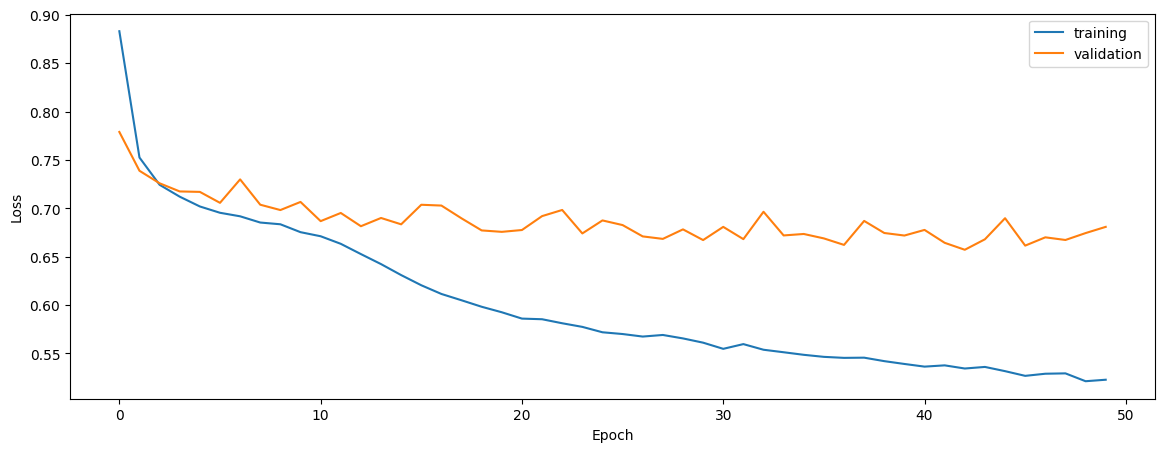

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.7649017466938008


0.7202564634494204


0.7053261418427673


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.781225919335969


0.7324952838568323


0.7419332438313041


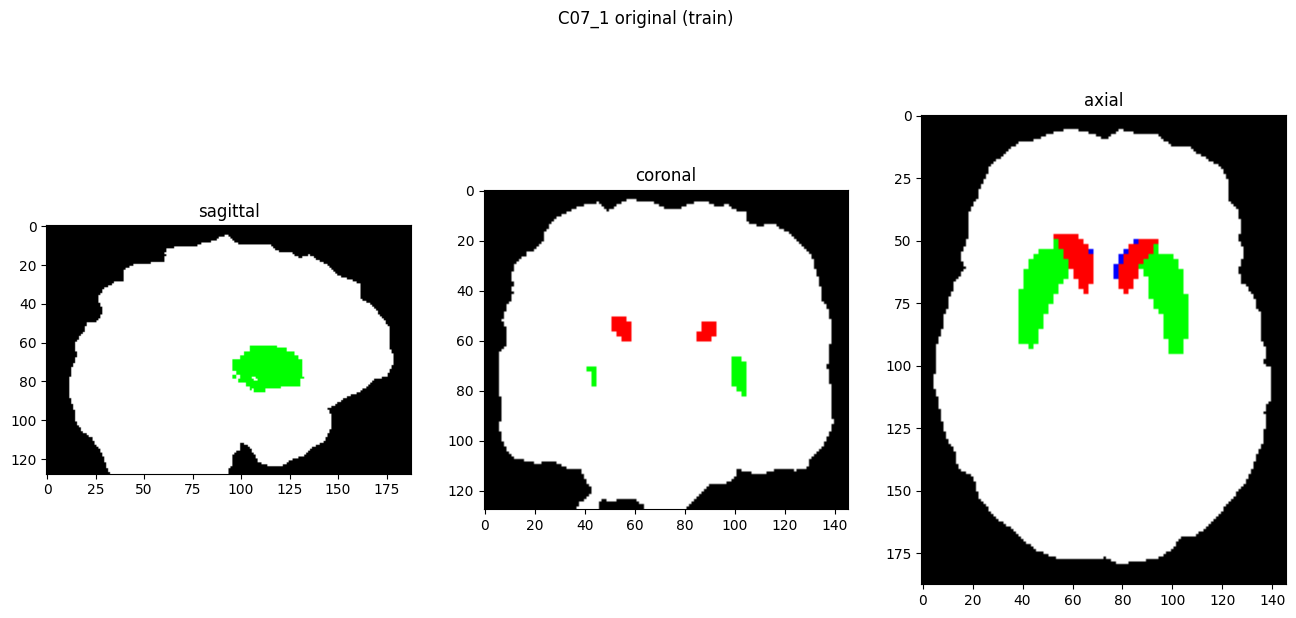

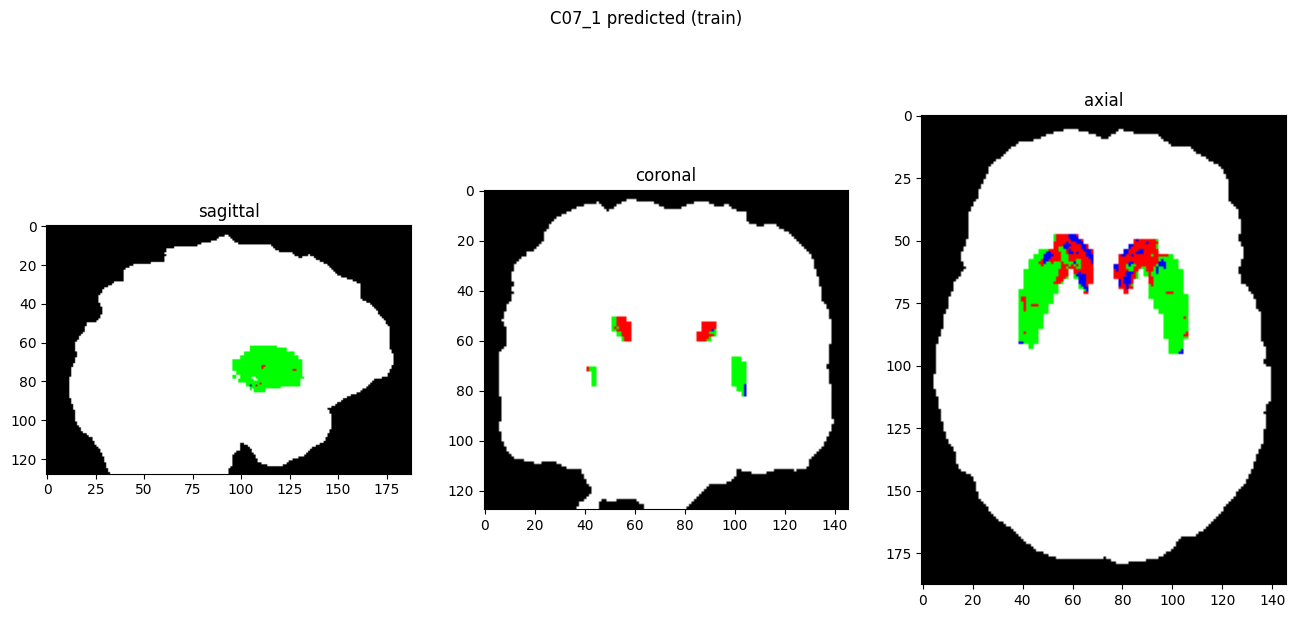

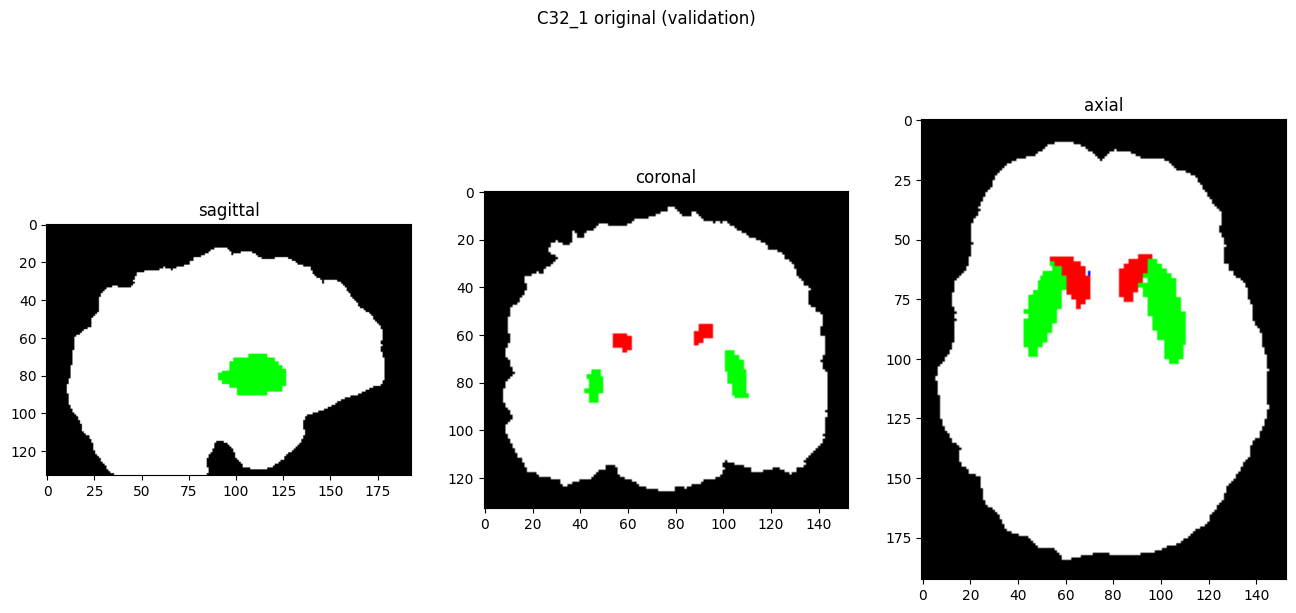

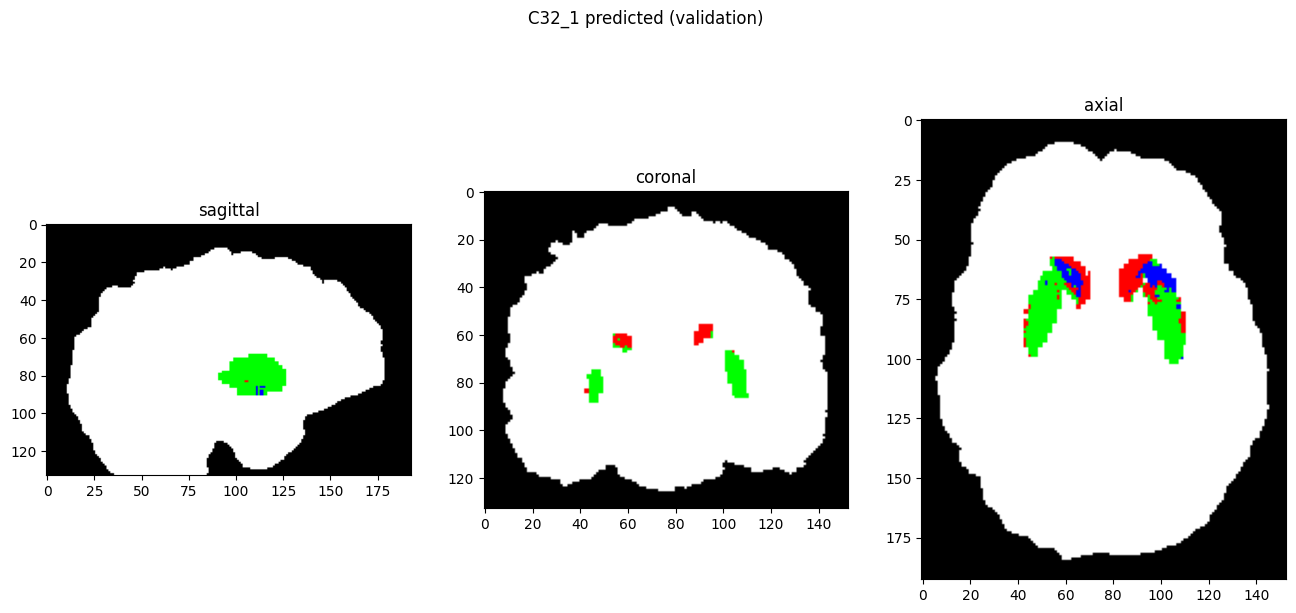

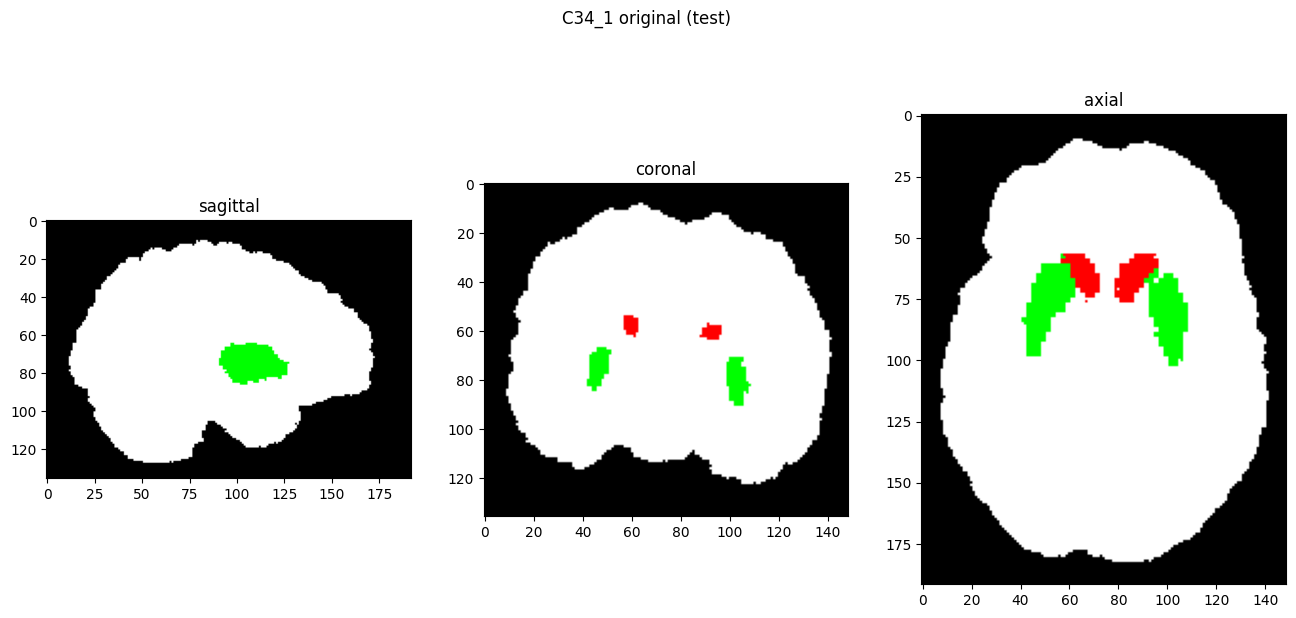

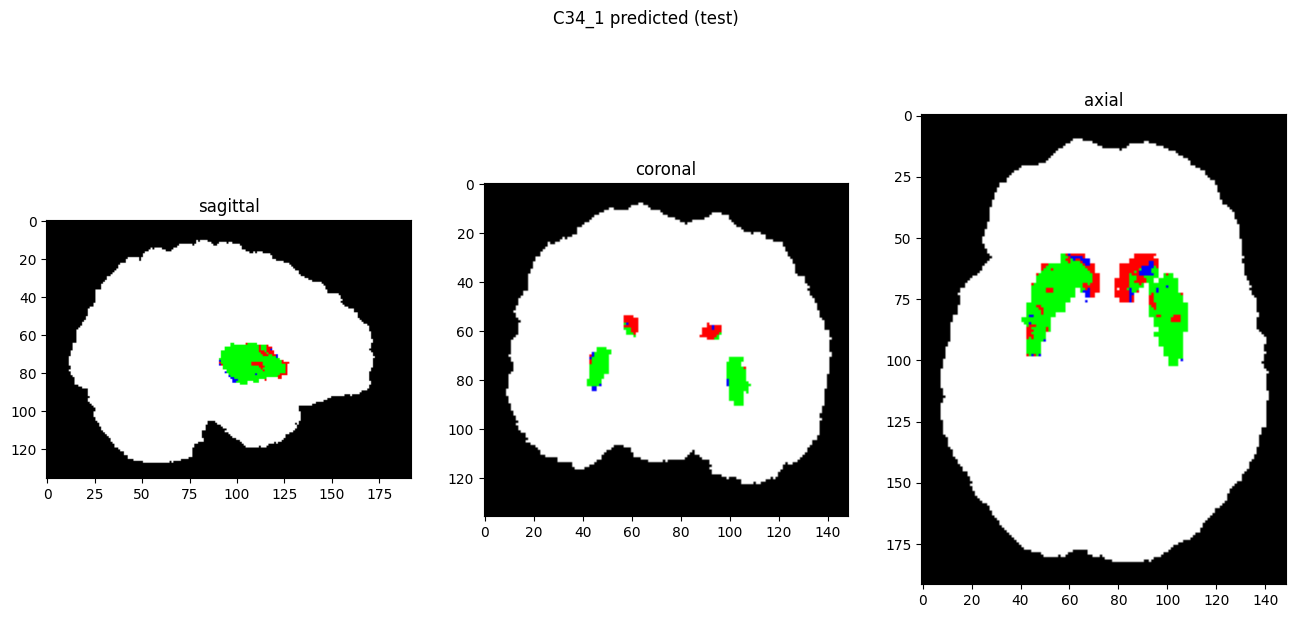

In [9]:
showResults(model, gen, threshold=0)